## Take a look at the histograms (distributions) of CTRL, FULL, PHYS, and RAD in a few basins to see if there are important shifts in the timing of streamflow 
*Updated from MeanStreamflowDistrubtions*
<br> 
<br>
* Basins are defined using a mask created in Matlab
* Cutoff threshold for streamflow minimum: 500 m^3/s 
* Using daily data instead of monthly averages for finer temporal resolution
* Also look at CESM variables and monthly maps of their spatial distribution to determine cause of composite seasonal cycles in selected basins
<br>
<br>
Meg D. Fowler, 2018-06-27

Basins are defined as follows: 
<font color=green>
% Key: <br>
   1.......Yukon <br>
   2.......Mackenzie<br>
   3.......Columbia<br>
   4.......Nelson<br>
   5.......Mississippi<br>
   6.......St-Lawrence<br>
   7.......Rhine<br>
   8.......Danube<br>
   9.......Dniepr<br>
   10......Volga<br>
   11......Ob<br>
   12......Yenisei<br>
   13......Lena<br>
   14......Amur<br>
   15......Orinoco<br>
   16......Parana<br>
   17......Amazonas<br>
   18......Niger<br>
   19......Congo<br>
   20......Nile<br>
   21......Zambezi<br>
   22......Tigris & Euphrates<br>
   23......Indus<br>
   24......Ganges & Brahmaputra<br>
   25......Mekong<br>
   26......Huang-he<br>
   27......Yangtze<br>
   28......Murray & Darling<br>
   29......Don<br>
   30......Fraser<br>
   31......Tocantins<br>
   32......Vuoski & Neva<br>
    </font>

In [1]:
import scipy as scipy
import scipy.stats as stats
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
import time 
import xarray as xr
import pickle 
import os

from netCDF4 import Dataset

<font color=purple> Read in data and define arrays for basic use </font>

In [2]:
#Get dimensions from a single file (same will be used for all files)
file1 = '/Users/meganfowler/gp_fuse/Flooding-physiology/Python/outflw1161.nc'
dat   = Dataset(file1)
lat   = dat.variables['lat'][:] 
lon   = dat.variables['lon'][:] 

#Read in bsin ID identifiers from Matlab file 
basinData = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/BasinMask.mat')
basinMask = basinData['BasinMask']

#Read in CaMa gridcell areas
matData = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/CaMa_gridAreas.mat')
area    = matData['area']

## Read in daily data... 

#Read indices for subsetted data 
lonFile = open("/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/lonIndices_subsetKey.txt","r")
latFile = open("/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/latIndices_subsetKey.txt","r")

lonSubset=[]
for line in lonFile.readlines():
    lonSubset.append(float(line))  

latSubset=[]
for line in latFile.readlines():
    latSubset.append(float(line))

#Set filepaths for daily data
ctrlFile = '/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/Control_outflow_subset.nc'
fullFile = '/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/Full_outflow_subset.nc'
physFile = '/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/Physiology_outflow_subset.nc'
radFile  = '/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/Radiation_outflow_subset.nc'

#Read in outflow data  
fCtrl = xr.open_dataset(ctrlFile,decode_times=False)
fFull = xr.open_dataset(fullFile,decode_times=False)
fPhys = xr.open_dataset(physFile,decode_times=False)
fRad  = xr.open_dataset(radFile,decode_times=False)

outflwCtrl = fCtrl.outflow
outflwFull = fFull.outflow
outflwPhys = fPhys.outflow
outflwRad  = fRad.outflow


In [3]:
#Print some useful shapes 
print('Number of lons is:   ', len(lon))
print('Number of subsets:   ', len(lonSubset) )
print('Shape of basinMask:  ', basinMask.shape)
print('Shape of outflwCtrl: ', outflwCtrl.shape)
print('Shape of area array: ', area.shape)



Number of lons is:    1440
Number of subsets:    10676
Shape of basinMask:   (1440, 720)
Shape of outflwCtrl:  (10676, 10950)
Shape of area array:  (1440, 720)


In [3]:
#Define list of basin names based on key (used in plotting)
basinNames = ['Yukon','Mackenzie','Columbia','Nelson','Mississippi','St-Lawrence','Rhine','Danube','Dniepr','Volga','Ob','Yenisei',\
'Lena','Amur','Orinoco','Parana','Amazonas','Niger','Congo','Nile','Zambezi','Tigris & Euphrates','Indus',\
'Ganges & Brahmaputra','Mekong','Huang-he','Yangtze','Murray & Darling','Don','Fraser','Tocantins','Vuoski & Neva']

#Define time array for plotting too
days = np.arange(365)+1

#Beginning julian days for each month
startMon = [0, 31,59, 90,120,151,181,212,243,273,304,334]
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']



### Map of river basins

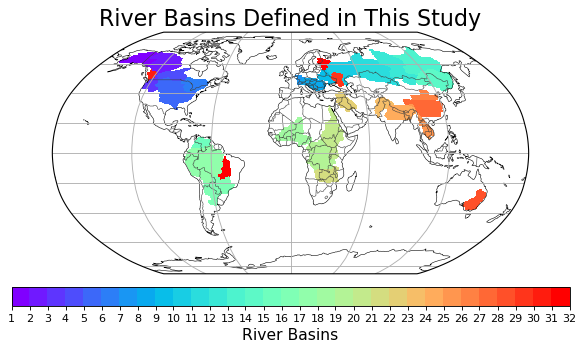

In [4]:
## PLOT basin definitions 

fig=plt.figure(figsize=(9, 4), dpi=80, facecolor='w', edgecolor='k')
my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = np.arange(32)+1
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig.set_size_inches(9,4)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,np.transpose(basinMask),norm=norm,cmap=plt.cm.rainbow,vmin=1,vmax=32,transform=ccrs.PlateCarree())

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(33),cax=cbar_ax)
cbar.set_label('River Basins',fontsize=my_fontsize)
#cbar.ax.set_xticklabels(['1','5','25','50','75', '95','105','125','250','500','1000','>1000'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('River Basins Defined in This Study')
ax.title.set_fontsize(20)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/returnPeriod100_95sig_FULL.jpg',bbox_inches = 'tight')  #Save figure as jpg



### Isolate a single basin
* Check if lat/lon of subset outflow are within basin boundaries 
* Create new arrays with only valid basin points included 
<br>
<br>
<font color=purple> THIS IS WHERE *basinChoice* IS DEFINED </font>
<br>
<br>

In [5]:
#Set basin to be considered 
basinChoice = 17

In [6]:
#Define empty arrays and variable to count number of obs in basin
iSubset  = []
gridArea = []
basinObs = 0

#Loop over every location in the subset of daily data 
for iLoc in range(len(lonSubset)): 
    ilon = int(lonSubset[iLoc])
    ilat = int(latSubset[iLoc])
    
    if (basinMask[ilon,ilat]==basinChoice):
        iSubset = np.append(iSubset,iLoc)               #Save iLoc (index of subset) if in basin
        gridArea = np.append(gridArea,area[ilon,ilat])  #Save area of each valid gridcell   
        basinObs = basinObs+1

iSubset=np.asarray(iSubset,dtype=int)  
print(basinObs, ' points used in this basin.')

1105  points used in this basin.


In [7]:
#Isolate just the data in specified basin for further analysis 

basinLon  = np.take(lonSubset,iSubset)
basinLat  = np.take(latSubset,iSubset)
basinCtrl = np.take(outflwCtrl.values,iSubset,axis=0)
basinFull = np.take(outflwFull.values,iSubset,axis=0)
basinPhys = np.take(outflwPhys.values,iSubset,axis=0)
basinRad  = np.take(outflwRad.values,iSubset,axis=0)

#Checked that at least the first element using np.take is the same as if we had indexed 
#   more intuitively; initial attempts of indexing with just [] didn't work though, and this does. 

print('Shape of new basin arrays: ', np.shape(basinCtrl))


Shape of new basin arrays:  (1105, 10950)


### Create annual climatology over the basin based on daily data 
* Area weight averages for lat/lon 
* Separate into annual periods [30 x 365] and get climatology 

In [56]:
# This cell is a sanity check, not required for successful running of the script 

# iDay = 1
# wgtCtrl = gridArea*basinCtrl[:,iDay]
# np.shape(wgtCtrl)

# print('Area weighted average: ', np.nansum(gridArea*basinCtrl[:,iDay])/np.nansum(gridArea))
# print('Straight average:      ', np.nanmean(basinCtrl[:,iDay],axis=0))


In [8]:
# Area weighted averages 
wgtAvgCtrl = np.full([30*365],np.nan)
wgtAvgFull = np.full([30*365],np.nan)
wgtAvgPhys = np.full([30*365],np.nan)
wgtAvgRad  = np.full([30*365],np.nan)

for iDay in range(30*365): 
    wgtAvgCtrl[iDay] = np.nansum(gridArea*basinCtrl[:,iDay])/np.nansum(gridArea)
    wgtAvgFull[iDay] = np.nansum(gridArea*basinFull[:,iDay])/np.nansum(gridArea)
    wgtAvgPhys[iDay] = np.nansum(gridArea*basinPhys[:,iDay])/np.nansum(gridArea)
    wgtAvgRad[iDay]  = np.nansum(gridArea*basinRad[:,iDay])/np.nansum(gridArea)
    


In [9]:
# Split into 30 years to get at composite seasonal cycle (dimensions are [30 x 365])
annCtrl = np.split(wgtAvgCtrl,30)
annFull = np.split(wgtAvgFull,30)
annPhys = np.split(wgtAvgPhys,30)
annRad  = np.split(wgtAvgRad,30)

# Average over years ()
avgCtrl = np.nanmean(annCtrl,axis=0)
avgFull = np.nanmean(annFull,axis=0)
avgPhys = np.nanmean(annPhys,axis=0) 
avgRad  = np.nanmean(annRad, axis=0)


In [10]:
np.shape(annPhys)

(30, 365)

In [10]:
## Estimate standard error to get at interannual variability 
np.shape(annCtrl)

stdCtrl = np.std(annCtrl,axis=0)
stdFull = np.std(annFull,axis=0)
stdPhys = np.std(annPhys,axis=0)
stdRad  = np.std(annRad,axis=0)

errCtrl = stdCtrl/np.sqrt(30)
errFull = stdFull/np.sqrt(30)
errPhys = stdPhys/np.sqrt(30)
errRad  = stdRad/np.sqrt(30)


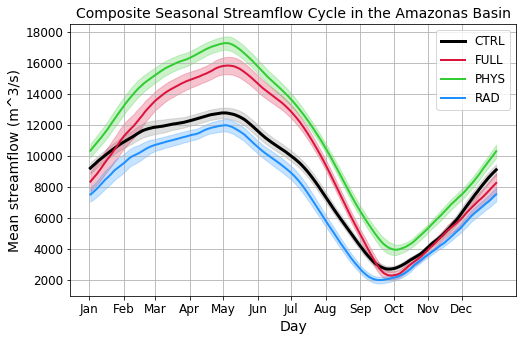

In [11]:
# Plot composite seasonal cycle 

# Look at time series of daily data: 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14

## --- Set axes and size sections --- 
plt.plot(days,avgCtrl,color ='Black',label='CTRL',linewidth=3)
plt.plot(days,avgFull,color ='Crimson',label='FULL',linewidth=2)
plt.plot(days,avgPhys,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(days,avgRad,color='DodgerBlue',label='RAD',linewidth=2)

#Add error "bars"
plt.fill_between(days,avgCtrl-(2*errCtrl),avgCtrl+(2*errCtrl),alpha=0.25,color='Grey')
plt.fill_between(days,avgFull-(2*errFull),avgFull+(2*errFull),alpha=0.25,color='Crimson')
plt.fill_between(days,avgPhys-(2*errPhys),avgPhys+(2*errPhys),alpha=0.25,color='LimeGreen')
plt.fill_between(days,avgRad-(2*errRad),avgRad+(2*errRad),alpha=0.25,color='DodgerBlue')

plt.legend(fontsize=12)
plt.title('Composite Seasonal Streamflow Cycle in the '+basinNames[basinChoice-1]+ ' Basin',fontsize=my_fontsize)
plt.xlabel('Day',fontsize=my_fontsize)
plt.ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
plt.grid()
plt.xticks(startMon,months)
plt.tick_params(axis='both',labelsize=12)

## To plot individual years in a given experiment 
# for iSample in range(30):
#     plt.plot(days,annPhys[iSample][:],color='lightgreen',linestyle='--')
#     plt.plot(days,annCtrl[iSample][:],color='grey',linestyle='--')
# plt.plot(days,avgPhys,color = 'LimeGreen',label='PHYS',linewidth=5)
# plt.plot(days,avgCtrl,color ='Black',label='CTRL',linewidth=5)

#Save the image 
# fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/BasinStreamflow/'+basinNames[basinChoice-1]+'_MeanStreamflowSeasonalCycle.jpg'
# fig.savefig(fileName)  #HOW TO SAVE FIGURES 


## Plot streamflow cycles for selection of basins where *PHYS* dominates *RAD*
* Based on selection in *BasinStreamflow_PhysRadIndexing* where the phys index is at least 0.75 and the rad index is less than 0.5 
* **Selected basins**: Parana, Mekong, Yangtze, Murray & Darling, Orinoco, Amazon, Zambezi, Congo

In [5]:
basinOptions = [15,16,17,19,21,25,27,28]

len(basinOptions)

8

In [6]:
#Set basins to be considered 
basinOptions = [15,16,17,19,21,25,27,28]

#Define empty arrays to save mean annual cycle and std error 
avgCtrl = np.full([len(basinOptions),365], np.nan)
avgFull = np.full([len(basinOptions),365], np.nan)
avgPhys = np.full([len(basinOptions),365], np.nan)
avgRad  = np.full([len(basinOptions),365], np.nan)
errCtrl = np.full([len(basinOptions),365], np.nan)
errFull = np.full([len(basinOptions),365], np.nan)
errPhys = np.full([len(basinOptions),365], np.nan)
errRad  = np.full([len(basinOptions),365], np.nan)

for iBasin in range(len(basinOptions)): 
    basinChoice = basinOptions[iBasin]

    #Define empty arrays and variable to count number of obs in basin
    iSubset  = []
    gridArea = []
    basinObs = 0

    #Loop over every location in the subset of daily data 
    for iLoc in range(len(lonSubset)): 
        ilon = int(lonSubset[iLoc])
        ilat = int(latSubset[iLoc])

        if (basinMask[ilon,ilat]==basinChoice):
            iSubset = np.append(iSubset,iLoc)               #Save iLoc (index of subset) if in basin
            gridArea = np.append(gridArea,area[ilon,ilat])  #Save area of each valid gridcell   
            basinObs = basinObs+1

    iSubset=np.asarray(iSubset,dtype=int)  
    print(basinObs, ' points used in this basin.')
    
    #Isolate just the data in specified basin for further analysis 
    basinLon  = np.take(lonSubset,iSubset)
    basinLat  = np.take(latSubset,iSubset)
    #   Also convert from m^3/s to km^3/day
    basinCtrl = np.take(outflwCtrl.values*86400*1e-9,iSubset,axis=0)
    basinFull = np.take(outflwFull.values*86400*1e-9,iSubset,axis=0)
    basinPhys = np.take(outflwPhys.values*86400*1e-9,iSubset,axis=0)
    basinRad  = np.take(outflwRad.values*86400*1e-9,iSubset,axis=0)

    # Area weighted averages 
    wgtAvgCtrl = np.full([30*365],np.nan)
    wgtAvgFull = np.full([30*365],np.nan)
    wgtAvgPhys = np.full([30*365],np.nan)
    wgtAvgRad  = np.full([30*365],np.nan)

    for iDay in range(30*365): 
        wgtAvgCtrl[iDay] = np.nansum(gridArea*basinCtrl[:,iDay])/np.nansum(gridArea)
        wgtAvgFull[iDay] = np.nansum(gridArea*basinFull[:,iDay])/np.nansum(gridArea)
        wgtAvgPhys[iDay] = np.nansum(gridArea*basinPhys[:,iDay])/np.nansum(gridArea)
        wgtAvgRad[iDay]  = np.nansum(gridArea*basinRad[:,iDay])/np.nansum(gridArea)

    # Split into 30 years to get at composite seasonal cycle (dimensions are [30 x 365])
    annCtrl = np.split(wgtAvgCtrl,30)
    annFull = np.split(wgtAvgFull,30)
    annPhys = np.split(wgtAvgPhys,30)
    annRad  = np.split(wgtAvgRad,30)

    # Average over years ()
    avgCtrl[iBasin,:] = np.nanmean(annCtrl,axis=0)
    avgFull[iBasin,:] = np.nanmean(annFull,axis=0)
    avgPhys[iBasin,:] = np.nanmean(annPhys,axis=0) 
    avgRad[iBasin,:]  = np.nanmean(annRad, axis=0)

    ## Estimate standard error to get at interannual variability 
    np.shape(annCtrl)

    stdCtrl = np.std(annCtrl,axis=0)
    stdFull = np.std(annFull,axis=0)
    stdPhys = np.std(annPhys,axis=0)
    stdRad  = np.std(annRad,axis=0)

    errCtrl[iBasin,:] = stdCtrl/np.sqrt(30)
    errFull[iBasin,:] = stdFull/np.sqrt(30)
    errPhys[iBasin,:] = stdPhys/np.sqrt(30)
    errRad[iBasin,:]  = stdRad/np.sqrt(30)

    print('Done with basin ', iBasin, '(', basinNames[basinOptions[iBasin]-1],')')
    
    

165  points used in this basin.
Done with basin  0 ( Orinoco )
323  points used in this basin.
Done with basin  1 ( Parana )
1105  points used in this basin.
Done with basin  2 ( Amazonas )
705  points used in this basin.
Done with basin  3 ( Congo )
233  points used in this basin.
Done with basin  4 ( Zambezi )
147  points used in this basin.
Done with basin  5 ( Mekong )
463  points used in this basin.
Done with basin  6 ( Yangtze )
65  points used in this basin.
Done with basin  7 ( Murray & Darling )


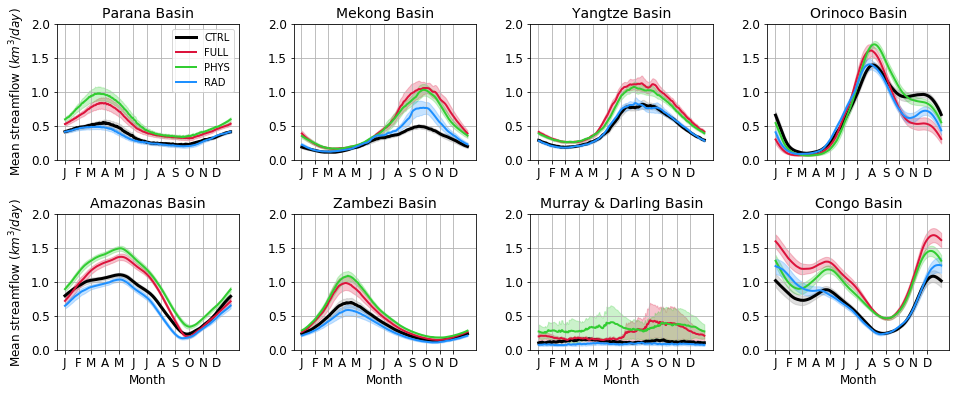

In [7]:
## --- Set up figure window --- 
fig, ax_array = plt.subplots(2,4)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = ax_array.flatten()
fig.set_size_inches(16,6)

# - Subplot 1: Parana - 
ax1.plot(days,avgCtrl[1,:],color ='Black',label='CTRL',linewidth=3)
ax1.plot(days,avgFull[1,:],color ='Crimson',label='FULL',linewidth=2)
ax1.plot(days,avgPhys[1,:],color = 'LimeGreen',label='PHYS',linewidth=2)
ax1.plot(days,avgRad[1,:],color='DodgerBlue',label='RAD',linewidth=2)
#Add error "bars"
ax1.fill_between(days,(avgCtrl[1,:]-(2*errCtrl[1,:])),(avgCtrl[1,:]+(2*errCtrl[1,:])),alpha=0.25,color='Grey')
ax1.fill_between(days,(avgFull[1,:]-(2*errFull[1,:])),(avgFull[1,:]+(2*errFull[1,:])),alpha=0.25,color='Crimson')
ax1.fill_between(days,(avgPhys[1,:]-(2*errPhys[1,:])),(avgPhys[1,:]+(2*errPhys[1,:])),alpha=0.25,color='LimeGreen')
ax1.fill_between(days,(avgRad[1,:]-(2*errRad[1,:])),(avgRad[1,:]+(2*errRad[1,:])),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax1.legend(fontsize=10,ncol=1)
ax1.set_title(basinNames[basinOptions[1]-1]+ ' Basin',fontsize=14)
ax1.set_ylabel('Mean streamflow '+r'$(km^3/day)$',fontsize=12)
ax1.grid()
ax1.set_xticks(startMon)
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylim(0,2)

# - Subplot 2: Mekong - 
ax2.plot(days,avgCtrl[5,:],color ='Black',label='CTRL',linewidth=3)
ax2.plot(days,avgFull[5,:],color ='Crimson',label='FULL',linewidth=2)
ax2.plot(days,avgPhys[5,:],color = 'LimeGreen',label='PHYS',linewidth=2)
ax2.plot(days,avgRad[5,:],color='DodgerBlue',label='RAD',linewidth=2)
#Add error "bars"
ax2.fill_between(days,(avgCtrl[5,:]-(2*errCtrl[5,:])),(avgCtrl[5,:]+(2*errCtrl[5,:])),alpha=0.25,color='Grey')
ax2.fill_between(days,(avgFull[5,:]-(2*errFull[5,:])),(avgFull[5,:]+(2*errFull[5,:])),alpha=0.25,color='Crimson')
ax2.fill_between(days,(avgPhys[5,:]-(2*errPhys[5,:])),(avgPhys[5,:]+(2*errPhys[5,:])),alpha=0.25,color='LimeGreen')
ax2.fill_between(days,(avgRad[5,:]-(2*errRad[5,:])),(avgRad[5,:]+(2*errRad[5,:])),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax2.set_title(basinNames[basinOptions[5]-1]+ ' Basin',fontsize=14)
ax2.grid()
ax2.set_xticks(startMon)
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylim(0,2)

# - Subplot 3: Yangtze - 
ax3.plot(days,avgCtrl[6,:],color ='Black',label='CTRL',linewidth=3)
ax3.plot(days,avgFull[6,:],color ='Crimson',label='FULL',linewidth=2)
ax3.plot(days,avgPhys[6,:],color = 'LimeGreen',label='PHYS',linewidth=2)
ax3.plot(days,avgRad[6,:],color='DodgerBlue',label='RAD',linewidth=2)
#Add error "bars"
ax3.fill_between(days,(avgCtrl[6,:]-(2*errCtrl[6,:])),(avgCtrl[6,:]+(2*errCtrl[6,:])),alpha=0.25,color='Grey')
ax3.fill_between(days,(avgFull[6,:]-(2*errFull[6,:])),(avgFull[6,:]+(2*errFull[6,:])),alpha=0.25,color='Crimson')
ax3.fill_between(days,(avgPhys[6,:]-(2*errPhys[6,:])),(avgPhys[6,:]+(2*errPhys[6,:])),alpha=0.25,color='LimeGreen')
ax3.fill_between(days,(avgRad[6,:]-(2*errRad[6,:])),(avgRad[6,:]+(2*errRad[6,:])),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax3.set_title(basinNames[basinOptions[6]-1]+ ' Basin',fontsize=14)
ax3.grid()
ax3.set_xticks(startMon)
ax3.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax3.tick_params(axis='both',labelsize=12)
ax3.set_ylim(0,2)

# - Subplot 4: Orinoco - 
ax4.plot(days,avgCtrl[0,:],color ='Black',label='CTRL',linewidth=3)
ax4.plot(days,avgFull[0,:],color ='Crimson',label='FULL',linewidth=2)
ax4.plot(days,avgPhys[0,:],color = 'LimeGreen',label='PHYS',linewidth=2)
ax4.plot(days,avgRad[0,:],color='DodgerBlue',label='RAD',linewidth=2)
#Add error "bars"
ax4.fill_between(days,(avgCtrl[0,:]-(2*errCtrl[0,:])),(avgCtrl[0,:]+(2*errCtrl[0,:])),alpha=0.25,color='Grey')
ax4.fill_between(days,(avgFull[0,:]-(2*errFull[0,:])),(avgFull[0,:]+(2*errFull[0,:])),alpha=0.25,color='Crimson')
ax4.fill_between(days,(avgPhys[0,:]-(2*errPhys[0,:])),(avgPhys[0,:]+(2*errPhys[0,:])),alpha=0.25,color='LimeGreen')
ax4.fill_between(days,(avgRad[0,:]-(2*errRad[0,:])),(avgRad[0,:]+(2*errRad[0,:])),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax4.set_title(basinNames[basinOptions[0]-1]+ ' Basin',fontsize=14)
ax4.grid()
ax4.set_xticks(startMon)
ax4.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax4.tick_params(axis='both',labelsize=12)
ax4.set_ylim(0,2)

# - Subplot 5: Amazon - 
ax5.plot(days,avgCtrl[2,:],color ='Black',label='CTRL',linewidth=3)
ax5.plot(days,avgFull[2,:],color ='Crimson',label='FULL',linewidth=2)
ax5.plot(days,avgPhys[2,:],color = 'LimeGreen',label='PHYS',linewidth=2)
ax5.plot(days,avgRad[2,:],color='DodgerBlue',label='RAD',linewidth=2)
#Add error "bars"
ax5.fill_between(days,(avgCtrl[2,:]-(2*errCtrl[2,:])),(avgCtrl[2,:]+(2*errCtrl[2,:])),alpha=0.25,color='Grey')
ax5.fill_between(days,(avgFull[2,:]-(2*errFull[2,:])),(avgFull[2,:]+(2*errFull[2,:])),alpha=0.25,color='Crimson')
ax5.fill_between(days,(avgPhys[2,:]-(2*errPhys[2,:])),(avgPhys[2,:]+(2*errPhys[2,:])),alpha=0.25,color='LimeGreen')
ax5.fill_between(days,(avgRad[2,:]-(2*errRad[2,:])),(avgRad[2,:]+(2*errRad[2,:])),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax5.set_title(basinNames[basinOptions[2]-1]+ ' Basin',fontsize=14)
ax5.set_xlabel('Month',fontsize=12)
ax5.set_ylabel('Mean streamflow '+r'$(km^3/day)$',fontsize=12)
ax5.grid()
ax5.set_xticks(startMon)
ax5.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax5.tick_params(axis='both',labelsize=12)
ax5.set_ylim(0,2)

# - Subplot 6: Zambezi - 
ax6.plot(days,avgCtrl[4,:],color ='Black',label='CTRL',linewidth=3)
ax6.plot(days,avgFull[4,:],color ='Crimson',label='FULL',linewidth=2)
ax6.plot(days,avgPhys[4,:],color = 'LimeGreen',label='PHYS',linewidth=2)
ax6.plot(days,avgRad[4,:],color='DodgerBlue',label='RAD',linewidth=2)
#Add error "bars"
ax6.fill_between(days,(avgCtrl[4,:]-(2*errCtrl[4,:])),(avgCtrl[4,:]+(2*errCtrl[4,:])),alpha=0.25,color='Grey')
ax6.fill_between(days,(avgFull[4,:]-(2*errFull[4,:])),(avgFull[4,:]+(2*errFull[4,:])),alpha=0.25,color='Crimson')
ax6.fill_between(days,(avgPhys[4,:]-(2*errPhys[4,:])),(avgPhys[4,:]+(2*errPhys[4,:])),alpha=0.25,color='LimeGreen')
ax6.fill_between(days,(avgRad[4,:]-(2*errRad[4,:])),(avgRad[4,:]+(2*errRad[4,:])),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax6.set_title(basinNames[basinOptions[4]-1]+ ' Basin',fontsize=14)
ax6.set_xlabel('Month',fontsize=12)
ax6.grid()
ax6.set_xticks(startMon)
ax6.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax6.tick_params(axis='both',labelsize=12)
ax6.set_ylim(0,2)

# - Subplot 7: Murray & Darling - 
ax7.plot(days,avgCtrl[7,:],color ='Black',label='CTRL',linewidth=3)
ax7.plot(days,avgFull[7,:],color ='Crimson',label='FULL',linewidth=2)
ax7.plot(days,avgPhys[7,:],color = 'LimeGreen',label='PHYS',linewidth=2)
ax7.plot(days,avgRad[7,:],color='DodgerBlue',label='RAD',linewidth=2)
#Add error "bars"
ax7.fill_between(days,(avgCtrl[7,:]-(2*errCtrl[7,:])),(avgCtrl[7,:]+(2*errCtrl[7,:])),alpha=0.25,color='Grey')
ax7.fill_between(days,(avgFull[7,:]-(2*errFull[7,:])),(avgFull[7,:]+(2*errFull[7,:])),alpha=0.25,color='Crimson')
ax7.fill_between(days,(avgPhys[7,:]-(2*errPhys[7,:])),(avgPhys[7,:]+(2*errPhys[7,:])),alpha=0.25,color='LimeGreen')
ax7.fill_between(days,(avgRad[7,:]-(2*errRad[7,:])),(avgRad[7,:]+(2*errRad[7,:])),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax7.set_title(basinNames[basinOptions[7]-1]+ ' Basin',fontsize=14)
ax7.set_xlabel('Month',fontsize=12)
ax7.grid()
ax7.set_xticks(startMon)
ax7.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax7.tick_params(axis='both',labelsize=12)
ax7.set_ylim(0,2)

# - Subplot 8: Congo- 
ax8.plot(days,avgCtrl[3,:],color ='Black',label='CTRL',linewidth=3)
ax8.plot(days,avgFull[3,:],color ='Crimson',label='FULL',linewidth=2)
ax8.plot(days,avgPhys[3,:],color = 'LimeGreen',label='PHYS',linewidth=2)
ax8.plot(days,avgRad[3,:],color='DodgerBlue',label='RAD',linewidth=2)
#Add error "bars"
ax8.fill_between(days,(avgCtrl[3,:]-(2*errCtrl[3,:])),(avgCtrl[3,:]+(2*errCtrl[3,:])),alpha=0.25,color='Grey')
ax8.fill_between(days,(avgFull[3,:]-(2*errFull[3,:])),(avgFull[3,:]+(2*errFull[3,:])),alpha=0.25,color='Crimson')
ax8.fill_between(days,(avgPhys[3,:]-(2*errPhys[3,:])),(avgPhys[3,:]+(2*errPhys[3,:])),alpha=0.25,color='LimeGreen')
ax8.fill_between(days,(avgRad[3,:]-(2*errRad[3,:])),(avgRad[3,:]+(2*errRad[3,:])),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax8.set_title(basinNames[basinOptions[3]-1]+ ' Basin',fontsize=14)
ax8.set_xlabel('Month',fontsize=12)
ax8.grid()
ax8.set_xticks(startMon)
ax8.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax8.tick_params(axis='both',labelsize=12)
ax8.set_ylim(0,2)

plt.subplots_adjust(wspace=0.3,hspace=0.4)


#Save the image 
#fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/BasinStreamflow/physDominantStreamflowSeasonalCycle.jpg'
#fig.savefig(fileName,bbox_inches = 'tight')  #HOW TO SAVE FIGURES 



## Can the seasonal cycles of CESM variables explain some of these apparent shifts or amplitude changes?

In [66]:
# Read in rainfall and soil liquid 
# fCtrl = xr.open_dataset((fileBase + 'cesm1_0_6.1850_prei.1deg.001.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
# ctrlRain = fCtrl.RAIN         #[mm/s]

# fFull = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
# fullRain = fFull.RAIN

# fPhys = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fixgb.1deg.001.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
# physRain = fPhys.RAIN

# fRad  = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
# radRain  = fRad.RAIN



In [71]:
# print('Reading in total precipitation...')
# fCtrl_prect = xr.open_dataset((fileBase+'cesm1_0_6.1850_prei.1deg.001.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False) 
# ctrlPrect = fCtrl_prect.PRECT     #[m/s]
# print('PRECT')
# ctrlPrecsc = fCtrl_prect.PRECSC
# print('PRECSC')
# ctrlPrecsl = fCtrl_prect.PRECSL
# print('PRECSL')
# ctrlPrecip = ctrlPrect+ctrlPrecsc+ctrlPrecsl

fFull_prect = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fulgb.1deg.002.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False)
fullPrect = fFull_prect.PRECT
print('PRECT')
fullPrecsc = fFull_prect.PRECSC
print('PRECSC')
fullPrecsl = fFull_prect.PRECSL
print('PRECSL')
fullPrecip = fullPrect+fullPrecsc+fullPrecsl 

# fPhys_prect = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fixgb.1deg.001.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False)
# physPrect = fPhys_prect.PRECT
# print('PRECT')
# physPrecsc = fPhys_prect.PRECSC
# print('PRECSC')
# physPrecsl = fPhys_prect.PRECSL
# print('PRECSL')
# physPrecip = physPrect+physPrecsc+physPrecsl

# fRad_prect  = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False)
# radPrect  = fRad_prect.PRECT
# print('PRECT')
# radPrecsc  = fRad_prect.PRECSC
# print('PRECSC')
# radPrecsl  = fRad_prect.PRECSL
# print('PRECSL')
# radPrecip  = radPrect+radPrecsc+radPrecsl



PRECT
PRECSC
PRECSL


In [3]:
#Read in monthly CESM data  
fileBase = '/Users/meganfowler/gp_fuse/Flooding-physiology/RelatedCESMvariables/'

# Read in snow melt 
print('Reading in snow melt...')
fCtrl_melt = xr.open_dataset((fileBase + 'cesm1_0_6.1850_prei.1deg.001.clm2.h0.QMELT.nc'),decode_times=False)
fFull_melt = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.h0.QMELT.nc'),decode_times=False)
fPhys_melt = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fixgb.1deg.001.clm2.h0.QMELT.nc'),decode_times=False)
fRad_melt  = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.clm2.h0.QMELT.nc'),decode_times=False)

ctrlMelt = fCtrl_melt.QMELT   #[mm/s]
fullMelt = fFull_melt.QMELT
physMelt = fPhys_melt.QMELT
radMelt  = fRad_melt.QMELT

# Read in rainfall and soil liquid 
fCtrl = xr.open_dataset((fileBase + 'cesm1_0_6.1850_prei.1deg.001.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
fFull = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
fPhys = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fixgb.1deg.001.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
fRad  = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.clm2.MonthlyConcat_Meg.nc'),decode_times=False)

#CESM lat and lon
cesmLon = fCtrl.lon.values
cesmLat = fCtrl.lat.values

# #Temperature 
# ctrlTemp = fCtrl.TSA   #2m air temperature [K]
# fullTemp = fFull.TSA
# physTemp = fPhys.TSA
# radTemp  = fRad.TSA

#Rainfall 
ctrlRain = fCtrl.RAIN         #[mm/s]
fullRain = fFull.RAIN
physRain = fPhys.RAIN
radRain  = fRad.RAIN

#Soil Moisture
print('Reading in soil moisture...')
ctrlSoilLiq = fCtrl.SOILLIQ
fullSoilLiq = fFull.SOILLIQ
physSoilLiq = fPhys.SOILLIQ
radSoilLiq  = fRad.SOILLIQ

#Read in variables for ET
print('Reading in ET variables...')
ctrlQsoil = fCtrl.QSOIL
ctrlQvege = fCtrl.QVEGE
ctrlQvegt = fCtrl.QVEGT
fullQsoil = fFull.QSOIL
fullQvege = fFull.QVEGE
fullQvegt = fFull.QVEGT
physQsoil = fPhys.QSOIL
physQvege = fPhys.QVEGE
physQvegt = fPhys.QVEGT 
radQsoil  = fRad.QSOIL
radQvege  = fRad.QVEGE
radQvegt  = fRad.QVEGT

# Read in soil ice 
print('Reading in soil ice variables...')
fCtrl_ice = xr.open_dataset((fileBase + 'cesm1_0_6.1850_prei.1deg.001.clm2.MonthlySoilIce.nc'),decode_times=False)
fFull_ice = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlySoilIce.nc'),decode_times=False)
fPhys_ice = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fixgb.1deg.001.clm2.MonthlySoilIce.nc'),decode_times=False)
fRad_ice  = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.clm2.MonthlySoilIce.nc'),decode_times=False)

ctrlSoilIce = fCtrl_ice.SOILICE
fullSoilIce = fFull_ice.SOILICE
physSoilIce = fPhys_ice.SOILICE
radSoilIce  = fRad_ice.SOILICE

#Define total soil moisture 
ctrlSoil = ctrlSoilLiq + ctrlSoilIce
fullSoil = fullSoilLiq + fullSoilIce
physSoil = physSoilLiq + physSoilIce
radSoil  = radSoilLiq  + radSoilIce
#Define 1m soil moisture 
ctrlSoil_1m = np.nansum(ctrlSoil[:,0:7,:,:],axis=1)  #[kg/m2]
fullSoil_1m = np.nansum(fullSoil[:,0:7,:,:],axis=1)
physSoil_1m = np.nansum(physSoil[:,0:7,:,:],axis=1)
radSoil_1m  = np.nansum(radSoil[:,0:7,:,:],axis=1)

# # Read in runoff 
# print('Reading in runoff...')
# fCtrl_run = xr.open_dataset(('/Users/meganfowler/gp_fuse/Flooding-physiology/rawRunoff/cesm1_0_6.1850_prei.1deg.001.clm2.MonthlyRunoff.nc'),decode_times=False)
# fFull_run = xr.open_dataset(('/Users/meganfowler/gp_fuse/Flooding-physiology/rawRunoff/cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlyRunoff.nc'),decode_times=False)
# fPhys_run = xr.open_dataset(('/Users/meganfowler/gp_fuse/Flooding-physiology/rawRunoff/cesm1_0_6.1850_4xco2_fixgb.1deg.001.clm2.MonthlyRunoff.nc'),decode_times=False)
# fRad_run  = xr.open_dataset(('/Users/meganfowler/gp_fuse/Flooding-physiology/rawRunoff/cesm1_0_6.1850_4xco2_fdbgb.1deg.002.clm2.MonthlyRunoff.nc'),decode_times=False)

# ctrlRunoff = fCtrl_run.QRUNOFF     #[mm/s]
# fullRunoff = fFull_run.QRUNOFF
# physRunoff = fPhys_run.QRUNOFF
# radRunoff  = fRad_run.QRUNOFF

# #Read in total precipitation (liq+ice)
print('Reading in total precipitation...')
fCtrl_prect = xr.open_dataset((fileBase+'cesm1_0_6.1850_prei.1deg.001.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False) 
fFull_prect = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fulgb.1deg.002.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False)
fPhys_prect = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fixgb.1deg.001.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False)
fRad_prect  = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False)

ctrlPrect = fCtrl_prect.PRECT     #[m/s]
fullPrect = fFull_prect.PRECT
physPrect = fPhys_prect.PRECT
radPrect  = fRad_prect.PRECT

ctrlPrecsc = fCtrl_prect.PRECSC
fullPrecsc = fFull_prect.PRECSC
physPrecsc = fPhys_prect.PRECSC
radPrecsc  = fRad_prect.PRECSC

ctrlPrecsl = fCtrl_prect.PRECSL
fullPrecsl = fFull_prect.PRECSL
physPrecsl = fPhys_prect.PRECSL
radPrecsl  = fRad_prect.PRECSL

ctrlPrecip = ctrlPrect+ctrlPrecsc+ctrlPrecsl
fullPrecip = fullPrect+fullPrecsc+fullPrecsl 
physPrecip = physPrect+physPrecsc+physPrecsl
radPrecip  = radPrect+radPrecsc+radPrecsl

#Read in total projected leaf area index (TLAI) in ctrl 
# print('Reading in LAI...')
# fCtrl_lai = xr.open_dataset((fileBase+'cesm1_0_6.1850_prei.1deg.001.clm2.MonthlyTLAI.nc'),decode_times=False) 
# fFull_lai = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlyTLAI.nc'),decode_times=False) 
# fPhys_lai = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fixgb.1deg.001.clm2.MonthlyTLAI.nc'),decode_times=False) 
# fRad_lai = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.clm2.MonthlyTLAI.nc'),decode_times=False) 

# ctrlLAI   = fCtrl_lai.TLAI
# fullLAI   = fFull_lai.TLAI
# physLAI   = fPhys_lai.TLAI
# radLAI    = fRad_lai.TLAI 

# #Read in basin mask at CESM resolution 
# basinData = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/BasinMask_CESMres.mat')
# basinMask_CESM = basinData['basinMaskNew']

# #Gridcell area at CESM resolution 
# cesmArea = fCtrl.area.values


Reading in snow melt...
Reading in soil moisture...
Reading in ET variables...
Reading in soil ice variables...
Reading in total precipitation...


In [4]:
#Compute ET from time averages first and convert from mm/s to mm/day

ctrlQsoil_avg = np.nanmean(ctrlQsoil,axis=0)*86400.0
ctrlQvege_avg = np.nanmean(ctrlQvege,axis=0)*86400.0
ctrlQvegt_avg = np.nanmean(ctrlQvegt,axis=0)*86400.0

fullQsoil_avg = np.nanmean(fullQsoil,axis=0)*86400.0
fullQvege_avg = np.nanmean(fullQvege,axis=0)*86400.0
fullQvegt_avg = np.nanmean(fullQvegt,axis=0)*86400.0

physQsoil_avg = np.nanmean(physQsoil,axis=0)*86400.0
physQvege_avg = np.nanmean(physQvege,axis=0)*86400.0
physQvegt_avg = np.nanmean(physQvegt,axis=0)*86400.0

radQsoil_avg = np.nanmean(radQsoil,axis=0)*86400.0
radQvege_avg = np.nanmean(radQvege,axis=0)*86400.0
radQvegt_avg = np.nanmean(radQvegt,axis=0)*86400.0


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice


In [11]:
np.shape(ctrlQsoil_avg)


(192, 288)

In [5]:
#Compute ET
ctrlET = np.zeros(np.shape(ctrlQvegt_avg))
fullET = np.zeros(np.shape(ctrlQvegt_avg))
physET = np.zeros(np.shape(ctrlQvegt_avg))
radET = np.zeros(np.shape(ctrlQvegt_avg))

for ilat in range(len(cesmLat)):
    for ilon in range(len(cesmLon)): 
        #for it in range(360):             
        
        #Define CTRL ET
        if np.isnan(ctrlQsoil_avg[ilat,ilon])==False: 
            ctrlET[ilat,ilon] = ctrlET[ilat,ilon]+ctrlQsoil_avg[ilat,ilon]
        if np.isnan(ctrlQvege_avg[ilat,ilon])==False:
            ctrlET[ilat,ilon] = ctrlET[ilat,ilon]+ctrlQvege_avg[ilat,ilon]   
        if np.isnan(ctrlQvegt_avg[ilat,ilon])==False:
            ctrlET[ilat,ilon] = ctrlET[ilat,ilon]+ctrlQvegt_avg[ilat,ilon]  
            
            
        #Define FULL ET    
        if np.isnan(fullQsoil_avg[ilat,ilon])==False: 
            fullET[ilat,ilon] = fullET[ilat,ilon]+fullQsoil_avg[ilat,ilon]
        if np.isnan(fullQvege_avg[ilat,ilon])==False: 
            fullET[ilat,ilon] = fullET[ilat,ilon]+fullQvege_avg[ilat,ilon]
        if np.isnan(fullQvegt_avg[ilat,ilon])==False: 
            fullET[ilat,ilon] = fullET[ilat,ilon]+fullQvegt_avg[ilat,ilon]               
        
        #Define PHYS ET 
        if np.isnan(physQsoil_avg[ilat,ilon])==False:
            physET[ilat,ilon] = physET[ilat,ilon]+physQsoil_avg[ilat,ilon]
        if np.isnan(physQvege_avg[ilat,ilon])==False: 
            physET[ilat,ilon] = physET[ilat,ilon]+physQvege_avg[ilat,ilon]
        if np.isnan(physQvegt_avg[ilat,ilon])==False: 
            physET[ilat,ilon] = physET[ilat,ilon]+physQvegt_avg[ilat,ilon]           
        
        #Define RAD ET 
        if np.isnan(radQsoil_avg[ilat,ilon])==False: 
            radET[ilat,ilon] = radET[ilat,ilon]+radQsoil_avg[ilat,ilon]
        if np.isnan(radQvege_avg[ilat,ilon])==False: 
            radET[ilat,ilon] = radET[ilat,ilon]+radQvege_avg[ilat,ilon]
        if np.isnan(radQvegt_avg[ilat,ilon])==False: 
            radET[ilat,ilon] = radET[ilat,ilon]+radQvegt_avg[ilat,ilon]

    print('Done with lat ',ilat,' of ',len(cesmLat))
    #If not using temporal averages, takes about 1h 6m 


Done with lat  0  of  192
Done with lat  1  of  192
Done with lat  2  of  192
Done with lat  3  of  192
Done with lat  4  of  192
Done with lat  5  of  192
Done with lat  6  of  192
Done with lat  7  of  192
Done with lat  8  of  192
Done with lat  9  of  192
Done with lat  10  of  192
Done with lat  11  of  192
Done with lat  12  of  192
Done with lat  13  of  192
Done with lat  14  of  192
Done with lat  15  of  192
Done with lat  16  of  192
Done with lat  17  of  192
Done with lat  18  of  192
Done with lat  19  of  192
Done with lat  20  of  192
Done with lat  21  of  192
Done with lat  22  of  192
Done with lat  23  of  192
Done with lat  24  of  192
Done with lat  25  of  192
Done with lat  26  of  192
Done with lat  27  of  192
Done with lat  28  of  192
Done with lat  29  of  192
Done with lat  30  of  192
Done with lat  31  of  192
Done with lat  32  of  192
Done with lat  33  of  192
Done with lat  34  of  192
Done with lat  35  of  192
Done with lat  36  of  192
Done with l

In [9]:
# print('Number of longitudes in CESM: ', len(cesmLon))
# print('Shape of variables in CESM:   ', fullRain.shape)
# print('Shape of basin mask in CESM:  ', basinMask_CESM.shape)

In [8]:
# Isolate data for the selected basin (defined above)

#Define empty arrays 
basinRainCtrl = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinRainFull = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinRainPhys = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinRainRad  = np.full([360,len(cesmLat),len(cesmLon)],np.nan)

basinMeltCtrl = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinMeltFull = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinMeltPhys = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinMeltRad  = np.full([360,len(cesmLat),len(cesmLon)],np.nan)

basinSoilCtrl = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinSoilFull = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinSoilPhys = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinSoilRad  = np.full([360,len(cesmLat),len(cesmLon)],np.nan)

basinRunoffCtrl = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinRunoffFull = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinRunoffPhys = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinRunoffRad  = np.full([360,len(cesmLat),len(cesmLon)],np.nan)

basinPrecipCtrl = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinPrecipFull = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinPrecipPhys = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
basinPrecipRad  = np.full([360,len(cesmLat),len(cesmLon)],np.nan)

for ilat in range(len(cesmLat)):
    for ilon in range(len(cesmLon)):
        if (basinMask_CESM[ilon,ilat]==basinChoice):
            basinRainCtrl[:,ilat,ilon]=ctrlRain[:,ilat,ilon]
            basinRainFull[:,ilat,ilon]=fullRain[:,ilat,ilon]
            basinRainPhys[:,ilat,ilon]=physRain[:,ilat,ilon]
            basinRainRad[:,ilat,ilon] =radRain[:,ilat,ilon]
            
            basinMeltCtrl[:,ilat,ilon]=ctrlMelt[:,ilat,ilon]
            basinMeltFull[:,ilat,ilon]=fullMelt[:,ilat,ilon]
            basinMeltPhys[:,ilat,ilon]=physMelt[:,ilat,ilon]
            basinMeltRad[:,ilat,ilon] =radMelt[:,ilat,ilon]
   
            basinSoilCtrl[:,ilat,ilon]=ctrlSoil_1m[:,ilat,ilon]
            basinSoilFull[:,ilat,ilon]=fullSoil_1m[:,ilat,ilon]
            basinSoilPhys[:,ilat,ilon]=physSoil_1m[:,ilat,ilon]
            basinSoilRad[:,ilat,ilon] =radSoil_1m[:,ilat,ilon]
            
            basinRunoffCtrl[:,ilat,ilon]=ctrlRunoff[:,ilat,ilon]
            basinRunoffFull[:,ilat,ilon]=fullRunoff[:,ilat,ilon]
            basinRunoffPhys[:,ilat,ilon]=physRunoff[:,ilat,ilon]
            basinRunoffRad[:,ilat,ilon] =radRunoff[:,ilat,ilon]
            
            basinPrecipCtrl[:,ilat,ilon]=ctrlPrecip[:,ilat,ilon]
            basinPrecipFull[:,ilat,ilon]=fullPrecip[:,ilat,ilon]
            basinPrecipPhys[:,ilat,ilon]=physPrecip[:,ilat,ilon]
            basinPrecipRad[:,ilat,ilon] =radPrecip[:,ilat,ilon]
            

* Area weight averages

In [9]:
## Area weighting 

#Define empty arrays 
wgtRainCtrl = np.full([360],np.nan)
wgtRainFull = np.full([360],np.nan) 
wgtRainPhys = np.full([360],np.nan)
wgtRainRad  = np.full([360],np.nan)
wgtMeltCtrl = np.full([360],np.nan)
wgtMeltFull = np.full([360],np.nan)
wgtMeltPhys = np.full([360],np.nan)
wgtMeltRad  = np.full([360],np.nan)
wgtSoilCtrl = np.full([360],np.nan)
wgtSoilFull = np.full([360],np.nan)
wgtSoilPhys = np.full([360],np.nan)
wgtSoilRad  = np.full([360],np.nan)
wgtRunoffCtrl = np.full([360],np.nan)
wgtRunoffFull = np.full([360],np.nan)
wgtRunoffPhys = np.full([360],np.nan)
wgtRunoffRad  = np.full([360],np.nan)

for iMon in range(360):
    wgtRainCtrl[iMon] = np.nansum(np.nansum(cesmArea*basinRainCtrl[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtRainFull[iMon] = np.nansum(np.nansum(cesmArea*basinRainFull[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtRainPhys[iMon] = np.nansum(np.nansum(cesmArea*basinRainPhys[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtRainRad[iMon]  = np.nansum(np.nansum(cesmArea*basinRainRad[iMon,:,:]))/np.nansum(np.nansum(cesmArea))

    wgtMeltCtrl[iMon] = np.nansum(np.nansum(cesmArea*basinMeltCtrl[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtMeltFull[iMon] = np.nansum(np.nansum(cesmArea*basinMeltFull[iMon,:,:]))/np.nansum(np.nansum(cesmArea)) 
    wgtMeltPhys[iMon] = np.nansum(np.nansum(cesmArea*basinMeltPhys[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtMeltRad[iMon]  = np.nansum(np.nansum(cesmArea*basinMeltRad[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    
    wgtSoilCtrl[iMon] = np.nansum(np.nansum(cesmArea*basinSoilCtrl[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtSoilFull[iMon] = np.nansum(np.nansum(cesmArea*basinSoilFull[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtSoilPhys[iMon] = np.nansum(np.nansum(cesmArea*basinSoilPhys[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtSoilRad[iMon] = np.nansum(np.nansum(cesmArea*basinSoilRad[iMon,:,:]))/np.nansum(np.nansum(cesmArea))  
    
    wgtRunoffCtrl[iMon] = np.nansum(np.nansum(cesmArea*basinRunoffCtrl[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtRunoffFull[iMon] = np.nansum(np.nansum(cesmArea*basinRunoffFull[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtRunoffPhys[iMon] = np.nansum(np.nansum(cesmArea*basinRunoffPhys[iMon,:,:]))/np.nansum(np.nansum(cesmArea))
    wgtRunoffRad[iMon] = np.nansum(np.nansum(cesmArea*basinRunoffRad[iMon,:,:]))/np.nansum(np.nansum(cesmArea)) 
    

In [10]:
## Define annual climatology 

#Split up into 30 x 12 arrays 
annRainCtrl = np.split(wgtRainCtrl,30)
annRainFull = np.split(wgtRainFull,30)
annRainPhys = np.split(wgtRainPhys,30)
annRainRad  = np.split(wgtRainRad,30)

annMeltCtrl = np.split(wgtMeltCtrl,30)
annMeltFull = np.split(wgtMeltFull,30)
annMeltPhys = np.split(wgtMeltPhys,30)
annMeltRad  = np.split(wgtMeltRad,30)

annSoilCtrl = np.split(wgtSoilCtrl,30)
annSoilFull = np.split(wgtSoilFull,30)
annSoilPhys = np.split(wgtSoilPhys,30)
annSoilRad  = np.split(wgtSoilRad,30)

annRunoffCtrl = np.split(wgtRunoffCtrl,30)
annRunoffFull = np.split(wgtRunoffFull,30)
annRunoffPhys = np.split(wgtRunoffPhys,30)
annRunoffRad  = np.split(wgtRunoffRad,30)

#Get monthly averages 
avgRainCtrl = np.nanmean(annRainCtrl,axis=0)
avgRainFull = np.nanmean(annRainFull,axis=0)
avgRainPhys = np.nanmean(annRainPhys,axis=0)
avgRainRad  = np.nanmean(annRainRad,axis=0)

avgMeltCtrl = np.nanmean(annMeltCtrl,axis=0)
avgMeltFull = np.nanmean(annMeltFull,axis=0)
avgMeltPhys = np.nanmean(annMeltPhys,axis=0)
avgMeltRad  = np.nanmean(annMeltRad,axis=0)

avgSoilCtrl = np.nanmean(annSoilCtrl,axis=0)
avgSoilFull = np.nanmean(annSoilFull,axis=0) 
avgSoilPhys = np.nanmean(annSoilPhys,axis=0)
avgSoilRad  = np.nanmean(annSoilRad,axis=0)

avgRunoffCtrl = np.nanmean(annRunoffCtrl,axis=0)
avgRunoffFull = np.nanmean(annRunoffFull,axis=0) 
avgRunoffPhys = np.nanmean(annRunoffPhys,axis=0)
avgRunoffRad  = np.nanmean(annRunoffRad,axis=0)


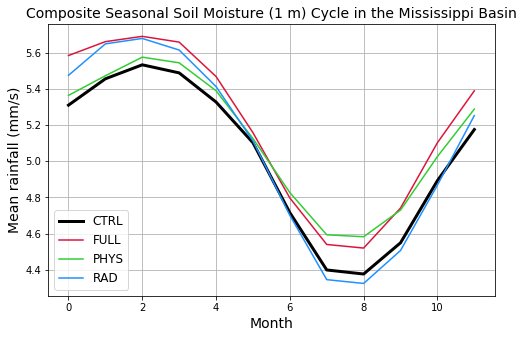

In [18]:
# Look at time series of daily data: 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),avgSoilCtrl,color ='Black',label='CTRL',linewidth=3)
plt.plot(np.arange(12),avgSoilFull,color ='Crimson',label='FULL')
plt.plot(np.arange(12),avgSoilPhys,color = 'LimeGreen',label='PHYS')
plt.plot(np.arange(12),avgSoilRad,color='DodgerBlue',label='RAD')
plt.legend(fontsize=12)
plt.title('Composite Seasonal Soil Moisture (1 m) Cycle in the '+basinNames[basinChoice-1]+ ' Basin',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean rainfall (mm/s)',fontsize=my_fontsize)
plt.grid()


### Is there a better way to look at the driver of temporal changes? 
* What about seasonal composite maps for each month of MAMJJ of runoff, to start (suggestion from Mike) 

In [11]:
#Split into 30 years of monthly data for CESM Variables
annRunoffCtrl = np.array(np.split(basinRunoffCtrl,30,axis=0))
annRunoffFull = np.array(np.split(basinRunoffFull,30,axis=0))
annRunoffPhys = np.array(np.split(basinRunoffPhys,30,axis=0))
annRunoffRad  = np.array(np.split(basinRunoffRad,30,axis=0))

annRainCtrl = np.array(np.split(basinRainCtrl,30,axis=0))
annRainFull = np.array(np.split(basinRainFull,30,axis=0))
annRainPhys = np.array(np.split(basinRainPhys,30,axis=0))
annRainRad  = np.array(np.split(basinRainRad,30,axis=0))

annMeltCtrl = np.array(np.split(basinMeltCtrl,30,axis=0))
annMeltFull = np.array(np.split(basinMeltFull,30,axis=0))
annMeltPhys = np.array(np.split(basinMeltPhys,30,axis=0))
annMeltRad  = np.array(np.split(basinMeltRad,30,axis=0))

annSoilCtrl = np.array(np.split(basinSoilCtrl,30,axis=0))
annSoilFull = np.array(np.split(basinSoilFull,30,axis=0))
annSoilPhys = np.array(np.split(basinSoilPhys,30,axis=0))
annSoilRad  = np.array(np.split(basinSoilRad,30,axis=0))

annPrecipCtrl = np.array(np.split(basinPrecipCtrl,30,axis=0))
annPrecipFull = np.array(np.split(basinPrecipFull,30,axis=0))
annPrecipPhys = np.array(np.split(basinPrecipPhys,30,axis=0))
annPrecipRad  = np.array(np.split(basinPrecipRad,30,axis=0))


In [8]:
np.shape(np.array(annRunoffCtrl)[:,2,:,:])

(30, 192, 288)

In [5]:
#Fix for when pcolor mesh leads to data falling off the continent 
#   Code from Baird Langenbrunner

# extend longitude by 2
lon_extend = np.zeros(cesmLon.size+2)
lon_extend[1:-1] = cesmLon
lon_extend[0] = cesmLon[0]-np.diff(cesmLon)[0]
lon_extend[-1] = cesmLon[-1]+np.diff(cesmLon)[-1]
# calculate the midpoints of this extended version
lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

# extend latitude by 2
lat_extend = np.zeros(cesmLat.size+2)
lat_extend[1:-1] = cesmLat
lat_extend[0] = cesmLat[0]-np.diff(cesmLat)[0]
lat_extend[-1] = cesmLat[-1]+np.diff(cesmLat)[-1]
# calculate the midpoints of this extended version
lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))


In [218]:
# ## See about putting everything inside one big for-loop 
# monName   = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# optArray  = ['CTRL','PHYS','RAD']
# varArray  = ['Runoff','1m Soil Moisture','Precipitation (snow+rain)','Runoff:Precipitation Fraction','1m Soil Moisture Difference','Precipitation Difference']
# monStart  = 8
# monEnd    = 12
# nMon      = monEnd-monStart 

# for loopMon in range(nMon+1):
#     iMon = (monStart-1)+loopMon
    
#     for loopOpt in range(3):
#         opt = optArray[loopOpt]

#         #Define averages for given cases to be used in plotting 
#         if opt=='CTRL':
#             avgRunoff = np.nanmean(annRunoffCtrl[:,iMon,:,:],axis=0)   #Avg runoff
#             avgPrecip = np.nanmean(annPrecipCtrl[:,iMon,:,:],axis=0)   #Avg precip
#             avgRain   = np.nanmean(annRainCtrl[:,iMon,:,:],axis=0)     #Avg rain only 
#             avgSoil   = np.nanmean(annSoilCtrl[:,iMon,:,:],axis=0)     #Avg 1m soil moisture
#             #Avg runoff fraction of precip
#             runoffFraction = annRunoffCtrl[:,iMon,:,:]/(annPrecipCtrl[:,iMon,:,:]*1000) #Convert precipitation from m/s to mm/s
#             avgFraction = np.nanmean(runoffFraction,axis=0)
#         elif opt=='PHYS':
#             avgRunoff = np.nanmean(annRunoffPhys[:,iMon,:,:],axis=0)   #Avg runoff
#             avgPrecip = np.nanmean(annPrecipPhys[:,iMon,:,:],axis=0)   #Avg precip
#             avgRain   = np.nanmean(annRainPhys[:,iMon,:,:],axis=0)     #Avg rain only 
#             avgSoil   = np.nanmean(annSoilPhys[:,iMon,:,:],axis=0)     #Avg 1m soil moisture
#             diffSoil  = np.nanmean((annSoilPhys[:,iMon,:,:]-annSoilCtrl[:,iMon,:,:]),axis=0)
#             seDiffSoil = np.nanstd((annSoilPhys[:,iMon,:,:]-annSoilCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
#             diffPrecip = np.nanmean((annPrecipPhys[:,iMon,:,:]-annPrecipCtrl[:,iMon,:,:]),axis=0)
#             seDiffPrecip = np.nanstd((annPrecipPhys[:,iMon,:,:]-annPrecipCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
#             #Avg runoff fraction of precip
#             runoffFraction = annRunoffPhys[:,iMon,:,:]/(annPrecipPhys[:,iMon,:,:]*1000) #Convert precipitation from m/s to mm/s
#             avgFraction = np.nanmean(runoffFraction,axis=0)    
#         elif opt=='RAD': 
#             avgRunoff = np.nanmean(annRunoffRad[:,iMon,:,:],axis=0)   #Avg runoff
#             avgPrecip = np.nanmean(annPrecipRad[:,iMon,:,:],axis=0)   #Avg precip
#             avgRain   = np.nanmean(annRainRad[:,iMon,:,:],axis=0)     #Avg rain only 
#             avgSoil   = np.nanmean(annSoilRad[:,iMon,:,:],axis=0)     #Avg 1m soil moisture
#             diffSoil = np.nanmean((annSoilRad[:,iMon,:,:]-annSoilCtrl[:,iMon,:,:]),axis=0)
#             seDiffSoil = np.nanstd((annSoilRad[:,iMon,:,:]-annSoilCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
#             diffPrecip = np.nanmean((annPrecipRad[:,iMon,:,:]-annPrecipCtrl[:,iMon,:,:]),axis=0)
#             seDiffPrecip = np.nanstd((annPrecipRad[:,iMon,:,:]-annPrecipCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
#             #Avg runoff fraction of precip
#             runoffFraction = annRunoffRad[:,iMon,:,:]/(annPrecipRad[:,iMon,:,:]*1000) #Convert precipitation from m/s to mm/s
#             avgFraction = np.nanmean(runoffFraction,axis=0)    
                
#         #Loop over all variables to start making plots 
#         for loopVar in range(len(varArray)):
#             #-- START PLOTTING --
#             fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
#             ## --- Set axes and color sections --- 
#             ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#             #ax.set_extent([-120,-70,20,55], crs=ccrs.PlateCarree())   ## NOTE: this is centered on US for the Mississippi
#             #ax.set_extent([-20,25,-10,30], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Niger River 
#             #ax.set_extent([-90,-20,-50,-10], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Parana River 
#             #ax.set_extent([10,70,25,75], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Volga River 
#             #ax.set_extent([80,130,0,35], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Mekong River 
#             #ax.set_extent([-95,-30,-25,15], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Amazonas River 
#             ax.set_extent([90,150,30,65], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Amur River 
            
#             var = varArray[loopVar]
            
#             #For each variable, create plot and define colorbar label and filename to save fig as
#             if var=='Runoff':
#                 contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRunoff,cmap='YlGnBu',vmin=0,vmax=7e-5,transform=ccrs.PlateCarree())
#                 cbarLabel = 'Runoff (mm/s)'
#             elif var=='1m soil moisture difference' and opt!='CTRL': ## Only valid for PHYS and RAD cases 
#                 contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,diffSoil,cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree())
#                 #Add stippling
#                 for ilon in range(len(cesmLon)): 
#                     for ilat in range(len(cesmLat)):
#                         if np.abs(diffSoil[ilat,ilon])>np.abs(2*seDiffSoil[ilat,ilon]):
#                             ax.plot(cesmLon[ilon]-360,cesmLat[ilat],'k.',markersize=6)  # If lon is > 180 
#                             #ax.plot(cesmLon[ilon],cesmLat[ilat],'k.',markersize=6)  # If lon is < 180 
#                 #Naming options 
#                 cbarLabel = 'Soil moisture difference (kg/m2)'
#             elif var=='Precipitation (snow+rain)':
#                 contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgPrecip,cmap='YlGnBu',vmin=0,vmax=2e-7,transform=ccrs.PlateCarree())
#                 cbarLabel = 'Precipitation (m/s)'
#             elif var=='1m soil moisture':
#                 contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgSoil,cmap='YlGnBu',vmin=0,vmax=500,transform=ccrs.PlateCarree())
#                 cbarLabel = 'Soil moisture (kg/m2)'
#             elif var=='Runoff:Precipitation Fraction':
#                 contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFraction,cmap='YlGnBu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
#                 cbarLabel = 'Average Fraction [runoff/precipitation]'
#             elif var=='Precipitation difference' and opt!='CTRL': ## Only valid for PHYS and RAD cases 
#                 contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,diffPrecip,cmap='seismic',vmin=-.5e-7,vmax=.5e-7,transform=ccrs.PlateCarree())
#                 #Add stippling
#                 for ilon in range(len(cesmLon)): 
#                     for ilat in range(len(cesmLat)):
#                         if np.abs(diffPrecip[ilat,ilon])>np.abs(2*seDiffPrecip[ilat,ilon]):
#                             ax.plot(cesmLon[ilon]-360,cesmLat[ilat],'k.',markersize=6)  # If lon is > 180 
#                             #ax.plot(cesmLon[ilon],cesmLat[ilat],'k.',markersize=6)  # If lon is < 180 
#                 #Naming options 
#                 cbarLabel = 'Precipitation Difference (m/s)'
            
#             #Colorbar options 
#             ax_position = ax.get_position()
#             cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0, ax_position.width, 0.06])
#             cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
#             cbar.set_label(cbarLabel,fontsize=18)
#             cbar.ax.tick_params(labelsize=16)
#             #Other figure options 
#             ax.set_title('Average %s in %s [%s]' %(var, monName[iMon], opt))
#             ax.title.set_fontsize(22)
#             ax.coastlines(linewidth=1,edgecolor='0.45')
#             ax.gridlines()
#             ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')
#             plt.show() 
            
#             #Save the image 
#             fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/'+basinNames[basinChoice-1]+'StreamflwTiming/'+opt+'/'+basinNames[basinChoice-1]+var+opt+'_'+monName[iMon]+'.jpg'
#             fig.savefig(fileName)  #HOW TO SAVE FIGURES 




In [49]:
## Choose month and variable 
monName   = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monChoice = 6 #Choose a month to look at a map of (1-12, will subtract for index later)

#Average over chosen month 
iMon = monChoice-1 

#Set case option 
opt = 'PHYS'

#Define averages for given cases to be used in plotting 
if opt=='CTRL':
    avgRunoff = np.nanmean(annRunoffCtrl[:,iMon,:,:],axis=0)   #Avg runoff
    avgPrecip = np.nanmean(annPrecipCtrl[:,iMon,:,:],axis=0)   #Avg precip
    avgRain   = np.nanmean(annRainCtrl[:,iMon,:,:],axis=0)     #Avg rain only 
    avgSoil   = np.nanmean(annSoilCtrl[:,iMon,:,:],axis=0)     #Avg 1m soil moisture
    #Avg runoff fraction of precip
    runoffFraction = annRunoffCtrl[:,iMon,:,:]/(annPrecipCtrl[:,iMon,:,:]*1000) #Convert precipitation from m/s to mm/s
    avgFraction = np.nanmean(runoffFraction,axis=0)
elif opt=='PHYS':
    avgRunoff = np.nanmean(annRunoffPhys[:,iMon,:,:],axis=0)   #Avg runoff
    avgPrecip = np.nanmean(annPrecipPhys[:,iMon,:,:],axis=0)   #Avg precip
    avgRain   = np.nanmean(annRainPhys[:,iMon,:,:],axis=0)     #Avg rain only 
    avgSoil   = np.nanmean(annSoilPhys[:,iMon,:,:],axis=0)     #Avg 1m soil moisture
    avgMelt   = np.nanmean(annMeltPhys[:,iMon,:,:],axis=0)     #Avg snowmelt
    diffMelt   = np.nanmean((annMeltPhys[:,iMon,:,:]-annMeltCtrl[:,iMon,:,:]),axis=0)
    seDiffMelt = np.nanstd((annMeltPhys[:,iMon,:,:]-annMeltCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
    diffSoil  = np.nanmean((annSoilPhys[:,iMon,:,:]-annSoilCtrl[:,iMon,:,:]),axis=0)
    seDiffSoil = np.nanstd((annSoilPhys[:,iMon,:,:]-annSoilCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
    diffPrecip = np.nanmean((annPrecipPhys[:,iMon,:,:]-annPrecipCtrl[:,iMon,:,:]),axis=0)
    seDiffPrecip = np.nanstd((annPrecipPhys[:,iMon,:,:]-annPrecipCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
    diffRunoff   = np.nanmean((annRunoffPhys[:,iMon,:,:]-annRunoffCtrl[:,iMon,:,:]),axis=0)
    seDiffRunoff = np.nanstd((annRunoffPhys[:,iMon,:,:]-annRunoffCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
    #Avg runoff fraction of precip
    runoffFraction = annRunoffPhys[:,iMon,:,:]/(annPrecipPhys[:,iMon,:,:]*1000) #Convert precipitation from m/s to mm/s
    avgFraction = np.nanmean(runoffFraction,axis=0)    
elif opt=='RAD': 
    avgRunoff = np.nanmean(annRunoffRad[:,iMon,:,:],axis=0)   #Avg runoff
    avgPrecip = np.nanmean(annPrecipRad[:,iMon,:,:],axis=0)   #Avg precip
    avgRain   = np.nanmean(annRainRad[:,iMon,:,:],axis=0)     #Avg rain only 
    avgSoil   = np.nanmean(annSoilRad[:,iMon,:,:],axis=0)     #Avg 1m soil moisture
    diffMelt   = np.nanmean((annMeltRad[:,iMon,:,:]-annMeltCtrl[:,iMon,:,:]),axis=0)
    seDiffMelt = np.nanstd((annMeltRad[:,iMon,:,:]-annMeltCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
    diffSoil = np.nanmean((annSoilRad[:,iMon,:,:]-annSoilCtrl[:,iMon,:,:]),axis=0)
    seDiffSoil = np.nanstd((annSoilRad[:,iMon,:,:]-annSoilCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
    diffPrecip = np.nanmean((annPrecipRad[:,iMon,:,:]-annPrecipCtrl[:,iMon,:,:]),axis=0)
    seDiffPrecip = np.nanstd((annPrecipRad[:,iMon,:,:]-annPrecipCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
    diffRunoff   = np.nanmean((annRunoffRad[:,iMon,:,:]-annRunoffCtrl[:,iMon,:,:]),axis=0)
    seDiffRunoff = np.nanstd((annRunoffRad[:,iMon,:,:]-annRunoffCtrl[:,iMon,:,:]),axis=0)/np.sqrt(30)
    #Avg runoff fraction of precip
    runoffFraction = annRunoffRad[:,iMon,:,:]/(annPrecipRad[:,iMon,:,:]*1000) #Convert precipitation from m/s to mm/s
    avgFraction = np.nanmean(runoffFraction,axis=0)    


#For case of Niger river, need to add cyclic point:
#var_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(avgRunoff, cesmLon) #Adds one more strip of data to the file to be cyclic


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6

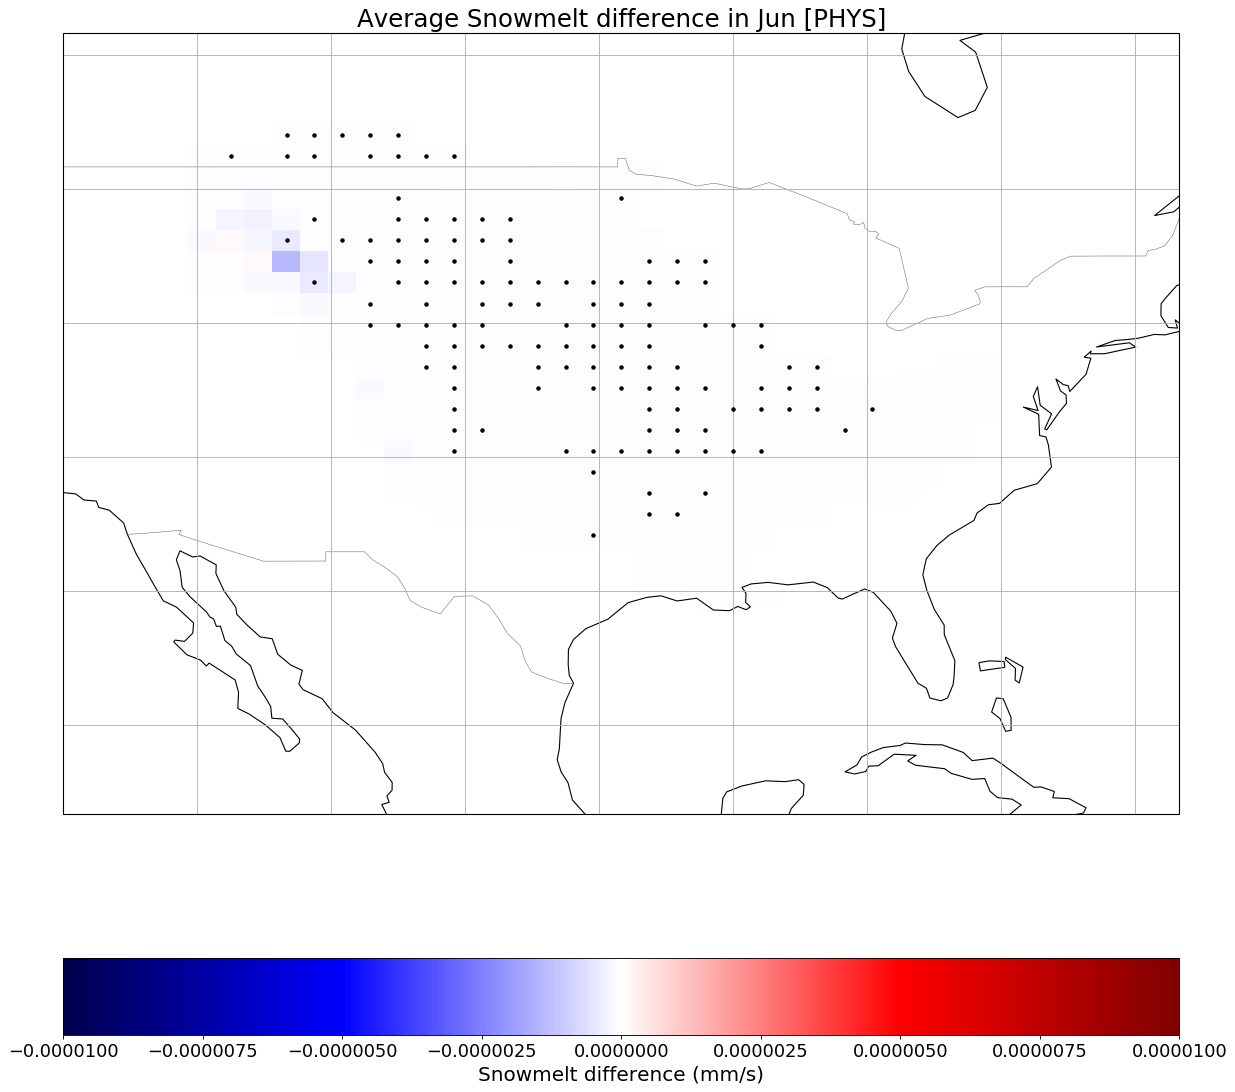

/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/MississippiStreamflwTiming/PHYS/MississippiSnowmeltPHYS_Jun.jpg


In [50]:
## -- Plot map of chosen month's average runoff -- 

#Set basic plot options 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-120,-70,20,55], crs=ccrs.PlateCarree())   ## NOTE: this is centered on US for the Mississippi
#ax.set_extent([-20,25,-10,30], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Niger River 
#ax.set_extent([-90,-20,-50,-10], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Parana River 
#ax.set_extent([10,70,25,75], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Volga River 
#ax.set_extent([80,130,0,35], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Mekong River 
#ax.set_extent([-95,-30,-25,15], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Amazonas River 
#ax.set_extent([90,150,30,65], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Amur River 
#ax.set_extent([55,115,10,40], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Ganges River 
#ax.set_extent([5,35,30,65], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Danube River 
#ax.set_extent([-10,45,-20,20], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Congo River 
#ax.set_extent([0,60,-15,45], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Nile River 

## --- Create Plot ---

#Allow for different variable options 
var = 'Snowmelt difference'

#For each variable, create plot and define colorbar label and filename to save fig as
if var=='Runoff':
    contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRunoff,cmap='YlGnBu',vmin=0,vmax=3e-5,transform=ccrs.PlateCarree())
    cbarLabel = 'Runoff (mm/s)'
    fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/NigerStreamflwTiming/'+opt+'/NigerRunoff'+opt+'_'+monName[iMon]+'.jpg'

elif var=='Snowmelt difference':
    contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,diffMelt,cmap='seismic',vmin=-10e-6,vmax=10e-6,transform=ccrs.PlateCarree())
    #Add stippling
    for ilon in range(len(cesmLon)): 
        for ilat in range(len(cesmLat)):
            if np.abs(diffMelt[ilat,ilon])>np.abs(2*seDiffMelt[ilat,ilon]):
                ax.plot(cesmLon[ilon]-360,cesmLat[ilat],'k.',markersize=6)  # If lon is > 180 
                #ax.plot(cesmLon[ilon],cesmLat[ilat],'k.',markersize=6)  # If lon is < 180 
    #Naming options 
    cbarLabel = 'Snowmelt difference (mm/s)'
    fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/MississippiStreamflwTiming/'+opt+'/MississippiSnowmelt'+opt+'_'+monName[iMon]+'.jpg'


elif var=='Runoff difference':
    contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,diffRunoff,cmap='seismic',vmin=-1.5e-5,vmax=1.5e-5,transform=ccrs.PlateCarree())
    #Add stippling
    for ilon in range(len(cesmLon)): 
        for ilat in range(len(cesmLat)):
            if np.abs(diffRunoff[ilat,ilon])>np.abs(2*seDiffRunoff[ilat,ilon]):
                ax.plot(cesmLon[ilon]-360,cesmLat[ilat],'k.',markersize=6)  # If lon is > 180 
                #ax.plot(cesmLon[ilon],cesmLat[ilat],'k.',markersize=6)  # If lon is < 180 
    #Naming options 
    cbarLabel = 'Runoff difference (mm/s)'
    fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/ParanaStreamflwTiming/'+opt+'/ParanaRunoffDiff'+opt+'_'+monName[iMon]+'.jpg'
elif var=='1m soil moisture difference': ## Only valid for PHYS and RAD cases 
    contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,diffSoil,cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree())
    #Add stippling
    for ilon in range(len(cesmLon)): 
        for ilat in range(len(cesmLat)):
            if np.abs(diffSoil[ilat,ilon])>np.abs(2*seDiffSoil[ilat,ilon]):
                ax.plot(cesmLon[ilon]-360,cesmLat[ilat],'k.',markersize=6)  # If lon is > 180 
                #ax.plot(cesmLon[ilon],cesmLat[ilat],'k.',markersize=6)  # If lon is < 180 
    #Naming options 
    cbarLabel = 'Soil moisture difference (kg/m2)'
    fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/NigerStreamflwTiming/'+opt+'/NigerSoilDiff'+opt+'_'+monName[iMon]+'.jpg'
elif var=='Precipitation (snow+rain)':
    contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgPrecip,cmap='YlGnBu',vmin=0,vmax=1e-7,transform=ccrs.PlateCarree())
    cbarLabel = 'Precipitation (m/s)'
    fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/NigerStreamflwTiming/'+opt+'/NigerPrecip'+opt+'_'+monName[iMon]+'.jpg'
elif var=='Rainfall':
    contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRain,cmap='YlGnBu',vmin=0,vmax=3e-4,transform=ccrs.PlateCarree())
    cbarLabel = 'Rainfall (mm/s)'
    fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/NigerStreamflwTiming/'+opt+'/NigerRain'+opt+'_'+monName[iMon]+'.jpg'
elif var=='1m soil moisture':
    contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgSoil,cmap='YlGnBu',vmin=0,vmax=300,transform=ccrs.PlateCarree())
    cbarLabel = 'Soil moisture (kg/m2)'
    fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/NigerStreamflwTiming/'+opt+'/NigerSoilMoisture'+opt+'_'+monName[iMon]+'.jpg'  
elif var=='Runoff:Precipitation Fraction':
    contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFraction,cmap='YlGnBu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
    cbarLabel = 'Average Fraction [runoff/precipitation]'
    fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/NigerStreamflwTiming/'+opt+'/NigerFraction'+opt+'_'+monName[iMon]+'.jpg'
elif var=='Precipitation difference': ## Only valid for PHYS and RAD cases 
    contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,diffPrecip,cmap='seismic',vmin=-.5e-7,vmax=.5e-7,transform=ccrs.PlateCarree())
    #Add stippling
    for ilon in range(len(cesmLon)): 
        for ilat in range(len(cesmLat)):
            if np.abs(diffPrecip[ilat,ilon])>np.abs(2*seDiffPrecip[ilat,ilon]):
                ax.plot(cesmLon[ilon]-360,cesmLat[ilat],'k.',markersize=6)  # If lon is > 180 
                #ax.plot(cesmLon[ilon],cesmLat[ilat],'k.',markersize=6)  # If lon is < 180 
    #Naming options 
    cbarLabel = 'Precipitation Difference (m/s)'
    fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/NigerStreamflwTiming/'+opt+'/NigerPrecipDiff'+opt+'_'+monName[iMon]+'.jpg'

#For above options, added _contour to end of filename and changed pcolormesh plot to contourf 
    
#Colorbar options 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(cbarLabel,fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Average %s in %s [%s]' %(var, monName[iMon], opt))
ax.title.set_fontsize(22)
ax.coastlines(linewidth=1,edgecolor='0.45')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')
plt.show() 

#Save the image 
fig.savefig(fileName)  #HOW TO SAVE FIGURES 
print(fileName)


## Global maps of changes in CESM variables

In [49]:
# Compute differences and average over time 
# diffFullLai  = ((fullLAI.values-ctrlLAI.values)/ctrlLAI.values)*100
# diffPhysLai  = ((physLAI.values-ctrlLAI.values)/ctrlLAI.values)*100
# diffRadLai   = ((radLAI.values-ctrlLAI.values)/ctrlLAI.values)*100
# avgFullLai   = np.nanmean(diffFullLai,axis=0)
# avgPhysLai   = np.nanmean(diffPhysLai,axis=0)
# avgRadLai    = np.nanmean(diffRadLai,axis=0)

diffFullSoil = ((fullSoil_1m-ctrlSoil_1m)/ctrlSoil_1m)*100
diffPhysSoil = ((physSoil_1m-ctrlSoil_1m)/ctrlSoil_1m)*100
diffRadSoil  = ((radSoil_1m-ctrlSoil_1m)/ctrlSoil_1m)*100
avgFullSoil  = np.nanmean(diffFullSoil,axis=0)
avgPhysSoil  = np.nanmean(diffPhysSoil,axis=0)
avgRadSoil   = np.nanmean(diffRadSoil,axis=0)

# # diffFullRun  = ((fullRunoff.values-ctrlRunoff.values)/ctrlRunoff.values)*100
# # diffPhysRun  = ((physRunoff.values-ctrlRunoff.values)/ctrlRunoff.values)*100
# # diffRadRun   = ((radRunoff.values-ctrlRunoff.values)/ctrlRunoff.values)*100
# # avgFullRun   = np.nanmean(diffFullRun,axis=0)
# # avgPhysRun   = np.nanmean(diffPhysRun,axis=0)
# # avgRadRun    = np.nanmean(diffRadRun,axis=0)

diffFullPrec = ((fullPrecip.values-ctrlPrecip.values)/ctrlPrecip.values)*100
diffPhysPrec = ((physPrecip.values-ctrlPrecip.values)/ctrlPrecip.values)*100
diffRadPrec  = ((radPrecip.values-ctrlPrecip.values)/ctrlPrecip.values)*100
avgFullPrec  = np.nanmean(diffFullPrec,axis=0)
avgPhysPrec  = np.nanmean(diffPhysPrec,axis=0)
avgRadPrec   = np.nanmean(diffRadPrec,axis=0)

diffFullRain = ((fullRain.values-ctrlRain.values)/ctrlRain.values)*100
diffPhysRain = ((physRain.values-ctrlRain.values)/ctrlRain.values)*100
diffRadRain  = ((radRain.values-ctrlRain.values)/ctrlRain.values)*100
avgFullRain  = np.nanmean(diffFullRain,axis=0)
avgPhysRain  = np.nanmean(diffPhysRain,axis=0)
avgRadRain   = np.nanmean(diffRadRain,axis=0)

diffFullMelt = ((fullMelt.values-ctrlMelt.values)/ctrlMelt.values)*100
diffPhysMelt = ((physMelt.values-ctrlMelt.values)/ctrlMelt.values)*100
diffRadMelt  = ((radMelt.values-ctrlMelt.values)/ctrlMelt.values)*100
avgFullMelt  = np.nanmean(diffFullMelt,axis=0)
avgPhysMelt  = np.nanmean(diffPhysMelt,axis=0)
avgRadMelt   = np.nanmean(diffRadMelt,axis=0)

diffFullET   = fullET-ctrlET
diffPhysET   = physET-ctrlET
diffRadET    = radET-ctrlET

# #Decomposition of ET
# diffFullTransp = fullQvegt_avg-ctrlQvegt_avg
# diffPhysTransp = physQvegt_avg-ctrlQvegt_avg
# diffRadTransp  = radQvegt_avg -ctrlQvegt_avg

# diffFullQsoil = fullQsoil_avg-ctrlQsoil_avg
# diffPhysQsoil = physQsoil_avg-ctrlQsoil_avg
# diffRadQsoil  = radQsoil_avg -ctrlQsoil_avg

# diffFullQvege = fullQvege_avg-ctrlQvege_avg
# diffPhysQvege = physQvege_avg-ctrlQvege_avg
# diffRadQvege  = radQvege_avg -ctrlQvege_avg


#Fix for when pcolor mesh leads to data falling off the continent 
#   Code from Baird Langenbrunner
# extend longitude by 2
lon_extend = np.zeros(cesmLon.size+2)
lon_extend[1:-1] = cesmLon
lon_extend[0] = cesmLon[0]-np.diff(cesmLon)[0]
lon_extend[-1] = cesmLon[-1]+np.diff(cesmLon)[-1]
# calculate the midpoints of this extended version
lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))
# extend latitude by 2
lat_extend = np.zeros(cesmLat.size+2)
lat_extend[1:-1] = cesmLat
lat_extend[0] = cesmLat[0]-np.diff(cesmLat)[0]
lat_extend[-1] = cesmLat[-1]+np.diff(cesmLat)[-1]
# calculate the midpoints of this extended version
lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))




/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/meganfowler/anaconda3/lib/pytho

In [8]:
# -- Also look at change in annual peak snowmelt -- #
ctrlAnnMelt = np.split(ctrlMelt.values,30,axis=0)
fullAnnMelt = np.split(fullMelt.values,30,axis=0)
physAnnMelt = np.split(physMelt.values,30,axis=0)
radAnnMelt  = np.split(radMelt.values,30,axis=0)
print(np.shape(ctrlAnnMelt))

maxMeltCtrl = np.nanmax(ctrlAnnMelt,axis=1)
maxMeltFull = np.nanmax(fullAnnMelt,axis=1)
maxMeltPhys = np.nanmax(physAnnMelt,axis=1)
maxMeltRad  = np.nanmax(radAnnMelt,axis=1)
print(np.shape(maxMeltCtrl))

minMeltCtrl = np.nanmin(ctrlAnnMelt,axis=1)
minMeltFull = np.nanmin(fullAnnMelt,axis=1)
minMeltPhys = np.nanmin(physAnnMelt,axis=1)
minMeltRad  = np.nanmin(radAnnMelt,axis=1)

#Take difference and then the mean of that difference 
diffFullMaxMelt = ((maxMeltFull-maxMeltCtrl)/maxMeltCtrl)*100
diffPhysMaxMelt = ((maxMeltPhys-maxMeltCtrl)/maxMeltCtrl)*100
diffRadMaxMelt  = ((maxMeltRad-maxMeltCtrl)/maxMeltCtrl)*100
avgFullMaxMelt  = np.nanmean(diffFullMaxMelt,axis=0)
avgPhysMaxMelt  = np.nanmean(diffPhysMaxMelt,axis=0)
avgRadMaxMelt   = np.nanmean(diffRadMaxMelt,axis=0)

diffFullMinMelt = ((minMeltFull-minMeltCtrl)/minMeltCtrl)*100
diffPhysMinMelt = ((minMeltPhys-minMeltCtrl)/minMeltCtrl)*100
diffRadMinMelt  = ((minMeltRad-minMeltCtrl)/minMeltCtrl)*100
avgFullMinMelt  = np.nanmean(diffFullMinMelt,axis=0)
avgPhysMinMelt  = np.nanmean(diffPhysMinMelt,axis=0)
avgRadMinMelt   = np.nanmean(diffRadMinMelt,axis=0)

# -- We can also look at seasonal changes in snowmelt -- # 
ctrlMelt_DJF = np.asarray(ctrlAnnMelt)[:,[11,0,1],:,:]
ctrlMelt_MAM = np.asarray(ctrlAnnMelt)[:,[2,3,4],:,:]
ctrlMelt_JJA = np.asarray(ctrlAnnMelt)[:,[5,6,7],:,:]
ctrlMelt_SON = np.asarray(ctrlAnnMelt)[:,[8,9,10],:,:]
ctrlMeanMelt_DJF = np.nanmean(ctrlMelt_DJF,axis=1)
ctrlMeanMelt_MAM = np.nanmean(ctrlMelt_MAM,axis=1)
ctrlMeanMelt_JJA = np.nanmean(ctrlMelt_JJA,axis=1)
ctrlMeanMelt_SON = np.nanmean(ctrlMelt_SON,axis=1)

fullMelt_DJF = np.asarray(fullAnnMelt)[:,[11,0,1],:,:]
fullMelt_MAM = np.asarray(fullAnnMelt)[:,[2,3,4],:,:]
fullMelt_JJA = np.asarray(fullAnnMelt)[:,[5,6,7],:,:]
fullMelt_SON = np.asarray(fullAnnMelt)[:,[8,9,10],:,:]
fullMeanMelt_DJF = np.nanmean(fullMelt_DJF,axis=1)
fullMeanMelt_MAM = np.nanmean(fullMelt_MAM,axis=1)
fullMeanMelt_JJA = np.nanmean(fullMelt_JJA,axis=1)
fullMeanMelt_SON = np.nanmean(fullMelt_SON,axis=1)

physMelt_DJF = np.asarray(physAnnMelt)[:,[11,0,1],:,:]
physMelt_MAM = np.asarray(physAnnMelt)[:,[2,3,4],:,:]
physMelt_JJA = np.asarray(physAnnMelt)[:,[5,6,7],:,:]
physMeanMelt_DJF = np.nanmean(physMelt_DJF,axis=1)
physMeanMelt_MAM = np.nanmean(physMelt_MAM,axis=1)
physMeanMelt_JJA = np.nanmean(physMelt_JJA,axis=1)

radMelt_DJF = np.asarray(radAnnMelt)[:,[11,0,1],:,:]
radMelt_MAM = np.asarray(radAnnMelt)[:,[2,3,4],:,:]
radMelt_JJA = np.asarray(radAnnMelt)[:,[5,6,7],:,:]
radMeanMelt_DJF = np.nanmean(radMelt_DJF,axis=1)
radMeanMelt_MAM = np.nanmean(radMelt_MAM,axis=1)
radMeanMelt_JJA = np.nanmean(radMelt_JJA,axis=1)

diffFullDJF = ((fullMeanMelt_DJF-ctrlMeanMelt_DJF)/ctrlMeanMelt_DJF)*100
diffFullMAM = ((fullMeanMelt_MAM-ctrlMeanMelt_MAM)/ctrlMeanMelt_MAM)*100
diffFullJJA = ((fullMeanMelt_JJA-ctrlMeanMelt_JJA)/ctrlMeanMelt_JJA)*100
diffFullSON = ((fullMeanMelt_SON-ctrlMeanMelt_SON)/ctrlMeanMelt_SON)*100
avgFullMelt_DJF = np.nanmean(diffFullDJF,axis=0)
avgFullMelt_MAM = np.nanmean(diffFullMAM,axis=0)
avgFullMelt_JJA = np.nanmean(diffFullJJA,axis=0)
avgFullMelt_SON = np.nanmean(diffFullSON,axis=0)

diffPhysDJF = ((physMeanMelt_DJF-ctrlMeanMelt_DJF)/ctrlMeanMelt_DJF)*100
diffPhysMAM = ((physMeanMelt_MAM-ctrlMeanMelt_MAM)/ctrlMeanMelt_MAM)*100
diffPhysJJA = ((physMeanMelt_JJA-ctrlMeanMelt_JJA)/ctrlMeanMelt_JJA)*100
avgPhysMelt_DJF = np.nanmean(diffPhysDJF,axis=0)
avgPhysMelt_MAM = np.nanmean(diffPhysMAM,axis=0)
avgPhysMelt_JJA = np.nanmean(diffPhysJJA,axis=0)

diffRadDJF = ((radMeanMelt_DJF-ctrlMeanMelt_DJF)/ctrlMeanMelt_DJF)*100
diffRadMAM = ((radMeanMelt_MAM-ctrlMeanMelt_MAM)/ctrlMeanMelt_MAM)*100
diffRadJJA = ((radMeanMelt_JJA-ctrlMeanMelt_JJA)/ctrlMeanMelt_JJA)*100
avgRadMelt_DJF = np.nanmean(diffRadDJF,axis=0)
avgRadMelt_MAM = np.nanmean(diffRadMAM,axis=0)
avgRadMelt_JJA = np.nanmean(diffRadJJA,axis=0)


RuntimeError: Input/output error

In [8]:
## Let's actually use the seasonal split up to look at a few others too.. ## 

# - Change in precipitation - #
ctrlAnnPrecip = np.split(ctrlPrecip.values,30,axis=0)
fullAnnPrecip = np.split(fullPrecip.values,30,axis=0)
# physAnnPrecip = np.split(physPrecip.values,30,axis=0)
# radAnnPrecip  = np.split(radPrecip.values,30,axis=0)

ctrlPrecip_DJF = np.asarray(ctrlAnnPrecip)[:,[11,0,1],:,:]
ctrlPrecip_MAM = np.asarray(ctrlAnnPrecip)[:,[2,3,4],:,:]
ctrlPrecip_JJA = np.asarray(ctrlAnnPrecip)[:,[5,6,7],:,:]
ctrlPrecip_SON = np.asarray(ctrlAnnPrecip)[:,[8,9,10],:,:]
ctrlMeanPrecip_DJF = np.nanmean(ctrlPrecip_DJF,axis=1)
ctrlMeanPrecip_MAM = np.nanmean(ctrlPrecip_MAM,axis=1)
ctrlMeanPrecip_JJA = np.nanmean(ctrlPrecip_JJA,axis=1)
ctrlMeanPrecip_SON = np.nanmean(ctrlPrecip_SON,axis=1)

fullPrecip_DJF = np.asarray(fullAnnPrecip)[:,[11,0,1],:,:]
fullPrecip_MAM = np.asarray(fullAnnPrecip)[:,[2,3,4],:,:]
fullPrecip_JJA = np.asarray(fullAnnPrecip)[:,[5,6,7],:,:]
fullPrecip_SON = np.asarray(fullAnnPrecip)[:,[8,9,10],:,:]
fullMeanPrecip_DJF = np.nanmean(fullPrecip_DJF,axis=1)
fullMeanPrecip_MAM = np.nanmean(fullPrecip_MAM,axis=1)
fullMeanPrecip_JJA = np.nanmean(fullPrecip_JJA,axis=1)
fullMeanPrecip_SON = np.nanmean(fullPrecip_SON,axis=1)

diffFullPrecip_DJF = ((fullMeanPrecip_DJF-ctrlMeanPrecip_DJF)/ctrlMeanPrecip_DJF)*100
diffFullPrecip_MAM = ((fullMeanPrecip_MAM-ctrlMeanPrecip_MAM)/ctrlMeanPrecip_MAM)*100
diffFullPrecip_JJA = ((fullMeanPrecip_JJA-ctrlMeanPrecip_JJA)/ctrlMeanPrecip_JJA)*100
diffFullPrecip_SON = ((fullMeanPrecip_SON-ctrlMeanPrecip_SON)/ctrlMeanPrecip_SON)*100
avgFullPrecip_DJF = np.nanmean(diffFullPrecip_DJF,axis=0)
avgFullPrecip_MAM = np.nanmean(diffFullPrecip_MAM,axis=0)
avgFullPrecip_JJA = np.nanmean(diffFullPrecip_JJA,axis=0)
avgFullPrecip_SON = np.nanmean(diffFullPrecip_SON,axis=0)


# - Change in fraction of precip that falls as rain - # 
ctrlAnnRain = np.split(ctrlRain.values,30,axis=0)
fullAnnRain = np.split(fullRain.values,30,axis=0)
# physAnnRain = np.split(physRain.values,30,axis=0)
# radAnnRain  = np.split(radRain.values,30,axis=0)

#Rain fraction
ctrlRainFrac = np.asarray(ctrlAnnRain)/np.asarray(ctrlAnnPrecip) 
fullRainFrac = np.asarray(fullAnnRain)/np.asarray(fullAnnPrecip)
# physRainFrac = physAnnRain/physAnnPrecip
# radRainFrac  = radAnnRain/radAnnPrecip

ctrlRainFrac_DJF = np.asarray(ctrlRainFrac)[:,[11,0,1],:,:]
ctrlRainFrac_MAM = np.asarray(ctrlRainFrac)[:,[2,3,4],:,:]
ctrlRainFrac_JJA = np.asarray(ctrlRainFrac)[:,[5,6,7],:,:]
ctrlRainFrac_SON = np.asarray(ctrlRainFrac)[:,[8,9,10],:,:]
ctrlMeanRainFrac_DJF = np.nanmean(ctrlRainFrac_DJF,axis=1)
ctrlMeanRainFrac_MAM = np.nanmean(ctrlRainFrac_MAM,axis=1)
ctrlMeanRainFrac_JJA = np.nanmean(ctrlRainFrac_JJA,axis=1)
ctrlMeanRainFrac_SON = np.nanmean(ctrlRainFrac_SON,axis=1)

fullRainFrac_DJF = np.asarray(fullRainFrac)[:,[11,0,1],:,:]
fullRainFrac_MAM = np.asarray(fullRainFrac)[:,[2,3,4],:,:]
fullRainFrac_JJA = np.asarray(fullRainFrac)[:,[5,6,7],:,:]
fullRainFrac_SON = np.asarray(fullRainFrac)[:,[8,9,10],:,:]
fullMeanRainFrac_DJF = np.nanmean(fullRainFrac_DJF,axis=1)
fullMeanRainFrac_MAM = np.nanmean(fullRainFrac_MAM,axis=1)
fullMeanRainFrac_JJA = np.nanmean(fullRainFrac_JJA,axis=1)
fullMeanRainFrac_SON = np.nanmean(fullRainFrac_SON,axis=1)

diffFullRainFrac_DJF = ((fullMeanRainFrac_DJF-ctrlMeanRainFrac_DJF)/ctrlMeanRainFrac_DJF)*100
diffFullRainFrac_MAM = ((fullMeanRainFrac_MAM-ctrlMeanRainFrac_MAM)/ctrlMeanRainFrac_MAM)*100
diffFullRainFrac_JJA = ((fullMeanRainFrac_JJA-ctrlMeanRainFrac_JJA)/ctrlMeanRainFrac_JJA)*100
diffFullRainFrac_SON = ((fullMeanRainFrac_SON-ctrlMeanRainFrac_SON)/ctrlMeanRainFrac_SON)*100
avgFullRainFrac_DJF = np.nanmean(diffFullRainFrac_DJF,axis=0)
avgFullRainFrac_MAM = np.nanmean(diffFullRainFrac_MAM,axis=0)
avgFullRainFrac_JJA = np.nanmean(diffFullRainFrac_JJA,axis=0)
avgFullRainFrac_SON = np.nanmean(diffFullRainFrac_SON,axis=0)


# - Change in soil moisture - # 
ctrlAnnSoil = np.split(ctrlSoil_1m,30,axis=0)
fullAnnSoil = np.split(fullSoil_1m,30,axis=0)

ctrlSoil_DJF = np.asarray(ctrlAnnSoil)[:,[11,0,1],:,:]
ctrlSoil_MAM = np.asarray(ctrlAnnSoil)[:,[2,3,4],:,:]
ctrlSoil_JJA = np.asarray(ctrlAnnSoil)[:,[5,6,7],:,:]
ctrlSoil_SON = np.asarray(ctrlAnnSoil)[:,[8,9,10],:,:]
ctrlMeanSoil_DJF = np.nanmean(ctrlSoil_DJF,axis=1)
ctrlMeanSoil_MAM = np.nanmean(ctrlSoil_MAM,axis=1)
ctrlMeanSoil_JJA = np.nanmean(ctrlSoil_JJA,axis=1)
ctrlMeanSoil_SON = np.nanmean(ctrlSoil_SON,axis=1)

fullSoil_DJF = np.asarray(fullAnnSoil)[:,[11,0,1],:,:]
fullSoil_MAM = np.asarray(fullAnnSoil)[:,[2,3,4],:,:]
fullSoil_JJA = np.asarray(fullAnnSoil)[:,[5,6,7],:,:]
fullSoil_SON = np.asarray(fullAnnSoil)[:,[8,9,10],:,:]
fullMeanSoil_DJF = np.nanmean(fullSoil_DJF,axis=1)
fullMeanSoil_MAM = np.nanmean(fullSoil_MAM,axis=1)
fullMeanSoil_JJA = np.nanmean(fullSoil_JJA,axis=1)
fullMeanSoil_SON = np.nanmean(fullSoil_SON,axis=1)

diffFullSoil_DJF = ((fullMeanSoil_DJF-ctrlMeanSoil_DJF)/ctrlMeanSoil_DJF)*100
diffFullSoil_MAM = ((fullMeanSoil_MAM-ctrlMeanSoil_MAM)/ctrlMeanSoil_MAM)*100
diffFullSoil_JJA = ((fullMeanSoil_JJA-ctrlMeanSoil_JJA)/ctrlMeanSoil_JJA)*100
diffFullSoil_SON = ((fullMeanSoil_SON-ctrlMeanSoil_SON)/ctrlMeanSoil_SON)*100
avgFullSoil_DJF = np.nanmean(diffFullSoil_DJF,axis=0)
avgFullSoil_MAM = np.nanmean(diffFullSoil_MAM,axis=0)
avgFullSoil_JJA = np.nanmean(diffFullSoil_JJA,axis=0)
avgFullSoil_SON = np.nanmean(diffFullSoil_SON,axis=0)



/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeW

In [10]:
landMask = np.full([len(cesmLat),len(cesmLon)],np.nan)

for ilon in range(len(cesmLon)):
    for ilat in range(len(cesmLat)): 
        if np.isnan(ctrlLAI[0,ilat,ilon])==True: 
        #if np.isnan(avgFullRun[ilat,ilon])==True: 
            landMask[ilat,ilon] = np.nan
        else: 
            landMask[ilat,ilon] = 1


NameError: name 'ctrlLAI' is not defined

## Figures for supplement of manuscript

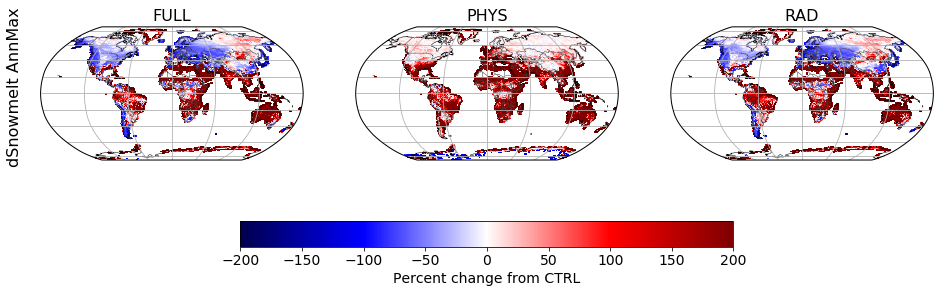

In [11]:
## Change in max or min annual snow melt 

## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullMaxMelt,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Other figure options 
ax1.set_title('FULL',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax1.text(-0.07, 0.55, 'dSnowmelt AnnMax', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes,fontsize=16)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgPhysMaxMelt,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0+0.2, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.set_title('PHYS',fontsize=16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRadMaxMelt,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Other figure options 
ax3.set_title('RAD',fontsize=16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


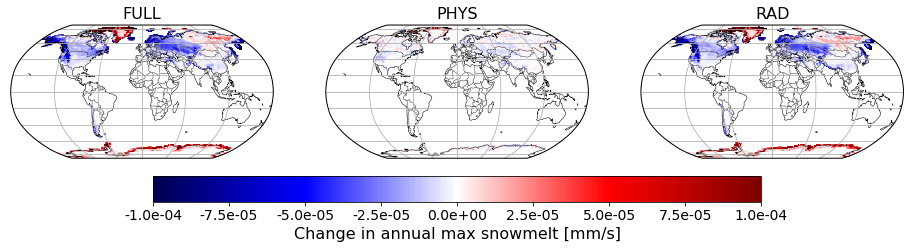

In [23]:
# --- Plot absolute change in max snowmelt --- #

## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((maxMeltFull-maxMeltCtrl),axis=0),cmap='seismic',vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
#Other figure options 
ax1.set_title('FULL',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
# ax1.text(-0.07, 0.55, 'dSnowmelt AnnMax', va='bottom', ha='center',
#         rotation='vertical', rotation_mode='anchor',
#         transform=ax1.transAxes,fontsize=16)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((maxMeltPhys-maxMeltCtrl),axis=0),cmap='seismic',vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0+0.25, ax_position.width+0.3, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,format='%.1e')
cbar.set_label('Change in annual max snowmelt [mm/s]',fontsize=16)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.set_title('PHYS',fontsize=16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((maxMeltRad-maxMeltCtrl),axis=0),cmap='seismic',vmin=-1e-4,vmax=1e-4,transform=ccrs.PlateCarree())
#Other figure options 
ax3.set_title('RAD',fontsize=16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



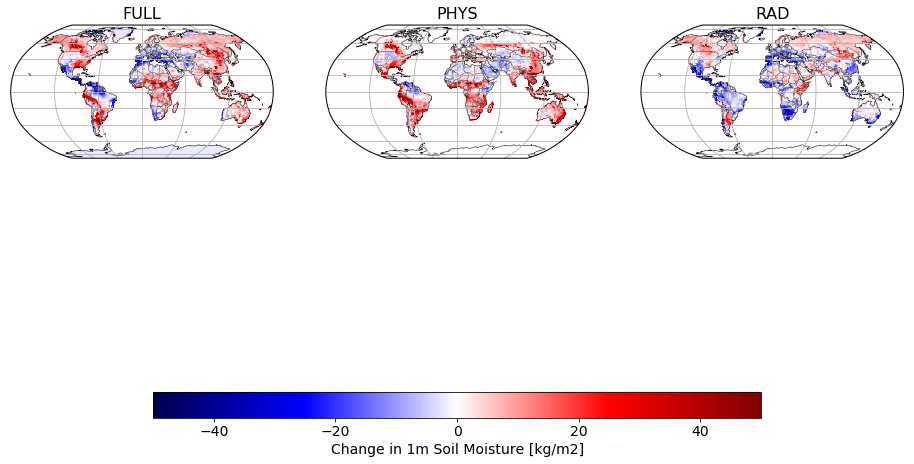

In [73]:
## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)


#
# ---- Set 1: Change in 1m soil moisture ---- #
#
# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((fullSoil_1m-ctrlSoil_1m),axis=0),cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree())
#Other figure options 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.set_title('FULL',fontsize=16)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((physSoil_1m-ctrlSoil_1m),axis=0),cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0, ax_position.width+0.3, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in 1m Soil Moisture [kg/m2]',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax2.set_title('PHYS',fontsize=16)

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((radSoil_1m-ctrlSoil_1m),axis=0),cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree())
#Other figure options 
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax3.set_title('RAD',fontsize=16)

fig.savefig('/Users/meganfowler/Documents/Irvine/Flooding/Physiology/Illustrator/Revisions_Round2/SoilMoistureChanges.pdf',bbox_inches = 'tight')



/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
/Users/meganfowl

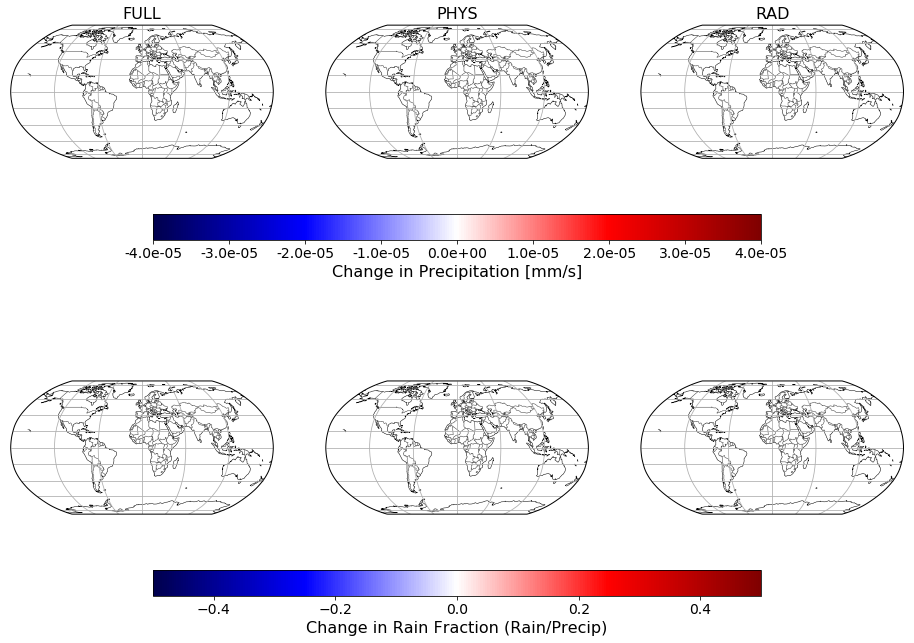

In [55]:
# -- Plot absolute changes in precipitation and rain fraction --- #


## --- Set up figure window --- 
fig, ax_array = plt.subplots(2,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3,ax4,ax5,ax6 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)


#
# ---- Set 1: Change in precip ---- #
#

# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((fullPrecip.values-ctrlPrecip.values),axis=0)*1000*landMask,cmap='seismic',vmin=-4e-5,vmax=4e-5,transform=ccrs.PlateCarree())
#Other figure options 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.set_title('FULL',fontsize=16)
#Add ylabel
# ax1.text(-0.07, 0.55, 'Change in Precip', va='bottom', ha='center',
#         rotation='vertical', rotation_mode='anchor',
#         transform=ax4.transAxes,fontsize=14)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((physPrecip.values-ctrlPrecip.values),axis=0)*1000*landMask,cmap='seismic',vmin=-4e-5,vmax=4e-5,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0, ax_position.width+0.3, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,format='%.1e')
cbar.set_label('Change in Precipitation [mm/s]',fontsize=16)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax2.set_title('PHYS',fontsize=16)

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((radPrecip.values-ctrlPrecip.values),axis=0)*1000*landMask,cmap='seismic',vmin=-4e-5,vmax=4e-5,transform=ccrs.PlateCarree())
#Other figure options 
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax3.set_title('RAD',fontsize=16)

#
# ---- Set 2: Change in rain/precip fraction ---- #
#

# First, define the fraction in each case: 
fractionCtrl = ctrlRain.values/(ctrlPrecip.values*1000)
fractionFull = fullRain.values/(fullPrecip.values*1000)
fractionPhys = physRain.values/(physPrecip.values*1000)
fractionRad  = radRain.values/(radPrecip.values*1000)
#Eliminate places where change is +inf or -inf
fractionCtrl[np.where(np.isinf(fractionCtrl)==True)]=np.nan
fractionFull[np.where(np.isinf(fractionFull)==True)]=np.nan
fractionPhys[np.where(np.isinf(fractionPhys)==True)]=np.nan
fractionRad[np.where(np.isinf(fractionRad)==True)]=np.nan

# FULL #
ax4.set_global()
contour_plot = ax4.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((fractionFull-fractionCtrl),axis=0)*landMask,cmap='seismic',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
#Other figure options 
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
# ax1.text(-0.07, 0.55, 'Change in Precip', va='bottom', ha='center',
#         rotation='vertical', rotation_mode='anchor',
#         transform=ax4.transAxes,fontsize=14)

# PHYS #
ax5.set_global()
contour_plot = ax5.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((fractionPhys-fractionCtrl),axis=0)*landMask,cmap='seismic',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax5.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0, ax_position.width+0.3, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in Rain Fraction (Rain/Precip)',fontsize=16)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax5.coastlines(linewidth=0.5,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax6.set_global()
contour_plot = ax6.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((fractionRad-fractionCtrl),axis=0)*landMask,cmap='seismic',vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
#Other figure options 
ax6.coastlines(linewidth=0.5,edgecolor='0.25')
ax6.gridlines()
ax6.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

fig.subplots_adjust(wspace=0.1, hspace=0.05)


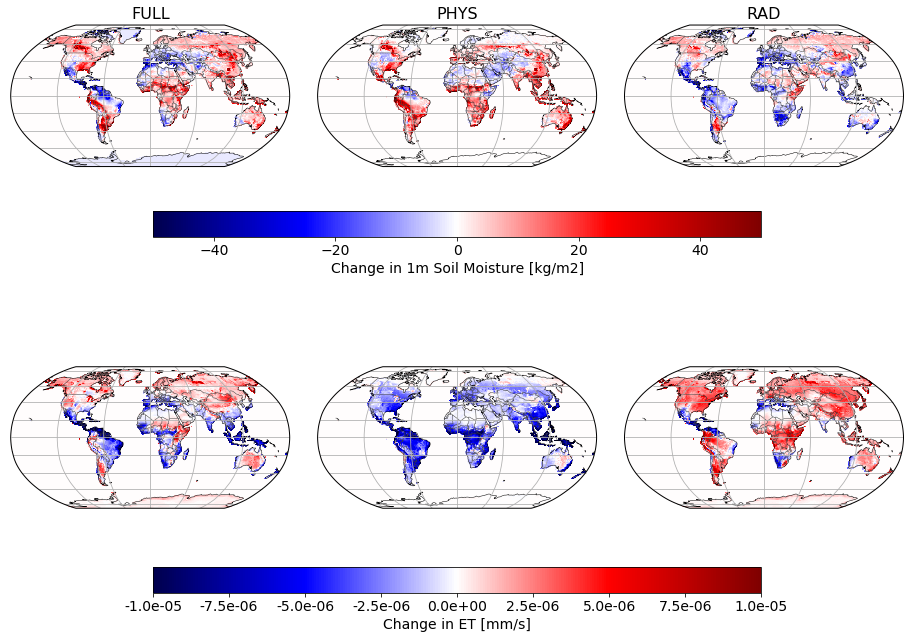

In [20]:
# --- Plot absolute change in soil moisture and ET --- #

## --- Set up figure window --- 
fig, ax_array = plt.subplots(2,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3,ax4,ax5,ax6 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

#
# ---- Set 1: Change in soil moisture ---- #
#

# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((fullSoil_1m-ctrlSoil_1m),axis=0),cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree())
#Other figure options 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.set_title('FULL',fontsize=16)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((physSoil_1m-ctrlSoil_1m),axis=0),cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0, ax_position.width+0.3, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in 1m Soil Moisture [kg/m2]',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax2.set_title('PHYS',fontsize=16)

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((radSoil_1m-ctrlSoil_1m),axis=0),cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree())
#Other figure options 
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax3.set_title('RAD',fontsize=16)

#
# ---- Set 2: Change ET ---- #
#

# FULL #
ax4.set_global()
contour_plot = ax4.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(fullET-ctrlET),cmap='seismic',vmin=-1e-5,vmax=1e-5,transform=ccrs.PlateCarree())
#Other figure options 
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# PHYS #
ax5.set_global()
contour_plot = ax5.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(physET-ctrlET),cmap='seismic',vmin=-1e-5,vmax=1e-5,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax5.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0, ax_position.width+0.3, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,format='%.1e')
cbar.set_label('Change in ET [mm/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax5.coastlines(linewidth=0.5,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax6.set_global()
contour_plot = ax6.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(radET-ctrlET),cmap='seismic',vmin=-1e-5,vmax=1e-5,transform=ccrs.PlateCarree())
#Other figure options 
ax6.coastlines(linewidth=0.5,edgecolor='0.25')
ax6.gridlines()
ax6.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


fig.subplots_adjust(wspace=0.1, hspace=0.1)

/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning: Mean of empty slice
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: RuntimeWarning: Mean of empty slice
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:147: RuntimeWarning: Mean of empty slice


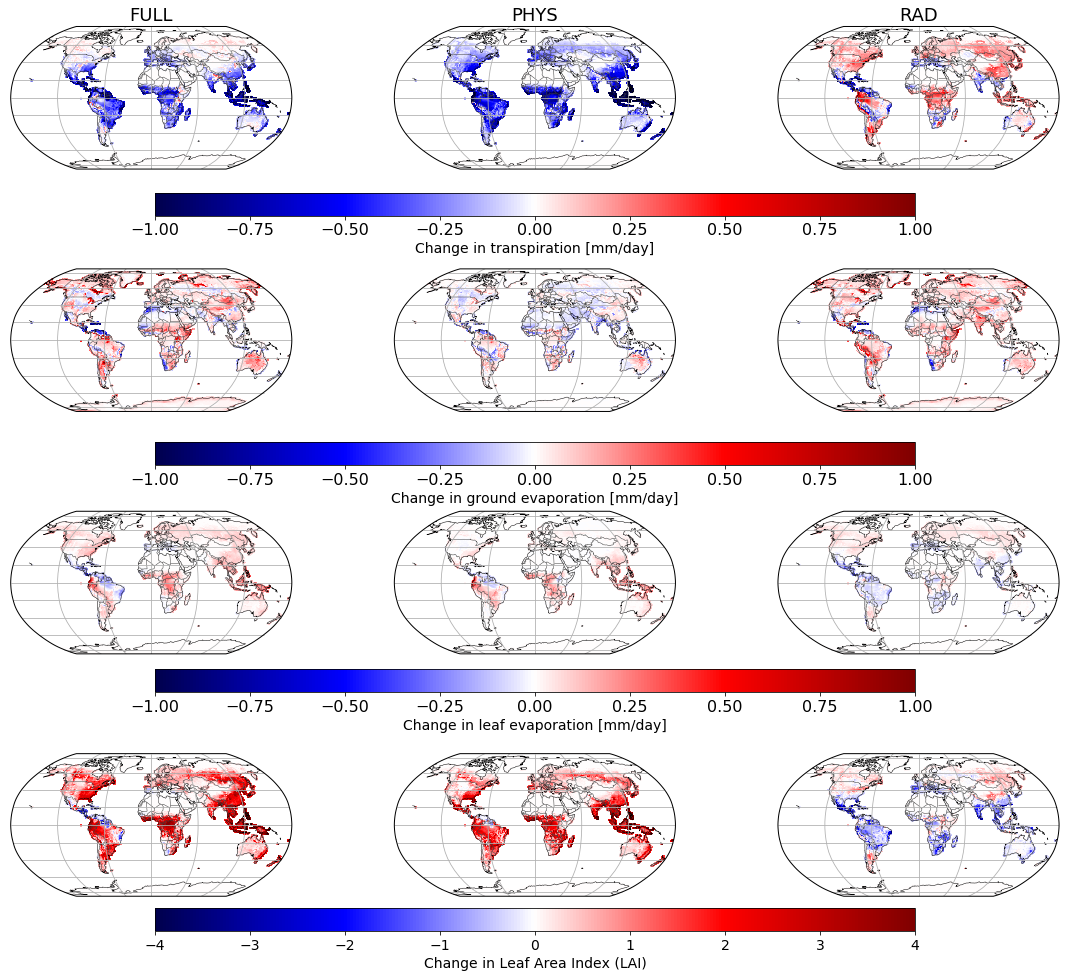

In [16]:
# --- Plot change in transpiration and change in LAI --- # 

## --- Set up figure window --- 
fig, ax_array = plt.subplots(4,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = ax_array.flatten()
fig.set_size_inches(20,16)
#Set basic figure options
ax1.set_global()
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax2.set_global()
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax3.set_global()
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax4.set_global()
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax5.set_global()
ax5.coastlines(linewidth=0.5,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax6.set_global()
ax6.coastlines(linewidth=0.5,edgecolor='0.25')
ax6.gridlines()
ax6.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax7.set_global()
ax7.coastlines(linewidth=0.5,edgecolor='0.25')
ax7.gridlines()
ax7.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax8.set_global()
ax8.coastlines(linewidth=0.5,edgecolor='0.25')
ax8.gridlines()
ax8.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax9.set_global()
ax9.coastlines(linewidth=0.5,edgecolor='0.25')
ax9.gridlines()
ax9.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax10.set_global()
ax10.coastlines(linewidth=0.5,edgecolor='0.25')
ax10.gridlines()
ax10.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax11.set_global()
ax11.coastlines(linewidth=0.5,edgecolor='0.25')
ax11.gridlines()
ax11.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax12.set_global()
ax12.coastlines(linewidth=0.5,edgecolor='0.25')
ax12.gridlines()
ax12.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


#
# ---- Set 1: Change in transpiration ---- #
#

# FULL 
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(fullQvegt_avg-ctrlQvegt_avg),cmap='seismic',vmin=-1,vmax=1,transform=ccrs.PlateCarree())
ax1.set_title('FULL',fontsize=18)

# PHYS 
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(physQvegt_avg-ctrlQvegt_avg),cmap='seismic',vmin=-1,vmax=1,transform=ccrs.PlateCarree())
ax2.set_title('PHYS',fontsize=18)
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0, ax_position.width+0.3, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in transpiration [mm/day]',fontsize=14)
cbar.ax.tick_params(labelsize=16)

# RAD #
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(radQvegt_avg-ctrlQvegt_avg),cmap='seismic',vmin=-1,vmax=1,transform=ccrs.PlateCarree())
ax3.set_title('RAD',fontsize=18)

#
# ---- Set 2: Change in ground evaporation ---- #
#

# FULL
contour_plot = ax4.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(fullQsoil_avg-ctrlQsoil_avg),cmap='seismic',vmin=-1,vmax=1,transform=ccrs.PlateCarree())

# PHYS 
contour_plot = ax5.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(physQsoil_avg-ctrlQsoil_avg),cmap='seismic',vmin=-1,vmax=1,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax5.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0-0.02, ax_position.width+0.3, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in ground evaporation [mm/day]',fontsize=14)
cbar.ax.tick_params(labelsize=16)

# RAD 
contour_plot = ax6.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(radQsoil_avg-ctrlQsoil_avg),cmap='seismic',vmin=-1,vmax=1,transform=ccrs.PlateCarree())

#
# ---- Set 3: Change in leaf evaporation ---- #
#

# FULL
contour_plot = ax7.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(fullQvege_avg-ctrlQvege_avg),cmap='seismic',vmin=-1,vmax=1,transform=ccrs.PlateCarree())

# PHYS 
contour_plot = ax8.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(physQvege_avg-ctrlQvege_avg),cmap='seismic',vmin=-1,vmax=1,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax8.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0-0.02, ax_position.width+0.3, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in leaf evaporation [mm/day]',fontsize=14)
cbar.ax.tick_params(labelsize=16)

# RAD 
contour_plot = ax9.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(radQvege_avg-ctrlQvege_avg),cmap='seismic',vmin=-1,vmax=1,transform=ccrs.PlateCarree())


#
# ---- Set 4: Change in LAI ---- #
#( fullLAI.values-ctrlLAI.values)

# FULL 
contour_plot = ax10.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((fullLAI.values-ctrlLAI.values),axis=0),cmap='seismic',vmin=-4,vmax=4,transform=ccrs.PlateCarree())

# PHYS 
contour_plot = ax11.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((physLAI.values-ctrlLAI.values),axis=0),cmap='seismic',vmin=-4,vmax=4,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax11.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0-0.03, ax_position.width+0.3, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in Leaf Area Index (LAI)',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# RAD 
contour_plot = ax12.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((radLAI.values-ctrlLAI.values),axis=0),cmap='seismic',vmin=-4,vmax=4,transform=ccrs.PlateCarree())

fig.subplots_adjust(wspace=0.1, hspace=0.7)

#Save figure
#fig.savefig('/Users/meganfowler/Documents/Irvine/Flooding/Physiology/Illustrator/Supplement_LAI&ETdecomp.eps',bbox_inches = 'tight')  #Save figure as pdf vector graphic




/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: Mean of empty slice
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: Mean of empty slice
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: Mean of empty slice


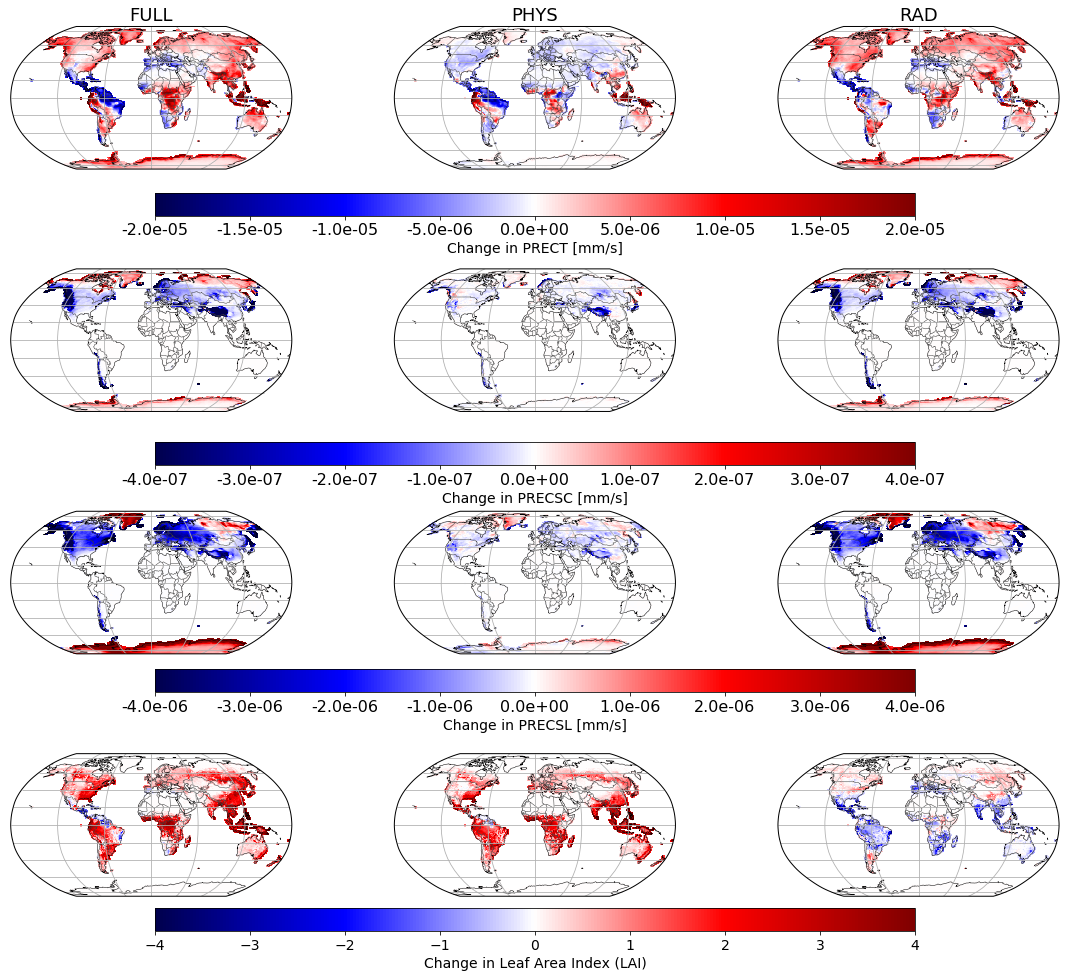

In [77]:
# -- Plot absolute changes in precipitation,rain,snow, and LAI --- #


## --- Set up figure window --- 
fig, ax_array = plt.subplots(4,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = ax_array.flatten()
fig.set_size_inches(20,16)
#Set basic figure options
ax1.set_global()
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax2.set_global()
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax3.set_global()
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax4.set_global()
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax5.set_global()
ax5.coastlines(linewidth=0.5,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax6.set_global()
ax6.coastlines(linewidth=0.5,edgecolor='0.25')
ax6.gridlines()
ax6.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax7.set_global()
ax7.coastlines(linewidth=0.5,edgecolor='0.25')
ax7.gridlines()
ax7.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax8.set_global()
ax8.coastlines(linewidth=0.5,edgecolor='0.25')
ax8.gridlines()
ax8.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax9.set_global()
ax9.coastlines(linewidth=0.5,edgecolor='0.25')
ax9.gridlines()
ax9.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax10.set_global()
ax10.coastlines(linewidth=0.5,edgecolor='0.25')
ax10.gridlines()
ax10.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax11.set_global()
ax11.coastlines(linewidth=0.5,edgecolor='0.25')
ax11.gridlines()
ax11.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

ax12.set_global()
ax12.coastlines(linewidth=0.5,edgecolor='0.25')
ax12.gridlines()
ax12.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


#
# ---- Set 1: Change in PRECT ---- #
#

# FULL 
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((fullPrect.values-ctrlPrect.values),axis=0)*1000*landMask),cmap='seismic',vmin=-2e-5,vmax=2e-5,transform=ccrs.PlateCarree())
ax1.set_title('FULL',fontsize=18)

# PHYS 
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((physPrect.values-ctrlPrect.values),axis=0)*1000*landMask),cmap='seismic',vmin=-2e-5,vmax=2e-5,transform=ccrs.PlateCarree())
ax2.set_title('PHYS',fontsize=18)
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0, ax_position.width+0.3, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,format='%.1e')
cbar.set_label('Change in PRECT [mm/s]',fontsize=14)
cbar.ax.tick_params(labelsize=16)

# RAD #
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((radPrect.values-ctrlPrect.values),axis=0)*1000*landMask),cmap='seismic',vmin=-2e-5,vmax=2e-5,transform=ccrs.PlateCarree())
ax3.set_title('RAD',fontsize=18)

#
# ---- Set 2: Change in Precsc ---- #
#

# FULL
contour_plot = ax4.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((fullPrecsc.values-ctrlPrecsc.values),axis=0)*1000*landMask),cmap='seismic',vmin=-4e-7,vmax=4e-7,transform=ccrs.PlateCarree())

# PHYS 
contour_plot = ax5.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((physPrecsc.values-ctrlPrecsc.values),axis=0)*1000*landMask),cmap='seismic',vmin=-4e-7,vmax=4e-7,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax5.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0-0.02, ax_position.width+0.3, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,format='%.1e')
cbar.set_label('Change in PRECSC [mm/s]',fontsize=14)
cbar.ax.tick_params(labelsize=16)

# RAD 
contour_plot = ax6.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((radPrecsc.values-ctrlPrecsc.values),axis=0)*1000*landMask),cmap='seismic',vmin=-4e-7,vmax=4e-7,transform=ccrs.PlateCarree())

#
# ---- Set 3: Change in PRECSL ---- #
#

# FULL
contour_plot = ax7.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((fullPrecsl.values-ctrlPrecsl.values),axis=0)*1000*landMask),cmap='seismic',vmin=-4e-6,vmax=4e-6,transform=ccrs.PlateCarree())

# PHYS 
contour_plot = ax8.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((physPrecsl.values-ctrlPrecsl.values),axis=0)*1000*landMask),cmap='seismic',vmin=-4e-6,vmax=4e-6,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax8.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0-0.02, ax_position.width+0.3, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,format='%.1e')
cbar.set_label('Change in PRECSL [mm/s]',fontsize=14)
cbar.ax.tick_params(labelsize=16)

# RAD 
contour_plot = ax9.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((radPrecsl.values-ctrlPrecsl.values),axis=0)*1000*landMask),cmap='seismic',vmin=-4e-6,vmax=4e-6,transform=ccrs.PlateCarree())


#
# ---- Set 4: Change in LAI ---- #
#( fullLAI.values-ctrlLAI.values)

# FULL 
contour_plot = ax10.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((fullLAI.values-ctrlLAI.values),axis=0),cmap='seismic',vmin=-4,vmax=4,transform=ccrs.PlateCarree())

# PHYS 
contour_plot = ax11.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((physLAI.values-ctrlLAI.values),axis=0),cmap='seismic',vmin=-4,vmax=4,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax11.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0-0.03, ax_position.width+0.3, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in Leaf Area Index (LAI)',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# RAD 
contour_plot = ax12.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((radLAI.values-ctrlLAI.values),axis=0),cmap='seismic',vmin=-4,vmax=4,transform=ccrs.PlateCarree())

fig.subplots_adjust(wspace=0.1, hspace=0.7)


#fig.subplots_adjust(wspace=0.1, hspace=0.05)



### Can we figure out what's going on in the transition zone at edge of boreal forests? 

In [13]:
np.nanmax(np.nanmean((fullRunoff.values-ctrlRunoff.values),axis=0))

/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


8.342928e-05

/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


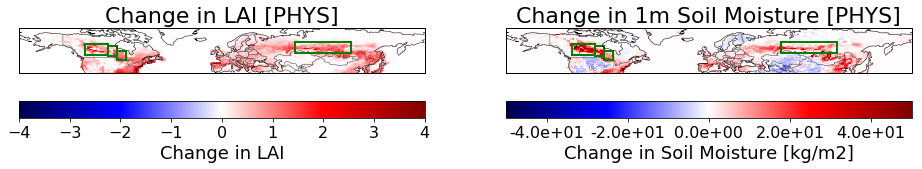

In [36]:
## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,2,subplot_kw={'projection':ccrs.PlateCarree()})
ax1,ax2 = ax_array.flatten()
fig.set_size_inches(16,12)

ax1.set_extent([-180,180,35,75], crs=ccrs.PlateCarree())
ax2.set_extent([-180,180,35,75], crs=ccrs.PlateCarree())

#Plot LAI
contour_plot = ax1.pcolormesh(cesmLon,cesmLat,np.nanmean((physLAI.values-ctrlLAI.values),axis=0),cmap='seismic',vmin=-4,vmax=4,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.3, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in LAI',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax1.set_title('Change in LAI [PHYS]')
ax1.title.set_fontsize(22)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#Add rectangles to define regions
rect = patches.Rectangle((239,51),20,10,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax1.add_patch(rect)
rect = patches.Rectangle((259,50),8,9,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax1.add_patch(rect)
rect = patches.Rectangle((267,47),8,8,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax1.add_patch(rect)
rect = patches.Rectangle((65,53),50,10,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax1.add_patch(rect)

# Plot Soil Moisture 
contour_plot = ax2.pcolormesh(cesmLon,cesmLat,np.nanmean((physSoil_1m-ctrlSoil_1m),axis=0),cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.3, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,format='%.1e')
cbar.set_label('Change in Soil Moisture [kg/m2]',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax2.set_title('Change in 1m Soil Moisture [PHYS]')
ax2.title.set_fontsize(22)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#Add rectangels to define regions 
rect = patches.Rectangle((239,51),20,10,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax2.add_patch(rect)
rect = patches.Rectangle((259,50),8,9,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax2.add_patch(rect)
rect = patches.Rectangle((267,47),8,8,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax2.add_patch(rect)
rect = patches.Rectangle((64,53),50,10,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax2.add_patch(rect)



/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


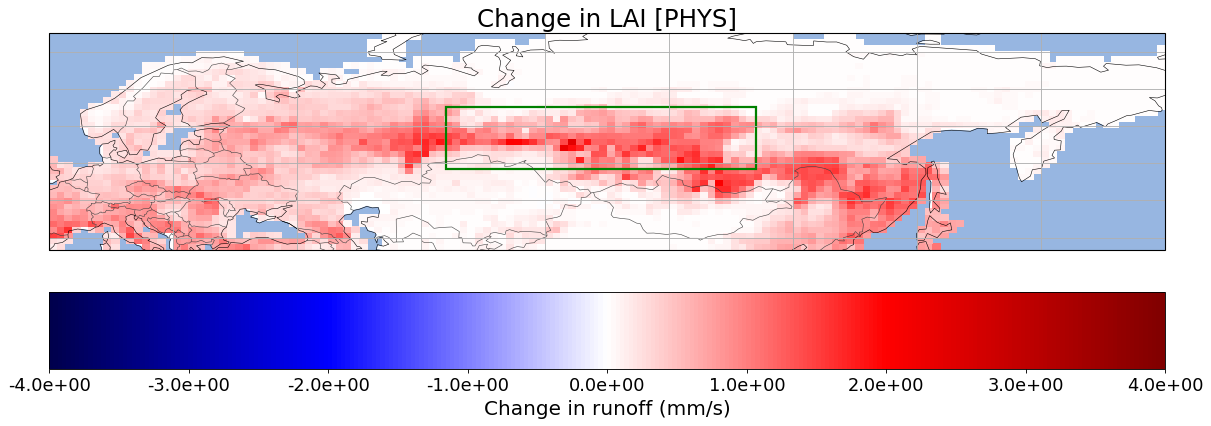

In [35]:
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([0,180,40,75], crs=ccrs.PlateCarree())

## --- Create Plot ---
contour_plot = ax.pcolormesh(cesmLon,cesmLat,np.nanmean((physLAI.values-ctrlLAI.values),axis=0),cmap='seismic',vmin=-4,vmax=4,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.2, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,format='%.1e')
cbar.set_label('Change in runoff (mm/s)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Change in LAI [PHYS]')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.add_feature(cfeature.OCEAN)

#Add rectangle to define region
rect = patches.Rectangle((64,53),50,10,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax.add_patch(rect)
# rect = patches.Rectangle((259,50),8,9,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())    #SE US
# ax.add_patch(rect)
# rect = patches.Rectangle((267,47),8,8,linewidth=2,edgecolor='b',facecolor='none', transform=ccrs.PlateCarree())    #SE US
# ax.add_patch(rect)
# plt.show()



/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


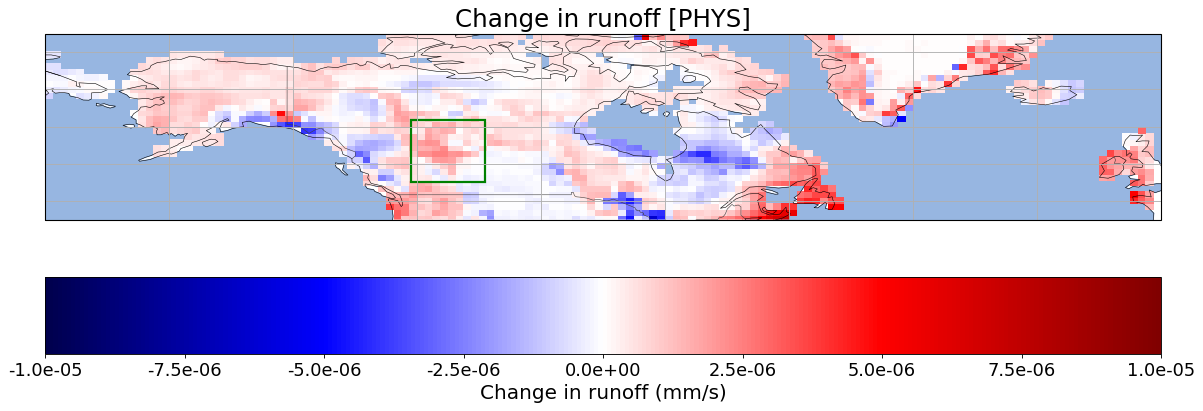

In [104]:
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180,0,45,75], crs=ccrs.PlateCarree())

## --- Create Plot ---
contour_plot = ax.pcolormesh(cesmLon,cesmLat,np.nanmean((physRunoff.values-ctrlRunoff.values),axis=0),cmap='seismic',vmin=-1e-5,vmax=1e-5,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.2, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,format='%.1e')
cbar.set_label('Change in runoff (mm/s)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Change in runoff [PHYS]')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.add_feature(cfeature.OCEAN)

#Add rectangle to define region
rect = patches.Rectangle((239,51),12,10,linewidth=2,edgecolor='g',facecolor='none', transform=ccrs.PlateCarree())    #SE US
ax.add_patch(rect)
plt.show()


<br><br>
Domains of interest: <br>
* 239-259 (lon) and 51-61 (lat)
* 259-267 (lon) and 50-59 (lat)
* 267-275 (lon) and 47-55 (lat)
* 64-114 (lon)  and 53-63 (lat) 


<br><br>

In [42]:
#Region 1: 
ilon1 = np.where((cesmLon>=(239)) & (cesmLon<=(259)))
ilat1 = np.where((cesmLat>=51)    & (cesmLat<=61))

latMin1 = np.min(ilat1[0])
latMax1 = np.max(ilat1[0])
lonMin1 = np.min(ilon1[0])
lonMax1 = np.max(ilon1[0])

#Region 2: 
ilon2 = np.where((cesmLon>=(259)) & (cesmLon<=(267)))
ilat2 = np.where((cesmLat>=50)    & (cesmLat<=59))

latMin2 = np.min(ilat2[0])
latMax2 = np.max(ilat2[0])
lonMin2 = np.min(ilon2[0])
lonMax2 = np.max(ilon2[0])

#Region 3: 
ilon3 = np.where((cesmLon>=(267)) & (cesmLon<=(275)))
ilat3 = np.where((cesmLat>=47)    & (cesmLat<=55))

latMin3 = np.min(ilat3[0])
latMax3 = np.max(ilat3[0])
lonMin3 = np.min(ilon3[0])
lonMax3 = np.max(ilon3[0])

#Region 4: Eastern Europe 
ilon4 = np.where((cesmLon>=(64)) & (cesmLon<=(114)))
ilat4 = np.where((cesmLat>=53)    & (cesmLat<=63))

latMin4 = np.min(ilat4[0])
latMax4 = np.max(ilat4[0])
lonMin4 = np.min(ilon4[0])
lonMax4 = np.max(ilon4[0])


In [39]:
print(np.shape(ctrlRunoff.values))
print(np.shape(cesmLon))
print(np.shape(ilon1[0]))
print(ilon1[0])


(360, 192, 288)
(288,)
(16,)
[192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207]


In [40]:
# Define snowfall as PRECSC+PRECSL 

ctrlSnow = ctrlPrecsc.values+ctrlPrecsl.values
fullSnow = fullPrecsc.values+fullPrecsl.values
physSnow = physPrecsc.values+physPrecsl.values
radSnow  = radPrecsc.values+radPrecsl.values


In [43]:
# --- Isolate this region for a bunch of variables --- #

#Region 1 
ctrlRunoff_reg1 = ctrlRunoff.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
fullRunoff_reg1 = fullRunoff.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
physRunoff_reg1 = physRunoff.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
radRunoff_reg1  = radRunoff.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]

ctrlMelt_reg1   = ctrlMelt.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
fullMelt_reg1   = fullMelt.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
physMelt_reg1   = physMelt.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
radMelt_reg1    = radMelt.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]

ctrlPrect_reg1  = ctrlPrect.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
fullPrect_reg1  = fullPrect.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
physPrect_reg1  = physPrect.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
radPrect_reg1   = radPrect.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]

ctrlSnow_reg1   = ctrlSnow[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
fullSnow_reg1   = fullSnow[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
physSnow_reg1   = physSnow[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
radSnow_reg1    = radSnow[:,latMin1:latMax1+1,lonMin1:lonMax1+1]

ctrlSoil_reg1   = ctrlSoil_1m[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
fullSoil_reg1   = fullSoil_1m[:,latMin1:latMax1+1,lonMin1:lonMax1+1] 
physSoil_reg1   = physSoil_1m[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
radSoil_reg1    = radSoil_1m[:,latMin1:latMax1+1,lonMin1:lonMax1+1]

#Region 2
ctrlRunoff_reg2 = ctrlRunoff.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
fullRunoff_reg2 = fullRunoff.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
physRunoff_reg2 = physRunoff.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
radRunoff_reg2  = radRunoff.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]

ctrlMelt_reg2   = ctrlMelt.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
fullMelt_reg2   = fullMelt.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
physMelt_reg2   = physMelt.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
radMelt_reg2    = radMelt.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]

ctrlPrect_reg2  = ctrlPrect.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
fullPrect_reg2  = fullPrect.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
physPrect_reg2  = physPrect.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
radPrect_reg2   = radPrect.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]

ctrlSnow_reg2   = ctrlSnow[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
fullSnow_reg2   = fullSnow[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
physSnow_reg2   = physSnow[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
radSnow_reg2    = radSnow[:,latMin2:latMax2+1,lonMin2:lonMax2+1]

ctrlSoil_reg2   = ctrlSoil_1m[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
fullSoil_reg2   = fullSoil_1m[:,latMin2:latMax2+1,lonMin2:lonMax2+1] 
physSoil_reg2   = physSoil_1m[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
radSoil_reg2    = radSoil_1m[:,latMin2:latMax2+1,lonMin2:lonMax2+1]

#Region 3
ctrlRunoff_reg3 = ctrlRunoff.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
fullRunoff_reg3 = fullRunoff.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
physRunoff_reg3 = physRunoff.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
radRunoff_reg3  = radRunoff.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]

ctrlMelt_reg3   = ctrlMelt.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
fullMelt_reg3   = fullMelt.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
physMelt_reg3   = physMelt.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
radMelt_reg3    = radMelt.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]

ctrlPrect_reg3  = ctrlPrect.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
fullPrect_reg3  = fullPrect.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
physPrect_reg3  = physPrect.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
radPrect_reg3   = radPrect.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]

ctrlSnow_reg3   = ctrlSnow[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
fullSnow_reg3   = fullSnow[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
physSnow_reg3   = physSnow[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
radSnow_reg3    = radSnow[:,latMin3:latMax3+1,lonMin3:lonMax3+1]

ctrlSoil_reg3   = ctrlSoil_1m[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
fullSoil_reg3   = fullSoil_1m[:,latMin3:latMax3+1,lonMin3:lonMax3+1] 
physSoil_reg3   = physSoil_1m[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
radSoil_reg3    = radSoil_1m[:,latMin3:latMax3+1,lonMin3:lonMax3+1]

#Region 4
ctrlRunoff_reg4 = ctrlRunoff.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
fullRunoff_reg4 = fullRunoff.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
physRunoff_reg4 = physRunoff.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
radRunoff_reg4  = radRunoff.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]

ctrlMelt_reg4   = ctrlMelt.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
fullMelt_reg4   = fullMelt.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
physMelt_reg4   = physMelt.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
radMelt_reg4    = radMelt.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]

ctrlPrect_reg4  = ctrlPrect.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
fullPrect_reg4  = fullPrect.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
physPrect_reg4  = physPrect.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
radPrect_reg4   = radPrect.values[:,latMin4:latMax4+1,lonMin4:lonMax4+1]

ctrlSnow_reg4   = ctrlSnow[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
fullSnow_reg4   = fullSnow[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
physSnow_reg4   = physSnow[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
radSnow_reg4    = radSnow[:,latMin4:latMax4+1,lonMin4:lonMax4+1]

ctrlSoil_reg4   = ctrlSoil_1m[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
fullSoil_reg4   = fullSoil_1m[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
physSoil_reg4   = physSoil_1m[:,latMin4:latMax4+1,lonMin4:lonMax4+1]
radSoil_reg4    = radSoil_1m[:,latMin4:latMax4+1,lonMin4:lonMax4+1]


In [71]:
# --- Average over space and then average all three together all three regions --- #

# Runoff 
ctrlRunoff_reg1mean = np.nanmean(np.nanmean(ctrlRunoff_reg1,axis=2),axis=1)
ctrlRunoff_reg2mean = np.nanmean(np.nanmean(ctrlRunoff_reg2,axis=2),axis=1)
ctrlRunoff_reg3mean = np.nanmean(np.nanmean(ctrlRunoff_reg3,axis=2),axis=1)
ctrlRunoff_reg4mean = np.nanmean(np.nanmean(ctrlRunoff_reg4,axis=2),axis=1)
ctrlRunoff_reg      = np.nanmean([ctrlRunoff_reg1mean, ctrlRunoff_reg2mean, ctrlRunoff_reg3mean,ctrlRunoff_reg4mean],axis=0)

fullRunoff_reg1mean = np.nanmean(np.nanmean(fullRunoff_reg1,axis=2),axis=1)
fullRunoff_reg2mean = np.nanmean(np.nanmean(fullRunoff_reg2,axis=2),axis=1)
fullRunoff_reg3mean = np.nanmean(np.nanmean(fullRunoff_reg3,axis=2),axis=1)
fullRunoff_reg4mean = np.nanmean(np.nanmean(fullRunoff_reg4,axis=2),axis=1)
fullRunoff_reg      = np.nanmean([fullRunoff_reg1mean,fullRunoff_reg2mean,fullRunoff_reg3mean,fullRunoff_reg4mean],axis=0)

physRunoff_reg1mean = np.nanmean(np.nanmean(physRunoff_reg1,axis=2),axis=1)
physRunoff_reg2mean = np.nanmean(np.nanmean(physRunoff_reg2,axis=2),axis=1)
physRunoff_reg3mean = np.nanmean(np.nanmean(physRunoff_reg3,axis=2),axis=1)
physRunoff_reg4mean = np.nanmean(np.nanmean(physRunoff_reg4,axis=2),axis=1)
physRunoff_reg      = np.nanmean([physRunoff_reg1mean,physRunoff_reg2mean,physRunoff_reg3mean,physRunoff_reg4mean],axis=0)

radRunoff_reg1mean = np.nanmean(np.nanmean(radRunoff_reg1,axis=2),axis=1)
radRunoff_reg2mean = np.nanmean(np.nanmean(radRunoff_reg2,axis=2),axis=1)
radRunoff_reg3mean = np.nanmean(np.nanmean(radRunoff_reg3,axis=2),axis=1)
radRunoff_reg4mean = np.nanmean(np.nanmean(radRunoff_reg4,axis=2),axis=1)
radRunoff_reg      = np.nanmean([radRunoff_reg1mean,radRunoff_reg2mean,radRunoff_reg3mean,radRunoff_reg4mean],axis=0)

# Melt 
ctrlMelt_reg1mean = np.nanmean(np.nanmean(ctrlMelt_reg1,axis=2),axis=1)
ctrlMelt_reg2mean = np.nanmean(np.nanmean(ctrlMelt_reg2,axis=2),axis=1)
ctrlMelt_reg3mean = np.nanmean(np.nanmean(ctrlMelt_reg3,axis=2),axis=1)
ctrlMelt_reg4mean = np.nanmean(np.nanmean(ctrlMelt_reg4,axis=2),axis=1)
ctrlMelt_reg      = np.nanmean([ctrlMelt_reg1mean, ctrlMelt_reg2mean, ctrlMelt_reg3mean,ctrlMelt_reg4mean],axis=0)

fullMelt_reg1mean = np.nanmean(np.nanmean(fullMelt_reg1,axis=2),axis=1)
fullMelt_reg2mean = np.nanmean(np.nanmean(fullMelt_reg2,axis=2),axis=1)
fullMelt_reg3mean = np.nanmean(np.nanmean(fullMelt_reg3,axis=2),axis=1)
fullMelt_reg4mean = np.nanmean(np.nanmean(fullMelt_reg4,axis=2),axis=1)
fullMelt_reg      = np.nanmean([fullMelt_reg1mean,fullMelt_reg2mean,fullMelt_reg3mean,fullMelt_reg4mean],axis=0)

physMelt_reg1mean = np.nanmean(np.nanmean(physMelt_reg1,axis=2),axis=1)
physMelt_reg2mean = np.nanmean(np.nanmean(physMelt_reg2,axis=2),axis=1)
physMelt_reg3mean = np.nanmean(np.nanmean(physMelt_reg3,axis=2),axis=1)
physMelt_reg4mean = np.nanmean(np.nanmean(physMelt_reg4,axis=2),axis=1)
physMelt_reg      = np.nanmean([physMelt_reg1mean,physMelt_reg2mean,physMelt_reg3mean,physMelt_reg4mean],axis=0)

radMelt_reg1mean = np.nanmean(np.nanmean(radMelt_reg1,axis=2),axis=1)
radMelt_reg2mean = np.nanmean(np.nanmean(radMelt_reg2,axis=2),axis=1)
radMelt_reg3mean = np.nanmean(np.nanmean(radMelt_reg3,axis=2),axis=1)
radMelt_reg4mean = np.nanmean(np.nanmean(radMelt_reg4,axis=2),axis=1)
radMelt_reg      = np.nanmean([radMelt_reg1mean,radMelt_reg2mean,radMelt_reg3mean,radMelt_reg4mean],axis=0)

# Prect 
ctrlPrect_reg1mean = np.nanmean(np.nanmean(ctrlPrect_reg1,axis=2),axis=1)
ctrlPrect_reg2mean = np.nanmean(np.nanmean(ctrlPrect_reg2,axis=2),axis=1)
ctrlPrect_reg3mean = np.nanmean(np.nanmean(ctrlPrect_reg3,axis=2),axis=1)
ctrlPrect_reg4mean = np.nanmean(np.nanmean(ctrlPrect_reg4,axis=2),axis=1)
ctrlPrect_reg      = np.nanmean([ctrlPrect_reg1mean, ctrlPrect_reg2mean, ctrlPrect_reg3mean,ctrlPrect_reg4mean],axis=0)

fullPrect_reg1mean = np.nanmean(np.nanmean(fullPrect_reg1,axis=2),axis=1)
fullPrect_reg2mean = np.nanmean(np.nanmean(fullPrect_reg2,axis=2),axis=1)
fullPrect_reg3mean = np.nanmean(np.nanmean(fullPrect_reg3,axis=2),axis=1)
fullPrect_reg4mean = np.nanmean(np.nanmean(fullPrect_reg4,axis=2),axis=1)
fullPrect_reg      = np.nanmean([fullPrect_reg1mean,fullPrect_reg2mean,fullPrect_reg3mean,fullPrect_reg4mean],axis=0)

physPrect_reg1mean = np.nanmean(np.nanmean(physPrect_reg1,axis=2),axis=1)
physPrect_reg2mean = np.nanmean(np.nanmean(physPrect_reg2,axis=2),axis=1)
physPrect_reg3mean = np.nanmean(np.nanmean(physPrect_reg3,axis=2),axis=1)
physPrect_reg4mean = np.nanmean(np.nanmean(physPrect_reg4,axis=2),axis=1)
physPrect_reg      = np.nanmean([physPrect_reg1mean,physPrect_reg2mean,physPrect_reg3mean,physPrect_reg4mean],axis=0)

radPrect_reg1mean = np.nanmean(np.nanmean(radPrect_reg1,axis=2),axis=1)
radPrect_reg2mean = np.nanmean(np.nanmean(radPrect_reg2,axis=2),axis=1)
radPrect_reg3mean = np.nanmean(np.nanmean(radPrect_reg3,axis=2),axis=1)
radPrect_reg4mean = np.nanmean(np.nanmean(radPrect_reg4,axis=2),axis=1)
radPrect_reg      = np.nanmean([radPrect_reg1mean,radPrect_reg2mean,radPrect_reg3mean,radPrect_reg4mean],axis=0)

# Soil

ctrlSoil_reg1mean = np.nanmean(np.nanmean(ctrlSoil_reg1,axis=2),axis=1)
ctrlSoil_reg2mean = np.nanmean(np.nanmean(ctrlSoil_reg2,axis=2),axis=1)
ctrlSoil_reg3mean = np.nanmean(np.nanmean(ctrlSoil_reg3,axis=2),axis=1)
ctrlSoil_reg4mean = np.nanmean(np.nanmean(ctrlSoil_reg4,axis=2),axis=1)
ctrlSoil_reg      = np.nanmean([ctrlSoil_reg1mean, ctrlSoil_reg2mean, ctrlSoil_reg3mean,ctrlSoil_reg4mean],axis=0)

fullSoil_reg1mean = np.nanmean(np.nanmean(fullSoil_reg1,axis=2),axis=1)
fullSoil_reg2mean = np.nanmean(np.nanmean(fullSoil_reg2,axis=2),axis=1)
fullSoil_reg3mean = np.nanmean(np.nanmean(fullSoil_reg3,axis=2),axis=1)
fullSoil_reg4mean = np.nanmean(np.nanmean(fullSoil_reg4,axis=2),axis=1)
fullSoil_reg      = np.nanmean([fullSoil_reg1mean,fullSoil_reg2mean,fullSoil_reg3mean,fullSoil_reg4mean],axis=0)

physSoil_reg1mean = np.nanmean(np.nanmean(physSoil_reg1,axis=2),axis=1)
physSoil_reg2mean = np.nanmean(np.nanmean(physSoil_reg2,axis=2),axis=1)
physSoil_reg3mean = np.nanmean(np.nanmean(physSoil_reg3,axis=2),axis=1)
physSoil_reg4mean = np.nanmean(np.nanmean(physSoil_reg4,axis=2),axis=1)
physSoil_reg      = np.nanmean([physSoil_reg1mean,physSoil_reg2mean,physSoil_reg3mean,physSoil_reg4mean],axis=0)

radSoil_reg1mean = np.nanmean(np.nanmean(radSoil_reg1,axis=2),axis=1)
radSoil_reg2mean = np.nanmean(np.nanmean(radSoil_reg2,axis=2),axis=1)
radSoil_reg3mean = np.nanmean(np.nanmean(radSoil_reg3,axis=2),axis=1)
radSoil_reg4mean = np.nanmean(np.nanmean(radSoil_reg4,axis=2),axis=1)
radSoil_reg      = np.nanmean([radSoil_reg1mean,radSoil_reg2mean,radSoil_reg3mean,radSoil_reg4mean],axis=0)




In [72]:
# --- Split into each yearly data and take annual mean --- #

ctrlRunoff_Ann = np.nanmean(np.split(ctrlRunoff_reg,30),axis=0)
fullRunoff_Ann = np.nanmean(np.split(fullRunoff_reg,30),axis=0)
physRunoff_Ann = np.nanmean(np.split(physRunoff_reg,30),axis=0)
radRunoff_Ann  = np.nanmean(np.split(radRunoff_reg,30),axis=0)

ctrlMelt_Ann = np.nanmean(np.split(ctrlMelt_reg,30),axis=0)
fullMelt_Ann = np.nanmean(np.split(fullMelt_reg,30),axis=0)
physMelt_Ann = np.nanmean(np.split(physMelt_reg,30),axis=0)
radMelt_Ann  = np.nanmean(np.split(radMelt_reg,30),axis=0)

ctrlPrect_Ann = np.nanmean(np.split(ctrlPrect_reg,30),axis=0)
fullPrect_Ann = np.nanmean(np.split(fullPrect_reg,30),axis=0)
physPrect_Ann = np.nanmean(np.split(physPrect_reg,30),axis=0)
radPrect_Ann  = np.nanmean(np.split(radPrect_reg,30),axis=0)

ctrlSoil_Ann = np.nanmean(np.split(ctrlSoil_reg,30),axis=0)
fullSoil_Ann = np.nanmean(np.split(fullSoil_reg,30),axis=0)
physSoil_Ann = np.nanmean(np.split(physSoil_reg,30),axis=0)
radSoil_Ann  = np.nanmean(np.split(radSoil_reg,30),axis=0)


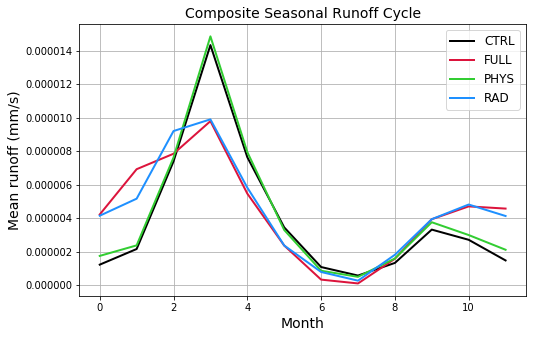

In [67]:
# -- Time series of runoff -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlRunoff_Ann,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullRunoff_Ann,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physRunoff_Ann,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radRunoff_Ann,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Runoff Cycle',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean runoff (mm/s)',fontsize=my_fontsize)
plt.grid()




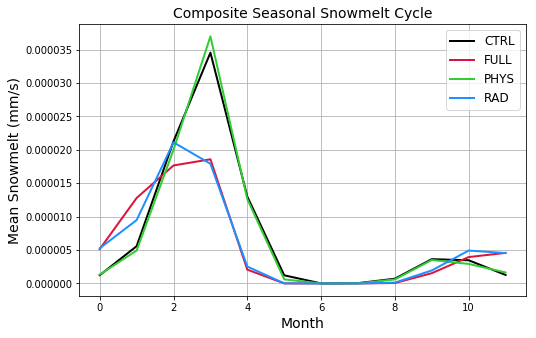

In [73]:
# -- Time series of snowmelt -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlMelt_Ann,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullMelt_Ann,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physMelt_Ann,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radMelt_Ann,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Snowmelt Cycle',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean Snowmelt (mm/s)',fontsize=my_fontsize)
plt.grid()



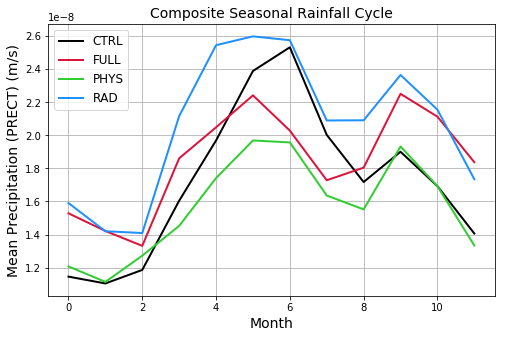

In [74]:
# -- Time series of precipitation (PRECT) -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlPrect_Ann,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullPrect_Ann,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physPrect_Ann,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radPrect_Ann,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Rainfall Cycle',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean Precipitation (PRECT) (m/s)',fontsize=my_fontsize)
plt.grid()



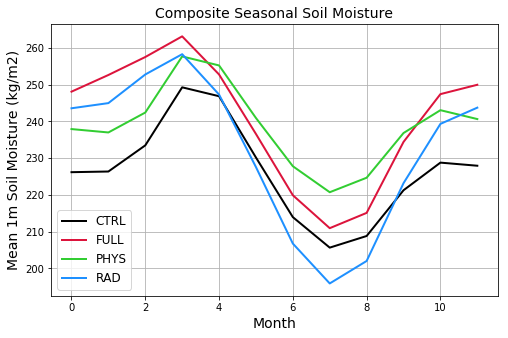

In [75]:
# -- Time series of 1m soil moisture -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlSoil_Ann,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullSoil_Ann,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physSoil_Ann,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radSoil_Ann,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Soil Moisture',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean 1m Soil Moisture (kg/m2)',fontsize=my_fontsize)
plt.grid()



<br><br> **Similar to above, but let's also look at the snowmelt seasonal cycle in the multiply stressed regions - is there just overall less, or is it also shifted to earlier in the season?** <br><br>

In [29]:
#SE US: 
ilon1 = np.where((cesmLon>=264) & (cesmLon<=276))
ilat1 = np.where((cesmLat>=29) & (cesmLat<=38))

latMin1 = np.min(ilat1[0])
latMax1 = np.max(ilat1[0])
lonMin1 = np.min(ilon1[0])
lonMax1 = np.max(ilon1[0])

#SE Asia:  
ilon2 = np.where((cesmLon>=95) & (cesmLon<=109))
ilat2 = np.where((cesmLat>=12) & (cesmLat<=25))

latMin2 = np.min(ilat2[0])
latMax2 = np.max(ilat2[0])
lonMin2 = np.min(ilon2[0])
lonMax2 = np.max(ilon2[0])

#Central Australia: 
ilon3 = np.where((cesmLon>=136) & (cesmLon<=146))
ilat3 = np.where((cesmLat>=-31)    & (cesmLat<=-18))

latMin3 = np.min(ilat3[0])
latMax3 = np.max(ilat3[0])
lonMin3 = np.min(ilon3[0])
lonMax3 = np.max(ilon3[0])


In [30]:
# --- Isolate this region for a bunch of variables --- #

#Region 1 
ctrlMelt_reg1   = ctrlMelt.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
fullMelt_reg1   = fullMelt.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
physMelt_reg1   = physMelt.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]
radMelt_reg1    = radMelt.values[:,latMin1:latMax1+1,lonMin1:lonMax1+1]

#Region 2
ctrlMelt_reg2   = ctrlMelt.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
fullMelt_reg2   = fullMelt.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
physMelt_reg2   = physMelt.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]
radMelt_reg2    = radMelt.values[:,latMin2:latMax2+1,lonMin2:lonMax2+1]

#Region 3
ctrlMelt_reg3   = ctrlMelt.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
fullMelt_reg3   = fullMelt.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
physMelt_reg3   = physMelt.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]
radMelt_reg3    = radMelt.values[:,latMin3:latMax3+1,lonMin3:lonMax3+1]




In [31]:
# --- Average over space and then average all three together all three regions --- #

# Melt 
ctrlMelt_reg1mean = np.nanmean(np.nanmean(ctrlMelt_reg1,axis=2),axis=1)
ctrlMelt_reg2mean = np.nanmean(np.nanmean(ctrlMelt_reg2,axis=2),axis=1)
ctrlMelt_reg3mean = np.nanmean(np.nanmean(ctrlMelt_reg3,axis=2),axis=1)

fullMelt_reg1mean = np.nanmean(np.nanmean(fullMelt_reg1,axis=2),axis=1)
fullMelt_reg2mean = np.nanmean(np.nanmean(fullMelt_reg2,axis=2),axis=1)
fullMelt_reg3mean = np.nanmean(np.nanmean(fullMelt_reg3,axis=2),axis=1)

physMelt_reg1mean = np.nanmean(np.nanmean(physMelt_reg1,axis=2),axis=1)
physMelt_reg2mean = np.nanmean(np.nanmean(physMelt_reg2,axis=2),axis=1)
physMelt_reg3mean = np.nanmean(np.nanmean(physMelt_reg3,axis=2),axis=1)

radMelt_reg1mean = np.nanmean(np.nanmean(radMelt_reg1,axis=2),axis=1)
radMelt_reg2mean = np.nanmean(np.nanmean(radMelt_reg2,axis=2),axis=1)
radMelt_reg3mean = np.nanmean(np.nanmean(radMelt_reg3,axis=2),axis=1)


In [32]:
# --- Split into each yearly data and take annual mean --- #

ctrlMelt_US = np.nanmean(np.split(ctrlMelt_reg1mean,30),axis=0)
fullMelt_US = np.nanmean(np.split(fullMelt_reg1mean,30),axis=0)
physMelt_US = np.nanmean(np.split(physMelt_reg1mean,30),axis=0)
radMelt_US  = np.nanmean(np.split(radMelt_reg1mean,30),axis=0)

ctrlMelt_Asia = np.nanmean(np.split(ctrlMelt_reg2mean,30),axis=0)
fullMelt_Asia = np.nanmean(np.split(fullMelt_reg2mean,30),axis=0)
physMelt_Asia = np.nanmean(np.split(physMelt_reg2mean,30),axis=0)
radMelt_Asia  = np.nanmean(np.split(radMelt_reg2mean,30),axis=0)

ctrlMelt_Aus = np.nanmean(np.split(ctrlMelt_reg3mean,30),axis=0)
fullMelt_Aus = np.nanmean(np.split(fullMelt_reg3mean,30),axis=0)
physMelt_Aus = np.nanmean(np.split(physMelt_reg3mean,30),axis=0)
radMelt_Aus  = np.nanmean(np.split(radMelt_reg3mean,30),axis=0)


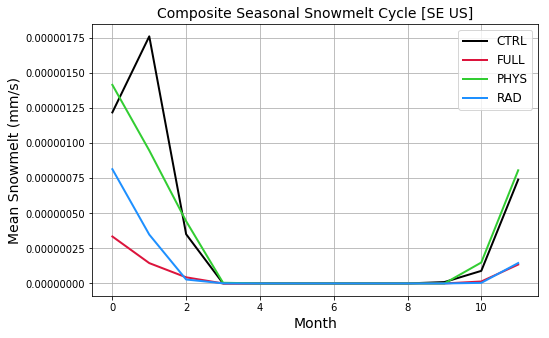

In [34]:
# -- Time series of snowmelt: India -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlMelt_US,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullMelt_US,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physMelt_US,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radMelt_US,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Snowmelt Cycle [SE US]',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean Snowmelt (mm/s)',fontsize=my_fontsize)
plt.grid()




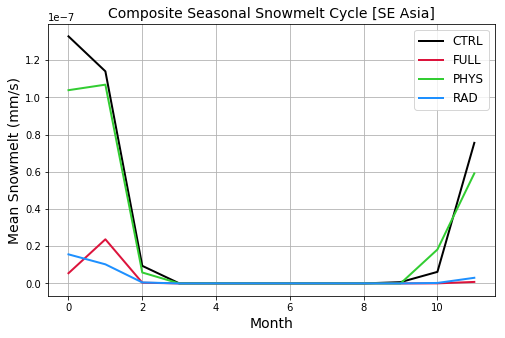

In [35]:
# -- Time series of snowmelt: India -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlMelt_Asia,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullMelt_Asia,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physMelt_Asia,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radMelt_Asia,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Snowmelt Cycle [SE Asia]',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean Snowmelt (mm/s)',fontsize=my_fontsize)
plt.grid()




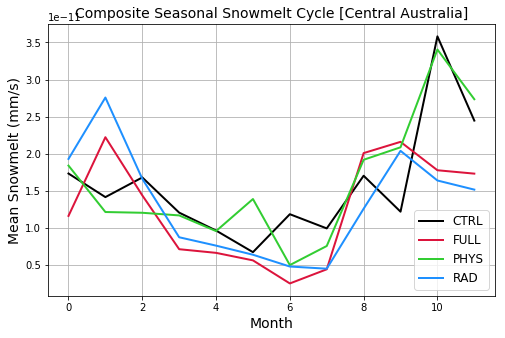

In [36]:
# -- Time series of snowmelt: India -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlMelt_Aus,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullMelt_Aus,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physMelt_Aus,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radMelt_Aus,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Snowmelt Cycle [Central Australia]',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean Snowmelt (mm/s)',fontsize=my_fontsize)
plt.grid()





In [99]:
# # --- Split into each yearly data --- #

# ctrlRunoff_reg1Ann = np.split(ctrlRunoff_reg1,30,axis=0)
# fullRunoff_reg1Ann = np.split(fullRunoff_reg1,30,axis=0)
# physRunoff_reg1Ann = np.split(physRunoff_reg1,30,axis=0)
# radRunoff_reg1Ann  = np.split(radRunoff_reg1,30,axis=0)

# ctrlMelt_reg1Ann   = np.split(ctrlMelt_reg1,30,axis=0)
# fullMelt_reg1Ann   = np.split(fullMelt_reg1,30,axis=0)
# physMelt_reg1Ann   = np.split(physMelt_reg1,30,axis=0)
# radMelt_reg1Ann    = np.split(radMelt_reg1,30,axis=0)

# ctrlPrect_reg1Ann  = np.split(ctrlPrect_reg1,30,axis=0)
# fullPrect_reg1Ann  = np.split(fullPrect_reg1,30,axis=0)
# physPrect_reg1Ann  = np.split(physPrect_reg1,30,axis=0)
# radPrect_reg1Ann   = np.split(radPrect_reg1,30,axis=0)

# ctrlSnow_reg1Ann   = np.split(ctrlSnow_reg1,30,axis=0)
# fullSnow_reg1Ann   = np.split(fullSnow_reg1,30,axis=0)
# physSnow_reg1Ann   = np.split(physSnow_reg1,30,axis=0)
# radSnow_reg1Ann    = np.split(radSnow_reg1,30,axis=0)

# ctrlSoil_reg1Ann   = np.split(ctrlSoil_reg1,30,axis=0)
# fullSoil_reg1Ann   = np.split(fullSoil_reg1,30,axis=0)
# physSoil_reg1Ann   = np.split(physSoil_reg1,30,axis=0)
# radSoil_reg1Ann    = np.split(radSoil_reg1,30,axis=0)


In [100]:
# # --- Take annual mean --- #

# ctrlRunoff_annMean = np.nanmean(ctrlRunoff_regAnn,axis=0)
# fullRunoff_annMean = np.nanmean(fullRunoff_regAnn,axis=0)
# physRunoff_annMean = np.nanmean(physRunoff_regAnn,axis=0)
# radRunoff_annMean  = np.nanmean(radRunoff_regAnn,axis=0)

# ctrlMelt_annMean   = np.nanmean(ctrlMelt_regAnn,axis=0)
# fullMelt_annMean   = np.nanmean(fullMelt_regAnn,axis=0)
# physMelt_annMean   = np.nanmean(physMelt_regAnn,axis=0)
# radMelt_annMean    = np.nanmean(radMelt_regAnn,axis=0)

# ctrlPrect_annMean  = np.nanmean(ctrlPrect_regAnn,axis=0)
# fullPrect_annMean  = np.nanmean(fullPrect_regAnn,axis=0)
# physPrect_annMean  = np.nanmean(physPrect_regAnn,axis=0)
# radPrect_annMean   = np.nanmean(radPrect_regAnn,axis=0)

# ctrlSnow_annMean   = np.nanmean(ctrlSnow_regAnn,axis=0)
# fullSnow_annMean   = np.nanmean(fullSnow_regAnn,axis=0)
# physSnow_annMean   = np.nanmean(physSnow_regAnn,axis=0)
# radSnow_annMean    = np.nanmean(radSnow_regAnn,axis=0)

# ctrlSoil_annMean   = np.nanmean(ctrlSoil_regAnn,axis=0)
# fullSoil_annMean   = np.nanmean(fullSoil_regAnn,axis=0)
# physSoil_annMean   = np.nanmean(physSoil_regAnn,axis=0)
# radSoil_annMean    = np.nanmean(radSoil_regAnn,axis=0)

# # -- Average over space too -- # 
# ctrlRunoff_regMean = np.nanmean(np.nanmean(ctrlRunoff_annMean,axis=2),axis=1)
# fullRunoff_regMean = np.nanmean(np.nanmean(fullRunoff_annMean,axis=2),axis=1)
# physRunoff_regMean = np.nanmean(np.nanmean(physRunoff_annMean,axis=2),axis=1)
# radRunoff_regMean  = np.nanmean(np.nanmean(radRunoff_annMean,axis=2),axis=1)

# ctrlMelt_regMean   = np.nanmean(np.nanmean(ctrlMelt_annMean,axis=2),axis=1)
# fullMelt_regMean   = np.nanmean(np.nanmean(fullMelt_annMean,axis=2),axis=1)
# physMelt_regMean   = np.nanmean(np.nanmean(physMelt_annMean,axis=2),axis=1)
# radMelt_regMean    = np.nanmean(np.nanmean(radMelt_annMean,axis=2),axis=1)

# ctrlPrect_regMean  = np.nanmean(np.nanmean(ctrlPrect_annMean,axis=2),axis=1)
# fullPrect_regMean  = np.nanmean(np.nanmean(fullPrect_annMean,axis=2),axis=1)
# physPrect_regMean  = np.nanmean(np.nanmean(physPrect_annMean,axis=2),axis=1)
# radPrect_regMean   = np.nanmean(np.nanmean(radPrect_annMean,axis=2),axis=1)

# ctrlSnow_regMean   = np.nanmean(np.nanmean(ctrlSnow_annMean,axis=2),axis=1)
# fullSnow_regMean   = np.nanmean(np.nanmean(fullSnow_annMean,axis=2),axis=1)
# physSnow_regMean   = np.nanmean(np.nanmean(physSnow_annMean,axis=2),axis=1)
# radSnow_regMean    = np.nanmean(np.nanmean(radSnow_annMean,axis=2),axis=1)

# ctrlSoil_regMean   = np.nanmean(np.nanmean(ctrlSoil_annMean,axis=2),axis=1)
# fullSoil_regMean   = np.nanmean(np.nanmean(fullSoil_annMean,axis=2),axis=1)
# physSoil_regMean   = np.nanmean(np.nanmean(physSoil_annMean,axis=2),axis=1)
# radSoil_regMean    = np.nanmean(np.nanmean(radSoil_annMean,axis=2),axis=1)


*Make a few plots of annual cycles...*<br><br>

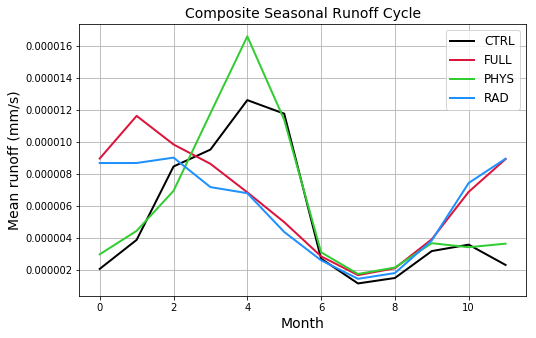

In [80]:
# -- Time series of runoff -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlRunoff_regMean,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullRunoff_regMean,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physRunoff_regMean,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radRunoff_regMean,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Runoff Cycle',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean runoff (mm/s)',fontsize=my_fontsize)
plt.grid()



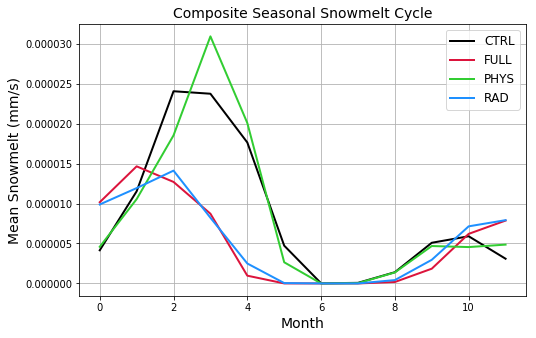

In [84]:
# -- Time series of snowmelt -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlMelt_regMean,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullMelt_regMean,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physMelt_regMean,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radMelt_regMean,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Snowmelt Cycle',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean Snowmelt (mm/s)',fontsize=my_fontsize)
plt.grid()




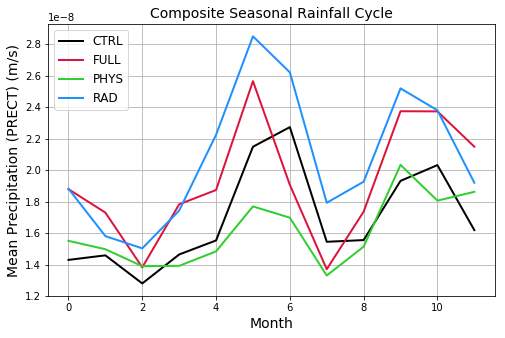

In [89]:
# -- Time series of precipitation (PRECT) -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlPrect_regMean,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullPrect_regMean,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physPrect_regMean,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radPrect_regMean,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Rainfall Cycle',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean Precipitation (PRECT) (m/s)',fontsize=my_fontsize)
plt.grid()


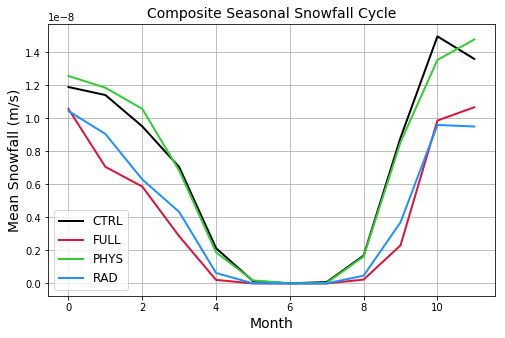

In [95]:
# -- Time series of Snowfall (PRECSC+PRECSL) -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlSnow_regMean,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullSnow_regMean,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physSnow_regMean,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radSnow_regMean,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Snowfall Cycle',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean Snowfall (m/s)',fontsize=my_fontsize)
plt.grid()



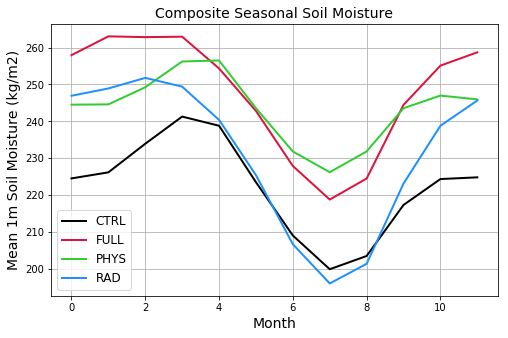

In [101]:
# -- Time series of 1m soil moisture -- # 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up first plot: rainfall changes 
plt.plot(np.arange(12),ctrlSoil_regMean,color ='Black',label='CTRL',linewidth=2)
plt.plot(np.arange(12),fullSoil_regMean,color ='Crimson',label='FULL',linewidth=2)
plt.plot(np.arange(12),physSoil_regMean,color = 'LimeGreen',label='PHYS',linewidth=2)
plt.plot(np.arange(12),radSoil_regMean,color='DodgerBlue',label='RAD',linewidth=2)
plt.legend(fontsize=12)
plt.title('Composite Seasonal Soil Moisture',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Mean 1m Soil Moisture (kg/m2)',fontsize=my_fontsize)
plt.grid()




### Return to plotting

/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/meganfowler/anaconda3/lib/p

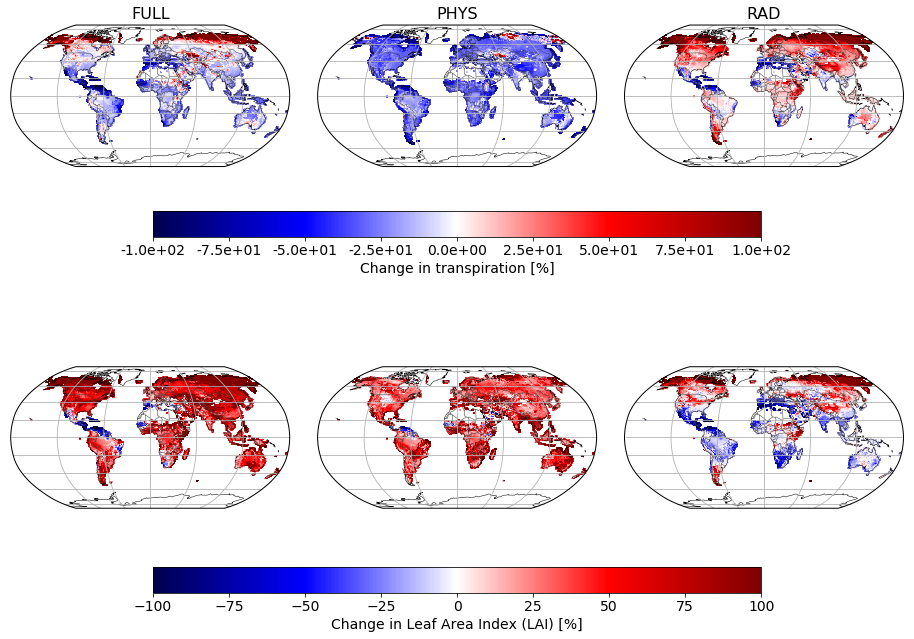

In [21]:
# --- Plot change in transpiration and change in LAI --- # 
#            -------- PERCENT CHANGE -------             #

## --- Set up figure window --- 
fig, ax_array = plt.subplots(2,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3,ax4,ax5,ax6 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

#
# ---- Set 1: Change in transpiration ---- #
#

# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,((fullQvegt_avg-ctrlQvegt_avg)/ctrlQvegt_avg)*100,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Other figure options 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.set_title('FULL',fontsize=16)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,((physQvegt_avg-ctrlQvegt_avg)/ctrlQvegt_avg)*100,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0, ax_position.width+0.3, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,format='%.1e')
cbar.set_label('Change in transpiration [%]',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax2.set_title('PHYS',fontsize=16)

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,((radQvegt_avg-ctrlQvegt_avg)/ctrlQvegt_avg)*100,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Other figure options 
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax3.set_title('RAD',fontsize=16)

#
# ---- Set 2: Change in LAI ---- #
#( fullLAI.values-ctrlLAI.values)

# FULL #
ax4.set_global()
contour_plot = ax4.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((fullLAI.values-ctrlLAI.values),axis=0)/np.nanmean(ctrlLAI.values,axis=0))*100,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Other figure options 
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# PHYS #
ax5.set_global()
contour_plot = ax5.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((physLAI.values-ctrlLAI.values),axis=0)/np.nanmean(ctrlLAI.values,axis=0))*100,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax5.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0, ax_position.width+0.3, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in Leaf Area Index (LAI) [%]',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax5.coastlines(linewidth=0.5,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax6.set_global()
contour_plot = ax6.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,(np.nanmean((radLAI.values-ctrlLAI.values),axis=0)/np.nanmean(ctrlLAI.values,axis=0))*100,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Other figure options 
ax6.coastlines(linewidth=0.5,edgecolor='0.25')
ax6.gridlines()
ax6.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


fig.subplots_adjust(wspace=0.1, hspace=0.1)

#Save figure
fig.savefig('/Users/meganfowler/Documents/Irvine/Flooding/Physiology/Illustrator/Supplement_LAI&transpiration.eps',bbox_inches = 'tight')  #Save figure as pdf vector graphic




/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


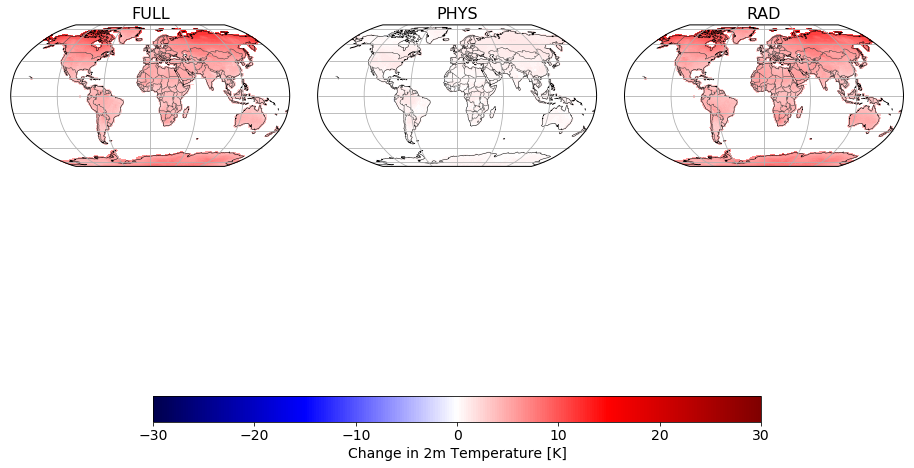

In [10]:
# --- Plot change in transpiration and change in LAI --- # 

## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

#
# ---- Set 1: Change in transpiration ---- #
#

# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((fullTemp.values-ctrlTemp.values),axis=0),cmap='seismic',vmin=-30,vmax=30,transform=ccrs.PlateCarree())
#Other figure options 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.set_title('FULL',fontsize=16)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((physTemp.values-ctrlTemp.values),axis=0),cmap='seismic',vmin=-30,vmax=30,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.15, ax_position.y0, ax_position.width+0.3, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in 2m Temperature [K]',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax2.set_title('PHYS',fontsize=16)

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,np.nanmean((radTemp.values-ctrlTemp.values),axis=0),cmap='seismic',vmin=-30,vmax=30,transform=ccrs.PlateCarree())
#Other figure options 
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax3.set_title('RAD',fontsize=16)


fig.subplots_adjust(wspace=0.1, hspace=0.1)

#Save figure
# fig.savefig('/Users/meganfowler/Documents/Irvine/Flooding/Physiology/Illustrator/Supplement_LAI&transpiration.eps',bbox_inches = 'tight')  #Save figure as pdf vector graphic





## Original figures used to figure out what's going on

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in multiply
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in multiply


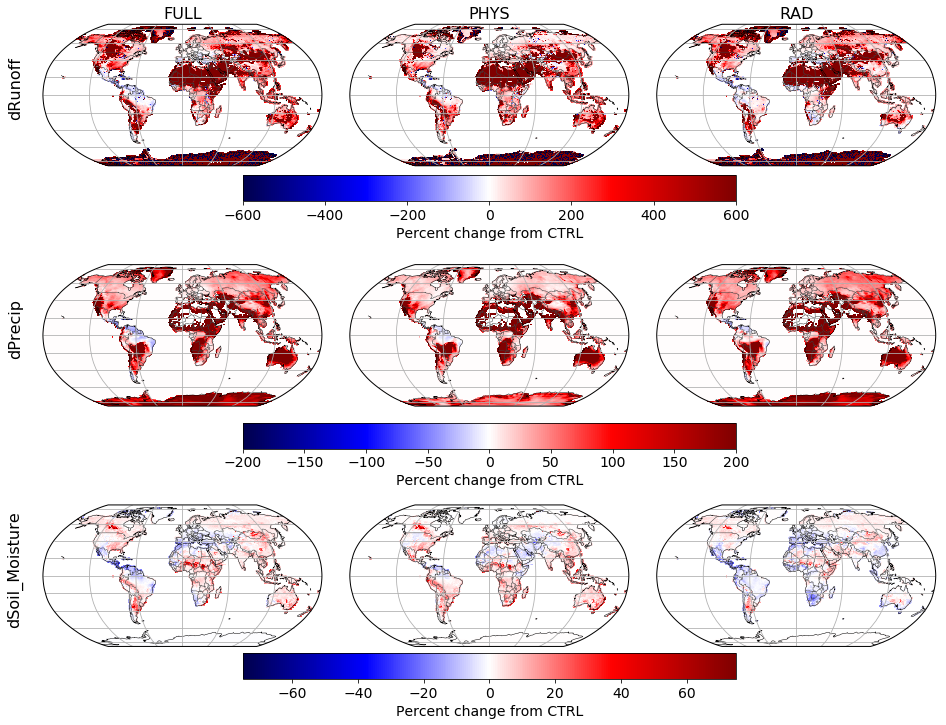

In [40]:
#Make plots 

## --- Set up figure window --- 
fig, ax_array = plt.subplots(3,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

# ---- Set 1: Change in runoff ---- #

# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullRun,cmap='seismic',vmin=-600,vmax=600,transform=ccrs.PlateCarree())
#Other figure options 
ax1.set_title('FULL',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax1.text(-0.07, 0.55, 'dRunoff', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes,fontsize=16)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgPhysRun,cmap='seismic',vmin=-600,vmax=600,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.set_title('PHYS',fontsize=16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRadRun,cmap='seismic',vmin=-600,vmax=600,transform=ccrs.PlateCarree())
#Other figure options 
ax3.set_title('RAD',fontsize=16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#
# ---- Set 2: Change in precip ---- #
#

# FULL #
ax4.set_global()
contour_plot = ax4.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullPrec*landMask,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Other figure options 
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax4.text(-0.07, 0.55, 'dPrecip', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax4.transAxes,fontsize=16)

# PHYS #
ax5.set_global()
contour_plot = ax5.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgPhysPrec*landMask,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax5.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.02, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax5.coastlines(linewidth=0.5,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax6.set_global()
contour_plot = ax6.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRadPrec*landMask,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Other figure options 
ax6.coastlines(linewidth=0.5,edgecolor='0.25')
ax6.gridlines()
ax6.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#
# ---- Set 3: Change in soil moisture ---- #
#

# FULL #
ax7.set_global()
contour_plot = ax7.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullSoil,cmap='seismic',vmin=-75,vmax=75,transform=ccrs.PlateCarree())
#Other figure options 
ax7.coastlines(linewidth=0.5,edgecolor='0.25')
ax7.gridlines()
ax7.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax7.text(-0.07, 0.55, 'dSoil_Moisture', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax7.transAxes,fontsize=16)

# PHYS #
ax8.set_global()
contour_plot = ax8.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgPhysSoil,cmap='seismic',vmin=-75,vmax=75,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax8.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.02, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax8.coastlines(linewidth=0.5,edgecolor='0.25')
ax8.gridlines()
ax8.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax9.set_global()
contour_plot = ax9.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRadSoil,cmap='seismic',vmin=-75,vmax=75,transform=ccrs.PlateCarree())
#Other figure options 
ax9.coastlines(linewidth=0.5,edgecolor='0.25')
ax9.gridlines()
ax9.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


fig.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()


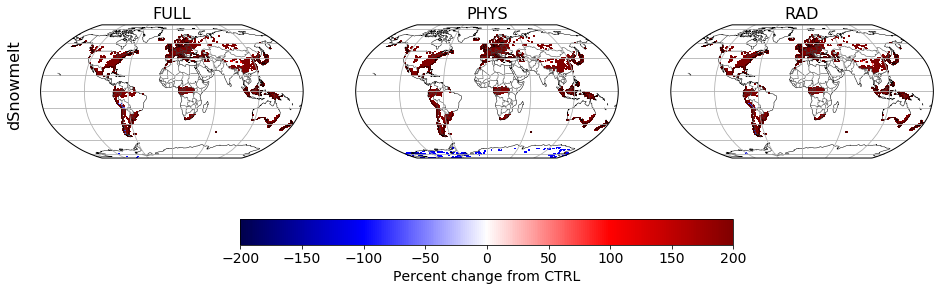

In [25]:
## Change in snow melt 

## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

# ---- Set 1: Change in runoff ---- #

# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullMelt,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Other figure options 
ax1.set_title('FULL',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax1.text(-0.07, 0.55, 'dSnowmelt', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes,fontsize=16)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgPhysMelt,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0+0.2, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.set_title('PHYS',fontsize=16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRadMelt,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Other figure options 
ax3.set_title('RAD',fontsize=16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




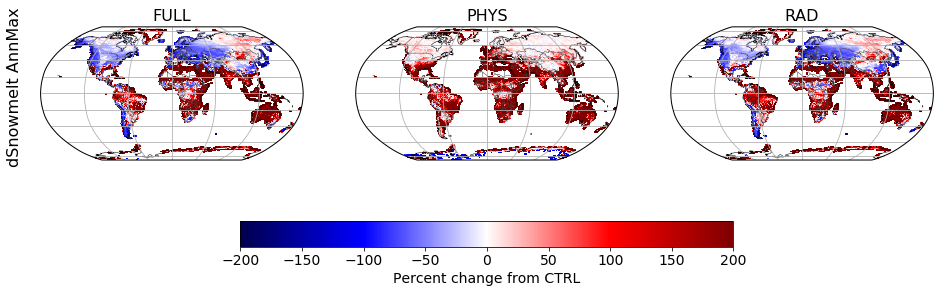

In [10]:
## Change in max or min annual snow melt 

## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullMaxMelt,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Other figure options 
ax1.set_title('FULL',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax1.text(-0.07, 0.55, 'dSnowmelt AnnMax', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes,fontsize=16)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgPhysMaxMelt,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0+0.2, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.set_title('PHYS',fontsize=16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRadMaxMelt,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Other figure options 
ax3.set_title('RAD',fontsize=16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



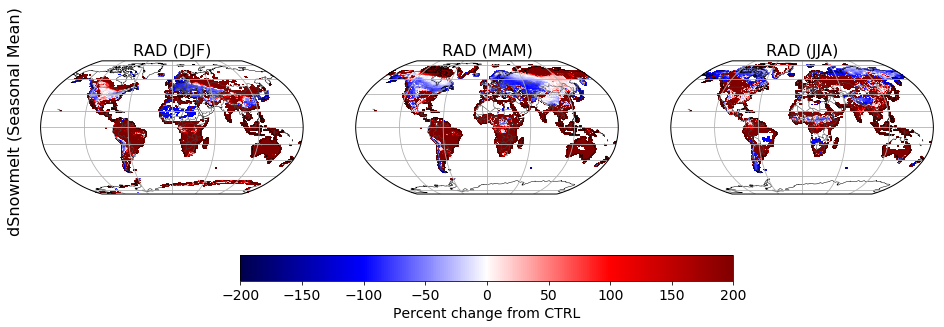

In [86]:
# -- Look at seasonal differences in snowmelt --# 

#   avgFullMelt_DJF

## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,3,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

# FULL #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRadMelt_DJF,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Other figure options 
ax1.set_title('RAD (DJF)',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax1.text(-0.07, 0.55, 'dSnowmelt (Seasonal Mean)', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes,fontsize=16)

# PHYS #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRadMelt_MAM,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0+0.2, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.set_title('RAD (MAM)',fontsize=16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# RAD #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgRadMelt_JJA,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Other figure options 
ax3.set_title('RAD (JJA)',fontsize=16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')







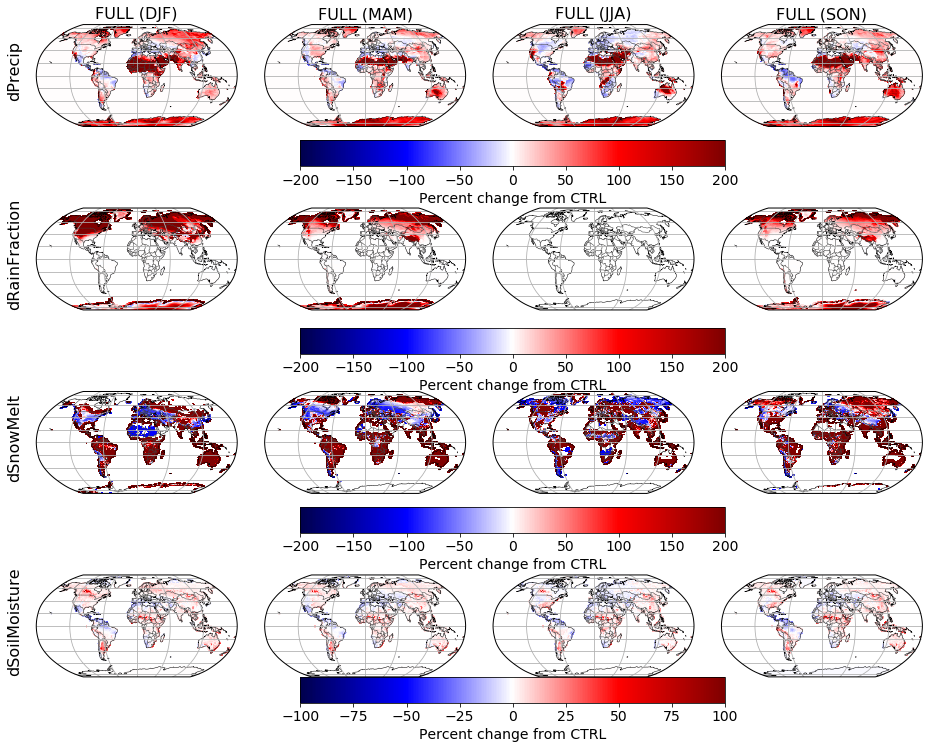

In [20]:
#Seasonal changes in variables for FULL 

## --- Set up figure window --- 
fig, ax_array = plt.subplots(4,4,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)


# ---- Set 1: Change in precip ---- #

maxCprecip  = 200
minCprecip = -maxCprecip

# DJF #
ax1.set_global()
contour_plot = ax1.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullPrecip_DJF*landMask,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Other figure options 
ax1.set_title('FULL (DJF)',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax1.text(-0.07, 0.55, 'dPrecip', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes,fontsize=16)

# MAM #
ax2.set_global()
contour_plot = ax2.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullPrecip_MAM*landMask,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.03, ax_position.y0, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax2.set_title('FULL (MAM)',fontsize=16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# JJA #
ax3.set_global()
contour_plot = ax3.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullPrecip_JJA*landMask,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Other figure options 
ax3.set_title('FULL (JJA)',fontsize=16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# SON #
ax4.set_global()
contour_plot = ax4.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullPrecip_SON*landMask,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Other figure options 
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax4.set_title('FULL (SON)',fontsize=16)


#
# -- Set 2: Rain Fraction -- #
#

# DJF #
ax5.set_global()
contour_plot = ax5.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullRainFrac_DJF*landMask,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Other figure options 
ax5.coastlines(linewidth=0.5,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax5.text(-0.07, 0.55, 'dRainFraction', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax5.transAxes,fontsize=16)

# MAM #
ax6.set_global()
contour_plot = ax6.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullRainFrac_MAM*landMask,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Other figure options 
ax6.coastlines(linewidth=0.5,edgecolor='0.25')
ax6.gridlines()
ax6.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Colorbar options 
ax_position = ax6.get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.03, ax_position.y0-0.02, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# JJA #
ax7.set_global()
contour_plot = ax7.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullRainFrac_JJA*landMask,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Other figure options 
ax7.coastlines(linewidth=0.5,edgecolor='0.25')
ax7.gridlines()
ax7.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# SON #
ax8.set_global()
contour_plot = ax8.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullRainFrac_SON*landMask,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Other figure options 
ax8.coastlines(linewidth=0.5,edgecolor='0.25')
ax8.gridlines()
ax8.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


#
# ---- Set 3: Change in snowmelt---- #
#

# DJF #
ax9.set_global()
contour_plot = ax9.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullMelt_DJF,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Other figure options 
ax9.coastlines(linewidth=0.5,edgecolor='0.25')
ax9.gridlines()
ax9.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax9.text(-0.07, 0.55, 'dSnowMelt', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax9.transAxes,fontsize=16)

# MAM #
ax10.set_global()
contour_plot = ax10.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullMelt_MAM,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax10.get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.03, ax_position.y0-0.03, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax10.coastlines(linewidth=0.5,edgecolor='0.25')
ax10.gridlines()
ax10.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# JJA #
ax11.set_global()
contour_plot = ax11.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullMelt_JJA,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Other figure options 
ax11.coastlines(linewidth=0.5,edgecolor='0.25')
ax11.gridlines()
ax11.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# SON #
ax12.set_global()
contour_plot = ax12.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullMelt_SON,cmap='seismic',vmin=minCprecip,vmax=maxCprecip,transform=ccrs.PlateCarree())
#Other figure options 
ax12.coastlines(linewidth=0.5,edgecolor='0.25')
ax12.gridlines()
ax12.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



#
# ---- Set 4: Change in 1m soil moisture---- #
#

maxCsoil = 100
minCsoil = -100

# DJF #
ax13.set_global()
contour_plot = ax13.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullSoil_DJF,cmap='seismic',vmin=minCsoil,vmax=maxCsoil,transform=ccrs.PlateCarree())
#Other figure options 
ax13.coastlines(linewidth=0.5,edgecolor='0.25')
ax13.gridlines()
ax13.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax13.text(-0.07, 0.55, 'dSoilMoisture', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax13.transAxes,fontsize=16)

# MAM #
ax14.set_global()
contour_plot = ax14.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullSoil_MAM,cmap='seismic',vmin=minCsoil,vmax=maxCsoil,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax14.get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.03, ax_position.y0-0.03, ax_position.width+0.2, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change from CTRL',fontsize=14)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax14.coastlines(linewidth=0.5,edgecolor='0.25')
ax14.gridlines()
ax14.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# JJA #
ax15.set_global()
contour_plot = ax15.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullSoil_JJA,cmap='seismic',vmin=minCsoil,vmax=maxCsoil,transform=ccrs.PlateCarree())
#Other figure options 
ax15.coastlines(linewidth=0.5,edgecolor='0.25')
ax15.gridlines()
ax15.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# SON #
ax16.set_global()
contour_plot = ax16.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,avgFullSoil_SON,cmap='seismic',vmin=minCsoil,vmax=maxCsoil,transform=ccrs.PlateCarree())
#Other figure options 
ax16.coastlines(linewidth=0.5,edgecolor='0.25')
ax16.gridlines()
ax16.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


fig.subplots_adjust(wspace=0.1, hspace=0.8)
plt.show()



## Let's look at seasonal average streamflow maps as well 

In [21]:
# Load monthly averages from file
[avgCtrl,avgFull,avgPhys,avgRad]=np.load('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/MonthlyAverages.pkl')

print(np.shape(avgCtrl))

(30, 12, 720, 1440)


In [24]:
ctrlFlow_DJF = np.asarray(avgCtrl)[:,[11,0,1],:,:]
ctrlFlow_MAM = np.asarray(avgCtrl)[:,[2,3,4],:,:]
ctrlFlow_JJA = np.asarray(avgCtrl)[:,[5,6,7],:,:]
ctrlFlow_SON = np.asarray(avgCtrl)[:,[8,9,10],:,:]
ctrlMeanFlow_DJF = np.nanmean(ctrlFlow_DJF,axis=1)
ctrlMeanFlow_MAM = np.nanmean(ctrlFlow_MAM,axis=1)
ctrlMeanFlow_JJA = np.nanmean(ctrlFlow_JJA,axis=1)
ctrlMeanFlow_SON = np.nanmean(ctrlFlow_SON,axis=1)

fullFlow_DJF = np.asarray(avgFull)[:,[11,0,1],:,:]
fullFlow_MAM = np.asarray(avgFull)[:,[2,3,4],:,:]
fullFlow_JJA = np.asarray(avgFull)[:,[5,6,7],:,:]
fullFlow_SON = np.asarray(avgFull)[:,[8,9,10],:,:]
fullMeanFlow_DJF = np.nanmean(fullFlow_DJF,axis=1)
fullMeanFlow_MAM = np.nanmean(fullFlow_MAM,axis=1)
fullMeanFlow_JJA = np.nanmean(fullFlow_JJA,axis=1)
fullMeanFlow_SON = np.nanmean(fullFlow_SON,axis=1)

# Take difference for each season and average over all years 
diffFullFlow_DJF = ((fullMeanFlow_DJF-ctrlMeanFlow_DJF)/ctrlMeanFlow_DJF)*100
diffFullFlow_MAM = ((fullMeanFlow_MAM-ctrlMeanFlow_MAM)/ctrlMeanFlow_MAM)*100
diffFullFlow_JJA = ((fullMeanFlow_JJA-ctrlMeanFlow_JJA)/ctrlMeanFlow_JJA)*100
diffFullFlow_SON = ((fullMeanFlow_SON-ctrlMeanFlow_SON)/ctrlMeanFlow_SON)*100
avgFullFlow_DJF = np.nanmean(diffFullFlow_DJF,axis=0)
avgFullFlow_MAM = np.nanmean(diffFullFlow_MAM,axis=0)
avgFullFlow_JJA = np.nanmean(diffFullFlow_JJA,axis=0)
avgFullFlow_SON = np.nanmean(diffFullFlow_SON,axis=0)


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid valu

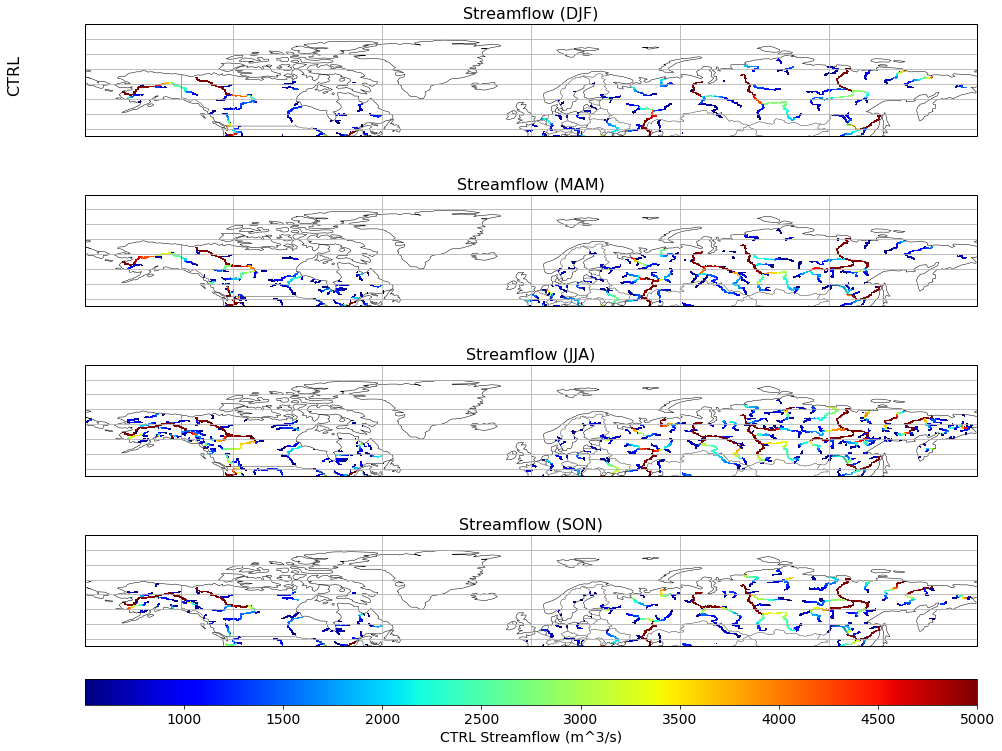

In [50]:
## Change in max or min annual snow melt 

## --- Set up figure window --- 
fig, ax_array = plt.subplots(4,1,subplot_kw={'projection':ccrs.PlateCarree()})
ax1,ax2,ax3,ax4 = ax_array.flatten()
#fig.set_size_inches(11.5,8.5)
fig.set_size_inches(16,12)

#------ ----- ----- -----
# Set 1: CTRL discharge 
#------ ----- ----- -----

#Get just CTRL data 
cutoffMax = 500 

avgCtrlNew_DJF = np.nanmean(ctrlMeanFlow_DJF,axis=0)
avgCtrlNew_DJF[np.where(avgCtrlNew_DJF<=cutoffMax)] = np.nan
avgCtrlNew_MAM = np.nanmean(ctrlMeanFlow_MAM,axis=0)
avgCtrlNew_MAM[np.where(avgCtrlNew_MAM<=cutoffMax)] = np.nan
avgCtrlNew_JJA = np.nanmean(ctrlMeanFlow_JJA,axis=0)
avgCtrlNew_JJA[np.where(avgCtrlNew_JJA<=cutoffMax)] = np.nan
avgCtrlNew_SON = np.nanmean(ctrlMeanFlow_SON,axis=0)
avgCtrlNew_SON[np.where(avgCtrlNew_SON<=cutoffMax)] = np.nan

# DJF #
ax1.set_extent([-180,80,45,90])
contour_plot = ax1.pcolormesh(lon,lat,avgCtrlNew_DJF,cmap='jet',vmax=5000)
#Other figure options 
ax1.set_title('Streamflow (DJF)',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Add ylabel
ax1.text(-0.07, 0.55, 'CTRL', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes,fontsize=16)

# MAM #
ax2.set_extent([-180,80,45,90])
contour_plot = ax2.pcolormesh(lon,lat,avgCtrlNew_MAM,cmap='jet',vmax=5000)
#Other figure options 
ax2.set_title('Streamflow (MAM)',fontsize=16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# JJA #
ax3.set_extent([-180,80,45,90])
contour_plot = ax3.pcolormesh(lon,lat,avgCtrlNew_JJA,cmap='jet',vmax=5000)
#Other figure options 
ax3.set_title('Streamflow (JJA)',fontsize=16)
ax3.coastlines(linewidth=0.5,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# SON #
ax4.set_extent([-180,80,45,90])
contour_plot = ax4.pcolormesh(lon,lat,avgCtrlNew_SON,cmap='jet',vmax=5000)
#Other figure options 
ax4.set_title('Streamflow (SON)',fontsize=16)
ax4.coastlines(linewidth=0.5,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#Colorbar options 
ax_position = ax4.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('CTRL Streamflow (m^3/s)',fontsize=14)
cbar.ax.tick_params(labelsize=14)



# #------ ----- ----- ----- -----
# # Set 2: FULL-CTRL discharge 
# #------ ----- ----- ----- -----

# # DJF #
# ax5.set_extent([-180,80,45,90])
# contour_plot = ax5.pcolormesh(lon,lat,avgFullFlow_DJF,cmap='seismic',vmin=-100,vmax=100)
# #Other figure options 
# ax5.coastlines(linewidth=0.5,edgecolor='0.25')
# ax5.gridlines()
# ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# #Add ylabel
# ax5.text(-0.07, 0.55, 'FULL-CTRL (%)', va='bottom', ha='center',
#         rotation='vertical', rotation_mode='anchor',
#         transform=ax5.transAxes,fontsize=16)

# # MAM #
# ax6.set_extent([-180,80,45,90])
# contour_plot = ax6.pcolormesh(lon,lat,avgFullFlow_MAM,cmap='seismic',vmin=-100,vmax=100)
# #Other figure options 
# ax6.coastlines(linewidth=0.5,edgecolor='0.25')
# ax6.gridlines()
# ax6.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# #Colorbar options 
# ax_position = ax6.get_position()
# cbar_ax = fig.add_axes([ax_position.x0+0.03, ax_position.y0+0.05, ax_position.width+0.2, 0.03])
# cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
# cbar.set_label('% Change from CTRL',fontsize=14)
# cbar.ax.tick_params(labelsize=14)

# # JJA #
# ax7.set_extent([-180,80,45,90])
# contour_plot = ax7.pcolormesh(lon,lat,avgFullFlow_JJA,cmap='seismic',vmin=-100,vmax=100)
# #Other figure options 
# ax7.coastlines(linewidth=0.5,edgecolor='0.25')
# ax7.gridlines()
# ax7.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# # SON #
# ax8.set_extent([-180,80,45,90])
# contour_plot = ax8.pcolormesh(lon,lat,avgFullFlow_SON,cmap='seismic',vmin=-100,vmax=100)
# #Other figure options 
# ax8.coastlines(linewidth=0.5,edgecolor='0.25')
# ax8.gridlines()
# ax8.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# fig.subplots_adjust(wspace=0.1, hspace=0)


## Probably stupid attempts at plotting a lot of data on one thing 

In [204]:
mon=1
iMon = mon-1

ctrlRunoff = np.nanmean(annRunoffCtrl[:,iMon,:,:],axis=0)   #Avg runoff
fullRunoff = np.nanmean(annRunoffFull[:,iMon,:,:],axis=0)   
physRunoff = np.nanmean(annRunoffPhys[:,iMon,:,:],axis=0)   
radRunoff = np.nanmean(annRunoffRad[:,iMon,:,:],axis=0)   

ctrlSoil = np.nanmean(annSoilCtrl[:,iMon,:,:],axis=0)   #Avg 1m soil moisture
fullSoil = np.nanmean(annSoilFull[:,iMon,:,:],axis=0)   
physSoil = np.nanmean(annSoilPhys[:,iMon,:,:],axis=0)   
radSoil = np.nanmean(annSoilRad[:,iMon,:,:],axis=0) 


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path

In [205]:
np.shape(ctrlRunoff)

(192, 288)

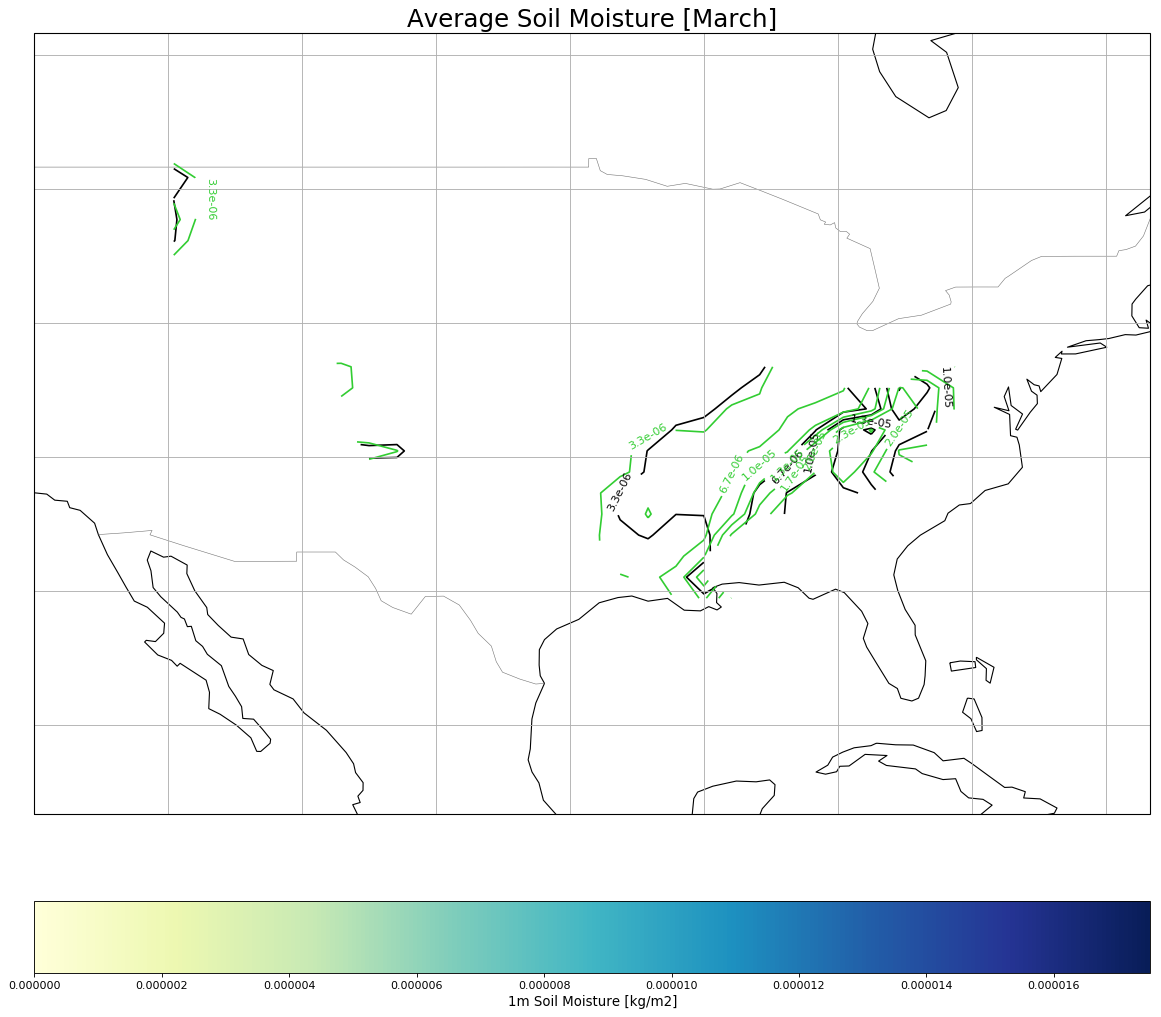

In [236]:
#Set basic plot options 
fig=plt.figure(figsize=(18, 15), dpi= 80, facecolor='w', edgecolor='k')
## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-120,-70,20,55], crs=ccrs.PlateCarree())   ## NOTE: this is centered on US for the Mississippi

#Contour intervals
cRunoff = np.linspace(0,3e-5,10)

contour_Ctrl = ax.contour(cesmLon,cesmLat,ctrlRunoff,cRunoff,transform=ccrs.PlateCarree(),colors='k')
plt.clabel(contour_Ctrl, inline=1, fontsize=10,fmt='%1.1e')
contour_Phys = ax.contour(cesmLon,cesmLat,physRunoff,cRunoff,transform=ccrs.PlateCarree(),colors='LimeGreen')
plt.clabel(contour_Phys, inline=1, fontsize=10,fmt='%1.1e')

#Colorbar options 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('1m Soil Moisture [kg/m2]',fontsize=12)
#Other figure options 
ax.set_title('Average Soil Moisture [March]')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=1,edgecolor='0.45')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')
plt.show() 



## For certain basins (i.e., Parana) break the basin into two and assess time-series averages in each 

In [244]:
np.shape(annRunoffCtrl)

var = '1m soil moisture'

#For each variable, create plot and define colorbar label and filename to save fig as
if var=='Runoff':
    monAvgCtrl = np.nanmean(annRunoffCtrl,axis=0)
    monAvgFull = np.nanmean(annRunoffFull,axis=0)
    monAvgPhys = np.nanmean(annRunoffPhys,axis=0)
    monAvgRad  = np.nanmean(annRunoffRad,axis=0)
# elif var=='1m soil moisture difference': ## Only valid for PHYS and RAD cases 
elif var=='Precip':
    monAvgCtrl = np.nanmean(annPrecipCtrl,axis=0)
    monAvgFull = np.nanmean(annPrecipFull,axis=0)
    monAvgPhys = np.nanmean(annPrecipPhys,axis=0)
    monAvgRad  = np.nanmean(annPrecipRad,axis=0) 
# elif var=='Rainfall':
elif var=='1m soil moisture':
    monAvgCtrl = np.nanmean(annSoilCtrl,axis=0)
    monAvgFull = np.nanmean(annSoilFull,axis=0)
    monAvgPhys = np.nanmean(annSoilPhys,axis=0)
    monAvgRad  = np.nanmean(annSoilRad,axis=0) 
elif var=='Fraction':   #Runoff:Precip fraction
    monAvgCtrl = np.nanmean((annRunoffCtrl/(annPrecipCtrl*1000)),axis=0) #Convert precipitation from m/s to mm/s
    monAvgFull = np.nanmean((annRunoffFull/(annPrecipFull*1000)),axis=0) #Convert precipitation from m/s to mm/s
    monAvgPhys = np.nanmean((annRunoffPhys/(annPrecipPhys*1000)),axis=0) #Convert precipitation from m/s to mm/s
    monAvgRad  = np.nanmean((annRunoffRad/(annPrecipRad*1000)),axis=0) #Convert precipitation from m/s to mm/s

# elif var=='Precipitation difference': ## Only valid for PHYS and RAD cases 
    
#  Dimensions are in the order year x lat x lon
#np.shape(monAvgCtrl)



/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


In [245]:
## Try split based on baseline soil moisture instead
#        Define on monthly basis instead 

#Define soil moisture averages for each location in CTRL
ctrlSoil = np.nanmean(annSoilCtrl,axis=0)

#Mask of where average soil moisture exceeds (maskHigh)/does not exceed (maskLow) the 75% threshold in CTRL
maskHigh = np.zeros([12,len(cesmLat),len(cesmLon)],dtype=int)  #Match dims to monthly average arrays 
maskLow  = np.zeros([12,len(cesmLat),len(cesmLon)],dtype=int)
val25    = np.full([12],np.nan)

for iMon in range(12):
    monSoil = ctrlSoil[iMon,:,:]
    val25[iMon] = np.nanpercentile(monSoil[:],75) #Value of 25th percentile 

    for ilon in range(len(cesmLon)):
        for ilat in range(len(cesmLat)):
            if monSoil[ilat,ilon]>=val25[iMon]:
                maskHigh[iMon,ilat,ilon]=1 
            else:
                maskLow[iMon,ilat,ilon]=1

#Areas of regions with highest soil moisture / everywhere else            
areaHigh = cesmArea*maskHigh[0,:,:]
areaLow  = cesmArea*maskLow[0,:,:]

## -- Define variables in high vs. low soil moisture
highCtrl = monAvgCtrl*maskHigh
highFull = monAvgFull*maskHigh
highPhys = monAvgPhys*maskHigh
highRad  = monAvgRad*maskHigh

lowCtrl = monAvgCtrl*maskLow
lowFull = monAvgFull*maskLow
lowPhys = monAvgPhys*maskLow
lowRad  = monAvgRad*maskLow

## --  Take area weighted averages 

#Define empty arrays 
wgtCtrlHigh = np.full([12],np.nan)
wgtCtrlLow = np.full([12],np.nan)

wgtFullHigh  = np.full([12],np.nan)
wgtFullLow = np.full([12],np.nan)

wgtPhysHigh  = np.full([12],np.nan)
wgtPhysLow = np.full([12],np.nan)

wgtRadHigh   = np.full([12],np.nan)
wgtRadLow  = np.full([12],np.nan)

#Area weight those
for iMon in range(12):
    wgtCtrlHigh[iMon]  = np.nansum(np.nansum(areaHigh*highCtrl[iMon,:,:]))/np.nansum(np.nansum(areaHigh))
    wgtCtrlLow[iMon] = np.nansum(np.nansum(areaLow*lowCtrl[iMon,:,:]))/np.nansum(np.nansum(areaLow))
    
    wgtFullHigh[iMon]  = np.nansum(np.nansum(areaHigh*highFull[iMon,:,:]))/np.nansum(np.nansum(areaHigh))
    wgtFullLow[iMon] = np.nansum(np.nansum(areaLow*lowFull[iMon,:,:]))/np.nansum(np.nansum(areaLow))
    
    wgtPhysHigh[iMon]  = np.nansum(np.nansum(areaHigh*highPhys[iMon,:,:]))/np.nansum(np.nansum(areaHigh))
    wgtPhysLow[iMon] = np.nansum(np.nansum(areaLow*lowPhys[iMon,:,:]))/np.nansum(np.nansum(areaLow))
    
    wgtRadHigh[iMon]   = np.nansum(np.nansum(areaHigh*highRad[iMon,:,:]))/np.nansum(np.nansum(areaHigh))
    wgtRadLow[iMon]  = np.nansum(np.nansum(areaLow*lowRad[iMon,:,:]))/np.nansum(np.nansum(areaLow))
    


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [ ]:
# ## Try split based on baseline soil moisture instead

# #Define soil moisture averages for each location in CTRL
# ctrlSoil = np.nanmean(np.nanmean(annSoilCtrl,axis=0),axis=0)

# #Value of the 25th percentile 
# val25 = np.nanpercentile(ctrlSoil[:],75)

# #Mask of where average soil moisture exceeds (maskHigh)/does not exceed (maskLow) the 75% threshold in CTRL
# #maskHigh = np.full([len(cesmLat),len(cesmLon)],np.nan)
# #maskLow = np.full([len(cesmLat),len(cesmLon)],np.nan)

# maskHigh = np.zeros([12,len(cesmLat),len(cesmLon)],dtype=int)  #Match dims to monthly average arrays 
# maskLow  = np.zeros([12,len(cesmLat),len(cesmLon)],dtype=int)

# for ilon in range(len(cesmLon)):
#     for ilat in range(len(cesmLat)):
#         if ctrlSoil[ilat,ilon]>=val25:
#             maskHigh[:,ilat,ilon]=1 
#         else:
#             maskLow[:,ilat,ilon]=1

# #Areas of regions with highest soil moisture / everywhere else            
# areaHigh = cesmArea*maskHigh[0,:,:]
# areaLow  = cesmArea*maskLow[0,:,:]

# ## -- Define variables in high vs. low soil moisture
# highCtrl = monAvgCtrl*maskHigh
# highFull = monAvgFull*maskHigh
# highPhys = monAvgPhys*maskHigh
# highRad  = monAvgRad*maskHigh

# lowCtrl = monAvgCtrl*maskLow
# lowFull = monAvgFull*maskLow
# lowPhys = monAvgPhys*maskLow
# lowRad  = monAvgRad*maskLow

# ## --  Take area weighted averages 

# #Define empty arrays 
# wgtCtrlHigh = np.full([12],np.nan)
# wgtCtrlLow = np.full([12],np.nan)

# wgtFullHigh  = np.full([12],np.nan)
# wgtFullLow = np.full([12],np.nan)

# wgtPhysHigh  = np.full([12],np.nan)
# wgtPhysLow = np.full([12],np.nan)

# wgtRadHigh   = np.full([12],np.nan)
# wgtRadLow  = np.full([12],np.nan)

# #Area weight those
# for iMon in range(12):
#     wgtCtrlHigh[iMon]  = np.nansum(np.nansum(areaHigh*highCtrl[iMon,:,:]))/np.nansum(np.nansum(areaHigh))
#     wgtCtrlLow[iMon] = np.nansum(np.nansum(areaLow*lowCtrl[iMon,:,:]))/np.nansum(np.nansum(areaLow))
    
#     wgtFullHigh[iMon]  = np.nansum(np.nansum(areaHigh*highFull[iMon,:,:]))/np.nansum(np.nansum(areaHigh))
#     wgtFullLow[iMon] = np.nansum(np.nansum(areaLow*lowFull[iMon,:,:]))/np.nansum(np.nansum(areaLow))
    
#     wgtPhysHigh[iMon]  = np.nansum(np.nansum(areaHigh*highPhys[iMon,:,:]))/np.nansum(np.nansum(areaHigh))
#     wgtPhysLow[iMon] = np.nansum(np.nansum(areaLow*lowPhys[iMon,:,:]))/np.nansum(np.nansum(areaLow))
    
#     wgtRadHigh[iMon]   = np.nansum(np.nansum(areaHigh*highRad[iMon,:,:]))/np.nansum(np.nansum(areaHigh))
#     wgtRadLow[iMon]  = np.nansum(np.nansum(areaLow*lowRad[iMon,:,:]))/np.nansum(np.nansum(areaLow))
    



In [240]:
val25

array([257.36450818, 263.5488327 , 266.92197088, 267.06378326,
       257.44551048, 243.95645053, 229.00117455, 215.5124822 ,
       215.50221291, 223.52270533, 240.48161201, 253.43109639])

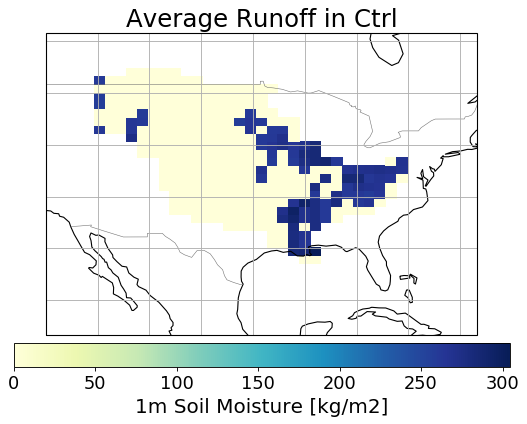

In [246]:
#Set basic plot options 
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-120,-70,20,55], crs=ccrs.PlateCarree())   ## NOTE: this is centered on US for the Mississippi
#ax.set_extent([-20,25,-10,30], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Niger River 
#ax.set_extent([-90,-20,-50,-10], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Parana River 

contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,highCtrl[0,:,:],cmap='YlGnBu',transform=ccrs.PlateCarree())

#Colorbar options 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('1m Soil Moisture [kg/m2]',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Average Runoff in Ctrl')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=1,edgecolor='0.45')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')
plt.show() 




In [131]:
print('Low: ',wgtCtrlLow)
print()
print('High: ', wgtCtrlHigh)

Low:  [2.99777139 3.01627234 3.05164257 2.94415191 2.77091414 2.64220911
 2.56808398 2.50993436 2.46945176 2.60504688 2.81743244 2.98270129]

High:  [294.01903587 294.7066171  292.80369991 284.07667123 276.85055574
 270.95954413 267.44570868 262.61594187 257.73788566 265.72097383
 277.50702239 289.78258945]


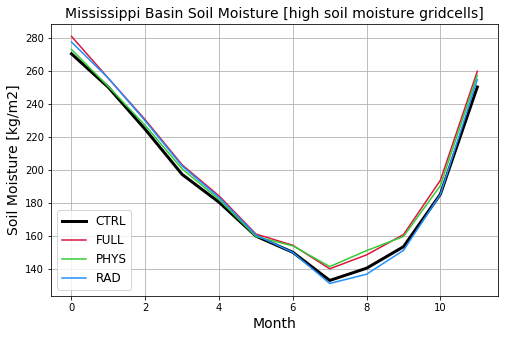

In [251]:
## -- Plot time series 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up plot 
plt.plot(np.arange(12),wgtCtrlHigh,color ='Black',label='CTRL',linewidth=3)
plt.plot(np.arange(12),wgtFullHigh,color ='Crimson',label='FULL')
plt.plot(np.arange(12),wgtPhysHigh,color = 'LimeGreen',label='PHYS')
plt.plot(np.arange(12),wgtRadHigh,color='DodgerBlue',label='RAD')
plt.legend(fontsize=12)
plt.title(basinNames[basinChoice-1]+ ' Basin Soil Moisture [high soil moisture gridcells]',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Soil Moisture [kg/m2]',fontsize=my_fontsize)
plt.grid()


(2, 5)

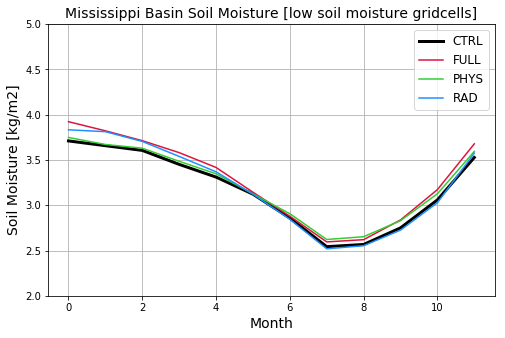

In [252]:
## -- Plot time series 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up plot 
plt.plot(np.arange(12),wgtCtrlLow,color ='Black',label='CTRL',linewidth=3)
plt.plot(np.arange(12),wgtFullLow,color ='Crimson',label='FULL')
plt.plot(np.arange(12),wgtPhysLow,color = 'LimeGreen',label='PHYS')
plt.plot(np.arange(12),wgtRadLow,color='DodgerBlue',label='RAD')
plt.legend(fontsize=12)
plt.title(basinNames[basinChoice-1]+ ' Basin Soil Moisture [low soil moisture gridcells]',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Soil Moisture [kg/m2]',fontsize=my_fontsize)
plt.grid()
plt.ylim(2, 5)

In [142]:
## -- Split into two sections 
ilonLeft  = np.where(cesmLon<300)   #Parana: split at -60˚, which is really 300˚
ilonRight = np.where(cesmLon>=300)

# Define left vs right variables (and areas)
leftCtrl = monAvgCtrl[:,:,ilonLeft[0][:]]
leftFull = monAvgFull[:,:,ilonLeft[0][:]]
leftPhys = monAvgPhys[:,:,ilonLeft[0][:]]
leftRad  = monAvgRad[:,:,ilonLeft[0][:]]
cesmAreaLeft = cesmArea[:,ilonLeft[0][:]]

rightCtrl = monAvgCtrl[:,:,ilonRight[0][:]]
rightFull = monAvgFull[:,:,ilonRight[0][:]]
rightPhys = monAvgPhys[:,:,ilonRight[0][:]]
rightRad  = monAvgRad[:,:,ilonRight[0][:]]
cesmAreaRight = cesmArea[:,ilonRight[0][:]]


In [143]:
## --  Take area weighted averages 

#Define empty arrays 
wgtCtrlLeft = np.full([12],np.nan)
wgtCtrlRight = np.full([12],np.nan)

wgtFullLeft  = np.full([12],np.nan)
wgtFullRight = np.full([12],np.nan)

wgtPhysLeft  = np.full([12],np.nan)
wgtPhysRight = np.full([12],np.nan)

wgtRadLeft   = np.full([12],np.nan)
wgtRadRight  = np.full([12],np.nan)

#Area weight those
for iMon in range(12):
    wgtCtrlLeft[iMon]  = np.nansum(np.nansum(cesmAreaLeft*leftCtrl[iMon,:,:]))/np.nansum(np.nansum(cesmAreaLeft))
    wgtCtrlRight[iMon] = np.nansum(np.nansum(cesmAreaRight*rightCtrl[iMon,:,:]))/np.nansum(np.nansum(cesmAreaRight))
    
    wgtFullLeft[iMon]  = np.nansum(np.nansum(cesmAreaLeft*leftFull[iMon,:,:]))/np.nansum(np.nansum(cesmAreaLeft))
    wgtFullRight[iMon] = np.nansum(np.nansum(cesmAreaRight*rightFull[iMon,:,:]))/np.nansum(np.nansum(cesmAreaRight))
    
    wgtPhysLeft[iMon]  = np.nansum(np.nansum(cesmAreaLeft*leftPhys[iMon,:,:]))/np.nansum(np.nansum(cesmAreaLeft))
    wgtPhysRight[iMon] = np.nansum(np.nansum(cesmAreaRight*rightPhys[iMon,:,:]))/np.nansum(np.nansum(cesmAreaRight))
    
    wgtRadLeft[iMon]   = np.nansum(np.nansum(cesmAreaLeft*leftRad[iMon,:,:]))/np.nansum(np.nansum(cesmAreaLeft))
    wgtRadRight[iMon]  = np.nansum(np.nansum(cesmAreaRight*rightRad[iMon,:,:]))/np.nansum(np.nansum(cesmAreaRight))
    

/home/mdfowler/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


(0, 0.2)

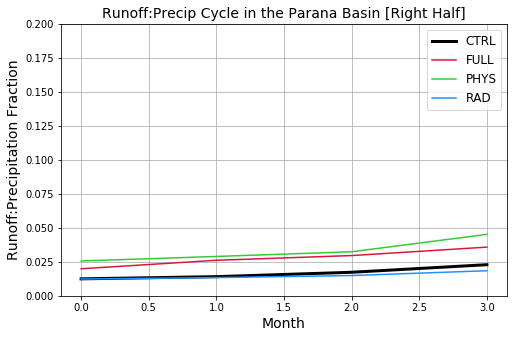

In [156]:
## -- Plot time series 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 14
#Set up plot 
plt.plot(np.arange(12),wgtCtrlLeft,color ='Black',label='CTRL',linewidth=3)
plt.plot(np.arange(12),wgtFullLeft,color ='Crimson',label='FULL')
plt.plot(np.arange(12),wgtPhysLeft,color = 'LimeGreen',label='PHYS')
plt.plot(np.arange(12),wgtRadLeft,color='DodgerBlue',label='RAD')
plt.legend(fontsize=12)
plt.title('Runoff:Precip Cycle in the '+basinNames[basinChoice-1]+ ' Basin [Left Half]',fontsize=my_fontsize)
plt.xlabel('Month',fontsize=my_fontsize)
plt.ylabel('Runoff:Precipitation Fraction',fontsize=my_fontsize)
plt.grid()
plt.ylim([0,1])

# #Zoom to first four months for fraction 
# plt.plot(np.arange(4),wgtCtrlRight[0:4],color ='Black',label='CTRL',linewidth=3)
# plt.plot(np.arange(4),wgtFullRight[0:4],color ='Crimson',label='FULL')
# plt.plot(np.arange(4),wgtPhysRight[0:4],color = 'LimeGreen',label='PHYS')
# plt.plot(np.arange(4),wgtRadRight[0:4],color='DodgerBlue',label='RAD')
# plt.legend(fontsize=12)
# plt.title('Runoff:Precip Cycle in the '+basinNames[basinChoice-1]+ ' Basin [Right Half]',fontsize=my_fontsize)
# plt.xlabel('Month',fontsize=my_fontsize)
# plt.ylabel('Runoff:Precipitation Fraction',fontsize=my_fontsize)
# plt.grid()
# plt.ylim([0,0.2])




(12,)

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


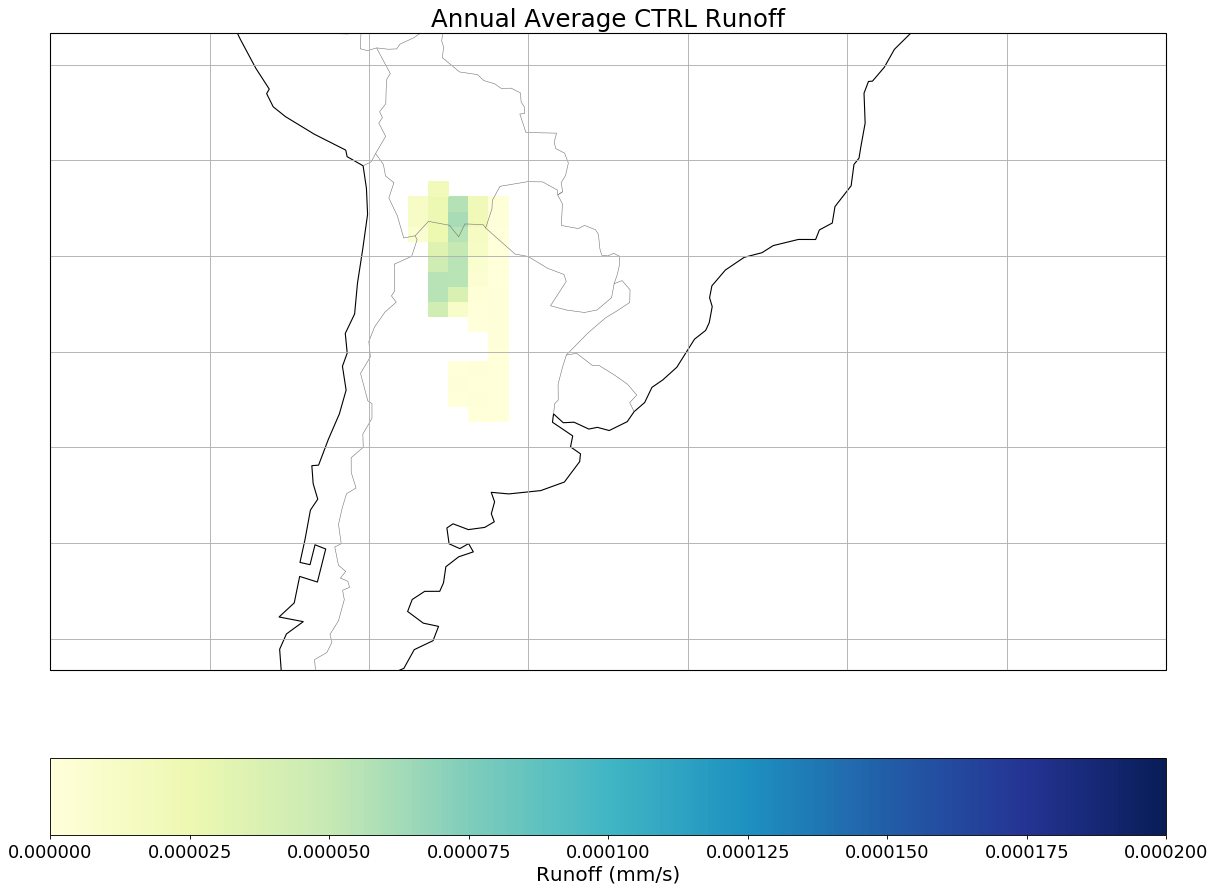

In [116]:
## -- Plot to check the split is what was wanted  -- 

#Set basic plot options 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#ax.set_extent([-120,-70,20,55], crs=ccrs.PlateCarree())   ## NOTE: this is centered on US for the Mississippi
#ax.set_extent([-20,25,-10,30], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Niger River 
ax.set_extent([-90,-20,-50,-10], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Parana River 
#ax.set_extent([10,70,25,75], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Volga River 

contour_plot = ax.pcolormesh(cesmLon[ilonLeft[0][:]],cesmLat,np.nanmean(leftCtrl,axis=0),cmap='YlGnBu',vmin=0,vmax=20e-5,transform=ccrs.PlateCarree())
#Colorbar options 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Runoff (mm/s)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Annual Average CTRL Runoff')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=1,edgecolor='0.45')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')
plt.show() 





## Julian day of maximum annual streamflow 

In [5]:
print('Original shape of array: ', np.shape(outflwCtrl))

#Split up into 30-years of data 
ctrlSplit = np.split(outflwCtrl.values,30,axis=1)
fullSplit = np.split(outflwFull.values,30,axis=1) 
physSplit = np.split(outflwPhys.values,30,axis=1)
radSplit  = np.split(outflwRad.values,30,axis=1)
print('New shape of array after splitting: ', np.shape(ctrlSplit))


Original shape of array:  (10676, 10950)
New shape of array after splitting:  (30, 10676, 365)


In [6]:
#Compute annual climatology 
ctrlAvg = np.nanmean(ctrlSplit,axis=0)
fullAvg = np.nanmean(fullSplit,axis=0) 
physAvg = np.nanmean(physSplit,axis=0)
radAvg  = np.nanmean(radSplit,axis=0)


In [7]:
#Find index of maximum river outflow at every location 
imaxCtrl = np.argmax(ctrlAvg,axis=1)
imaxFull = np.argmax(fullAvg,axis=1)
imaxPhys = np.argmax(physAvg,axis=1)
imaxRad  = np.argmax(radAvg,axis=1)

# print('Sanity Check:')
# print('Index of maximum returned for location 0: ', imaxCtrl[0])
# print('Value of outflow at that index:           ', ctrlAvg[0,imaxCtrl[0]])
# print('Max using np.nanmax at that location:     ', np.nanmax(ctrlAvg[0,:]))


In [8]:
## -- Assign values of max Julian day back into lat x lon array -- 

#Define empty arrays 
global_iMaxCtrl = np.full([len(lat),len(lon)],np.nan)
global_iMaxFull = np.full([len(lat),len(lon)],np.nan)
global_iMaxPhys = np.full([len(lat),len(lon)],np.nan)
global_iMaxRad  = np.full([len(lat),len(lon)],np.nan)

#Fill in river network 
for inp in range(len(lonSubset)):
    ilon = int(lonSubset[inp])
    ilat = int(latSubset[inp])
    
    global_iMaxCtrl[ilat,ilon] = imaxCtrl[inp]
    global_iMaxFull[ilat,ilon] = imaxFull[inp]
    global_iMaxPhys[ilat,ilon] = imaxPhys[inp]
    global_iMaxRad[ilat,ilon]  = imaxRad[inp]


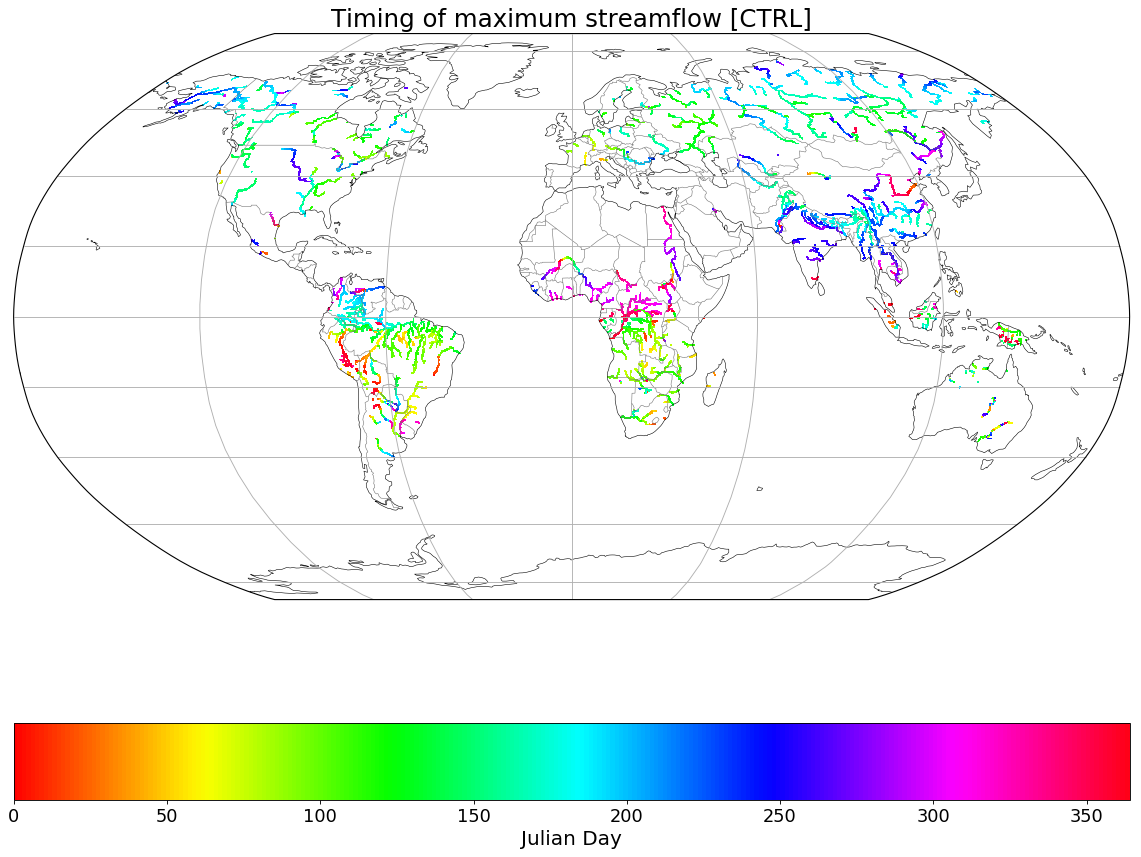

In [43]:
# --- Plot mean julian day of max discharge --- #

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,global_iMaxCtrl,cmap='hsv',transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Julian Day',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Timing of maximum streamflow [CTRL]')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.45')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')

plt.show() 

#Save the image 
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/JulianDayMaxOutflw_CTRL.jpg'
fig.savefig(fileName)  #HOW TO SAVE FIGURES 


In [9]:
# -- Compute difference in julian day -- #

diffTimingFull = global_iMaxFull-global_iMaxCtrl
diffTimingPhys = global_iMaxPhys-global_iMaxCtrl
diffTimingRad  = global_iMaxRad-global_iMaxCtrl

for ilon in range(len(lon)):
    for ilat in range(len(lat)):
        #Check if the difference is more than half a year (in which case, it can be better calculated)
        if diffTimingFull[ilat,ilon]>182:
            diffTimingFull[ilat,ilon] = 365-diffTimingFull[ilat,ilon]
        elif diffTimingFull[ilat,ilon]<(-182):
            diffTimingFull[ilat,ilon] = np.abs(diffTimingFull[ilat,ilon])-365
        
        if diffTimingPhys[ilat,ilon]>182:
            diffTimingPhys[ilat,ilon] = 365-diffTimingPhys[ilat,ilon]
        elif diffTimingPhys[ilat,ilon]<(-182):
            diffTimingPhys[ilat,ilon] = np.abs(diffTimingPhys[ilat,ilon])-365
            
        if diffTimingRad[ilat,ilon]>182:
            diffTimingRad[ilat,ilon] = 365-diffTimingRad[ilat,ilon]
        elif diffTimingRad[ilat,ilon]<(-182):
            diffTimingRad[ilat,ilon] = np.abs(diffTimingRad[ilat,ilon])-365



In [11]:
# Allow for option to overlay certain basin outlines 
mississippi = np.full([len(lon),len(lat)],np.nan)
amazonas    = np.full([len(lon),len(lat)],np.nan)
parana      = np.full([len(lon),len(lat)],np.nan)
volga       = np.full([len(lon),len(lat)],np.nan)
mekong      = np.full([len(lon),len(lat)],np.nan)
mekongCESM  = np.full([len(cesmLon),len(cesmLat)],np.nan)
tocantins   = np.full([len(lon),len(lat)],np.nan)
ganges      = np.full([len(lon),len(lat)],np.nan)
niger       = np.full([len(lon),len(lat)],np.nan)
congo       = np.full([len(lon),len(lat)],np.nan)
danube       = np.full([len(lon),len(lat)],np.nan)

mississippi[np.where(basinMask==5)]=1
amazonas[np.where(basinMask==17)]=2
parana[np.where(basinMask==16)]=3
volga[np.where(basinMask==10)]=4
mekong[np.where(basinMask==25)]=5
tocantins[np.where(basinMask==31)]=6
ganges[np.where(basinMask==24)]=7
niger[np.where(basinMask==18)]=8
congo[np.where(basinMask==19)]=9
danube[np.where(basinMask==8)]=10

mekongCESM[np.where(basinMask_CESM==25)]=5


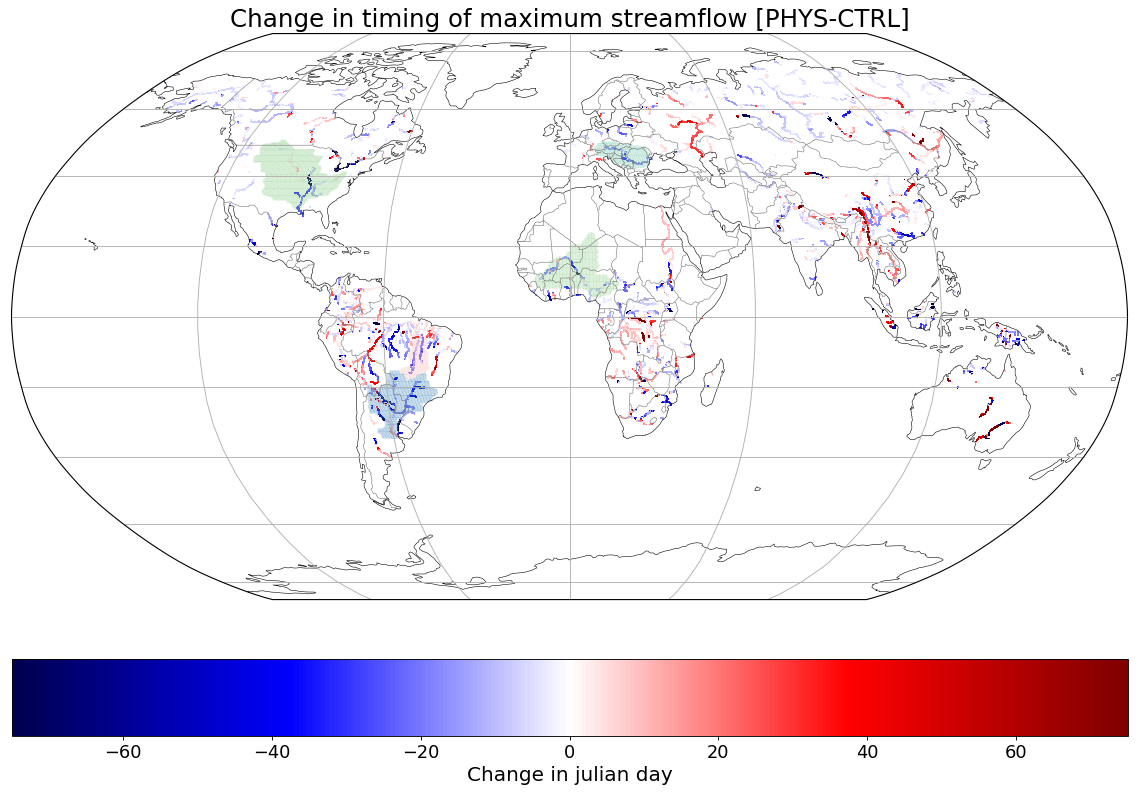

In [17]:
# --- Plot change in mean julian day of max discharge --- #                

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,diffTimingPhys,cmap='seismic',vmin=-75,vmax=75,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in julian day',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Change in timing of maximum streamflow [PHYS-CTRL]')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.45')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')

## -- Overlay basin outlines? 
ax.pcolormesh(lon,lat,np.transpose(mississippi),cmap='Accent',alpha=0.07,transform=ccrs.PlateCarree())
#ax.pcolormesh(lon,lat,np.transpose(amazonas),cmap='Set2',alpha=0.07,transform=ccrs.PlateCarree())
ax.pcolormesh(lon,lat,np.transpose(parana),cmap='tab20',alpha=0.07,transform=ccrs.PlateCarree())
#ax.pcolormesh(lon,lat,np.transpose(volga),cmap='tab20c',alpha=0.07,transform=ccrs.PlateCarree())
#ax.pcolormesh(lon,lat,np.transpose(mekong),cmap='Dark2',alpha=0.07,transform=ccrs.PlateCarree())
ax.pcolormesh(lon,lat,np.transpose(tocantins),cmap='Pastel1',alpha=0.07,transform=ccrs.PlateCarree())
#ax.pcolormesh(lon,lat,np.transpose(ganges),cmap='tab20c',alpha=0.07,transform=ccrs.PlateCarree())
ax.pcolormesh(lon,lat,np.transpose(niger),cmap='Accent',alpha=0.07,transform=ccrs.PlateCarree())
#ax.pcolormesh(lon,lat,np.transpose(congo),cmap='tab20c',alpha=0.07,transform=ccrs.PlateCarree())
ax.pcolormesh(lon,lat,np.transpose(danube),cmap='Set2',alpha=0.07,transform=ccrs.PlateCarree())


plt.show() 

#Save the image 
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/JulianDayMaxOutflw-difference_PHYS+basins.jpg'
fig.savefig(fileName)  #HOW TO SAVE FIGURES 


## Is there any way to rule out places where RAD is the dominant controller? 

In [12]:
np.shape(ctrlAvg)

radCorr = np.full([len(lonSubset)],np.nan)
physCorr = np.full([len(lonSubset)],np.nan)

#For each location, determine correlation of annual cycle between FULL and PHYS / FULL and RAD 
for iloc in range(len(lonSubset)):
    physCorr_full  = np.corrcoef(fullAvg[iloc,:],physAvg[iloc,:])
    physCorr[iloc] = physCorr_full[0,1]
    radCorr_full   = np.corrcoef(fullAvg[iloc,:],radAvg[iloc,:])
    radCorr[iloc]  = radCorr_full[0,1]
    
    


In [28]:

## -- Assign correlation values back into lat x lon array -- 

#Define empty arrays 
global_physCorr = np.full([len(lat),len(lon)],np.nan)
global_radCorr  = np.full([len(lat),len(lon)],np.nan)

#Fill in river network 
for inp in range(len(lonSubset)):
    ilon = int(lonSubset[inp])
    ilat = int(latSubset[inp])
    
    global_physCorr[ilat,ilon] = physCorr[inp]
    global_radCorr[ilat,ilon]  = radCorr[inp]



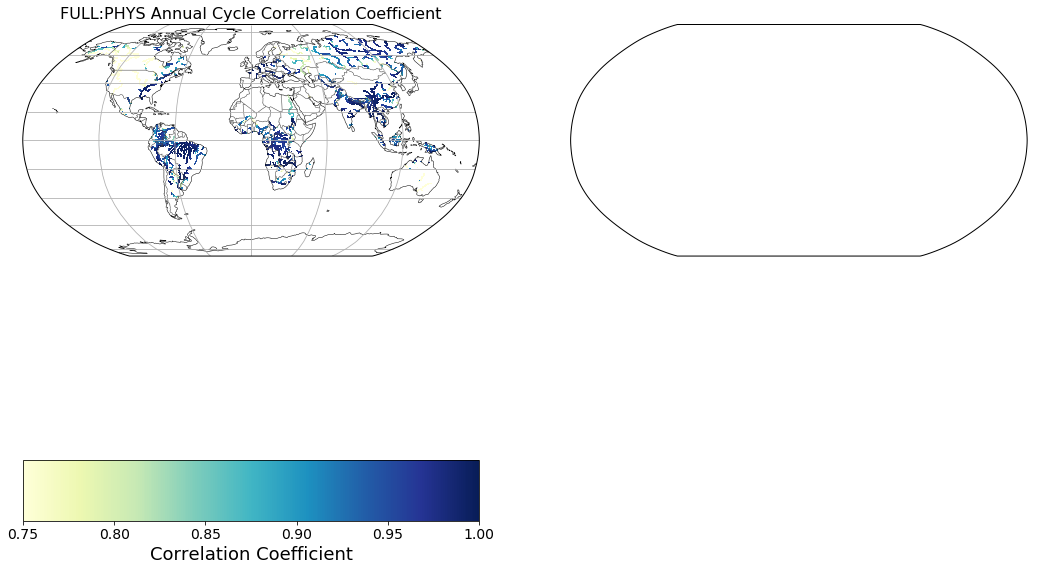

In [36]:
#Plot map of correlation coefficient in PHYS vs. RAD 

## --- Set up figure window --- 
fig, ax_array = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson()})
ax1,ax2 = ax_array.flatten()
fig.set_size_inches(18,14)

ax1.set_global()
contour_plot = ax1.pcolormesh(lon,lat,global_physCorr,cmap='YlGnBu',vmin=0.75,vmax=1,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Correlation Coefficient',fontsize=18)
cbar.ax.tick_params(labelsize=14)
#Other figure options 
ax1.set_title('FULL:PHYS Annual Cycle Correlation Coefficient')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



PHYS:  0.7881506063483509
RAD:   0.9831968636203334


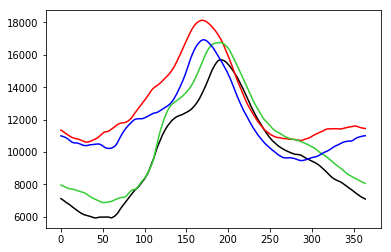

In [27]:
# --- Test to see if corrcoef makes sense at a given location 
# --- Good news is that it does seem to!

# print('PHYS: ', np.corrcoef(fullAvg[550,:],physAvg[550,:])[0,1])
# print('RAD:  ', np.corrcoef(fullAvg[550,:],radAvg[550,:])[0,1])

# plt.plot(np.arange(365),ctrlAvg[550,:],'Black')
# plt.plot(np.arange(365),fullAvg[550,:],'Red')
# plt.plot(np.arange(365),physAvg[550,:],'LimeGreen')
# plt.plot(np.arange(365),radAvg[550,:],'Blue')

* What if we use the manual sorting I've already done on the 32 existing large basins we're looking at 

In [10]:
# Create same original plot, but only in basins where PHYS plays a role 

#Based on visual analysis, basins to exclude from this analysis 
physBasinExclude = [1,2,3,4,6,7,9,10,11,12,13,22,23,28,29,30,31,32] 
physBasinInclude = [5,8,14,15,16,17,18,19,20,21,24,25,26,27]

#Empty array of ones 
physBasinMask = np.full(np.shape(diffTimingPhys),np.nan)

#Loop over exclusions and set physBasinMask to 0 if that's the basin 
for ilat in range(len(lat)):
    for ilon in range(len(lon)):
        for iExcl in range(len(physBasinExclude)):
            if basinMask[ilon,ilat]==physBasinExclude[iExcl]:
                physBasinMask[ilat,ilon]=0
        for iIncl in range(len(physBasinInclude)):
            if basinMask[ilon,ilat]==physBasinInclude[iIncl]:
                physBasinMask[ilat,ilon]=1
                                   

In [11]:
#Apply mask to difference in timing array 
maskedTimingPhys = physBasinMask*diffTimingPhys


In [76]:
# Allow for option to overlay certain basin outlines 
mississippi = np.full([len(lon),len(lat)],np.nan)
amazonas    = np.full([len(lon),len(lat)],np.nan)
parana      = np.full([len(lon),len(lat)],np.nan)
volga       = np.full([len(lon),len(lat)],np.nan)
mekong      = np.full([len(lon),len(lat)],np.nan)
tocantins   = np.full([len(lon),len(lat)],np.nan)
ganges      = np.full([len(lon),len(lat)],np.nan)
niger       = np.full([len(lon),len(lat)],np.nan)
congo       = np.full([len(lon),len(lat)],np.nan)
danube      = np.full([len(lon),len(lat)],np.nan)
nile        = np.full([len(lon),len(lat)],np.nan)
amur        =np.full([len(lon),len(lat)],np.nan)

mississippi[np.where(basinMask==5)]=1
amazonas[np.where(basinMask==17)]=2
parana[np.where(basinMask==16)]=3
volga[np.where(basinMask==10)]=4
mekong[np.where(basinMask==25)]=5
tocantins[np.where(basinMask==31)]=6
ganges[np.where(basinMask==24)]=7
niger[np.where(basinMask==18)]=8
congo[np.where(basinMask==19)]=9
danube[np.where(basinMask==8)]=10
nile[np.where(basinMask==20)]=11
amur[np.where(basinMask==14)]=12


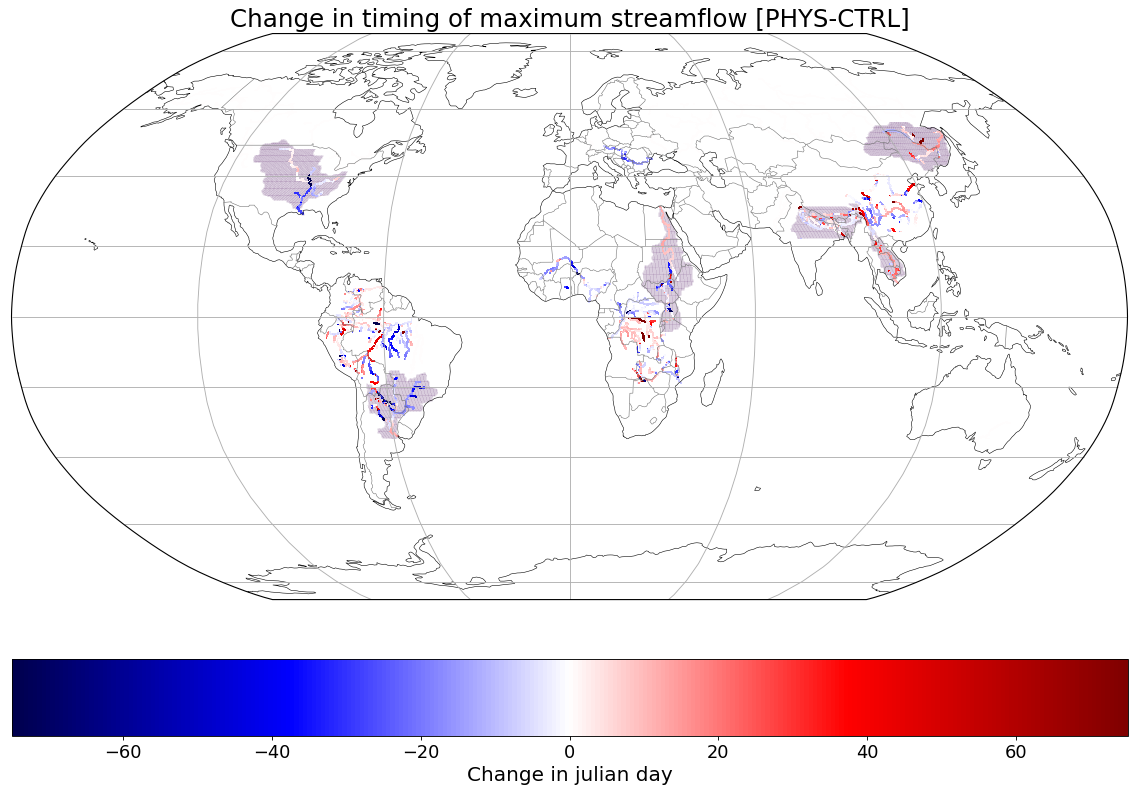

In [77]:
# --- Plot change in mean julian day of max discharge --- #                

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global

## -- Overlay basin outlines? 
# dummyArr = np.full([len(lon),len(lat)],np.nan)
# for iOutline in range(len(physBasinInclude)):
#     dummyArr[np.where(basinMask==physBasinInclude[iOutline])]=iOutline
# ax.pcolormesh(lon,lat,np.transpose(dummyArr),alpha=0.05,transform=ccrs.PlateCarree())

#These are to plot just the 6 basins that have significant timing shifts and maybe no sig precip change
ax.pcolormesh(lon,lat,np.transpose(mississippi),alpha=0.05,transform=ccrs.PlateCarree())
ax.pcolormesh(lon,lat,np.transpose(parana),alpha=0.05,transform=ccrs.PlateCarree())
ax.pcolormesh(lon,lat,np.transpose(mekong),alpha=0.05,transform=ccrs.PlateCarree())
ax.pcolormesh(lon,lat,np.transpose(ganges),alpha=0.05,transform=ccrs.PlateCarree())
ax.pcolormesh(lon,lat,np.transpose(nile),alpha=0.05,transform=ccrs.PlateCarree())
ax.pcolormesh(lon,lat,np.transpose(amur),alpha=0.05,transform=ccrs.PlateCarree())

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,maskedTimingPhys,cmap='seismic',vmin=-75,vmax=75,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in julian day',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Change in timing of maximum streamflow [PHYS-CTRL]')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.45')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')
 
plt.show() 

#Save the image 
#fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/JulianDayMaxOutflw-difference_PHYS+basins.jpg'
#fig.savefig(fileName)  #HOW TO SAVE FIGURES 


* Are there precipitation shifts in these basins that could be complicating the signal?

In [16]:
# Define empty arrays
avgMeltCtrl = np.full([12,len(physBasinInclude)],np.nan)
avgMeltFull = np.full([12,len(physBasinInclude)],np.nan)
avgMeltPhys = np.full([12,len(physBasinInclude)],np.nan)
avgMeltRad  = np.full([12,len(physBasinInclude)],np.nan)

avgSoilCtrl = np.full([12,len(physBasinInclude)],np.nan)
avgSoilFull = np.full([12,len(physBasinInclude)],np.nan) 
avgSoilPhys = np.full([12,len(physBasinInclude)],np.nan)
avgSoilRad  = np.full([12,len(physBasinInclude)],np.nan)

avgRunoffCtrl = np.full([12,len(physBasinInclude)],np.nan)
avgRunoffFull = np.full([12,len(physBasinInclude)],np.nan)
avgRunoffPhys = np.full([12,len(physBasinInclude)],np.nan)
avgRunoffRad  = np.full([12,len(physBasinInclude)],np.nan)

avgPrecipCtrl = np.full([12,len(physBasinInclude)],np.nan)
avgPrecipFull = np.full([12,len(physBasinInclude)],np.nan) 
avgPrecipPhys = np.full([12,len(physBasinInclude)],np.nan)
avgPrecipRad  = np.full([12,len(physBasinInclude)],np.nan)

avgFracCtrl = np.full([12,len(physBasinInclude)],np.nan)
avgFracFull = np.full([12,len(physBasinInclude)],np.nan) 
avgFracPhys = np.full([12,len(physBasinInclude)],np.nan)
avgFracRad  = np.full([12,len(physBasinInclude)],np.nan)

errSoilCtrl = np.full([12,len(physBasinInclude)],np.nan)
errSoilFull = np.full([12,len(physBasinInclude)],np.nan)
errSoilPhys = np.full([12,len(physBasinInclude)],np.nan)
errSoilRad  = np.full([12,len(physBasinInclude)],np.nan)

errRunoffCtrl = np.full([12,len(physBasinInclude)],np.nan)
errRunoffFull = np.full([12,len(physBasinInclude)],np.nan)
errRunoffPhys = np.full([12,len(physBasinInclude)],np.nan)
errRunoffRad  = np.full([12,len(physBasinInclude)],np.nan)

errPrecipCtrl = np.full([12,len(physBasinInclude)],np.nan)
errPrecipFull = np.full([12,len(physBasinInclude)],np.nan)
errPrecipPhys = np.full([12,len(physBasinInclude)],np.nan)
errPrecipRad  = np.full([12,len(physBasinInclude)],np.nan)

errFracCtrl = np.full([12,len(physBasinInclude)],np.nan)
errFracFull = np.full([12,len(physBasinInclude)],np.nan)
errFracPhys = np.full([12,len(physBasinInclude)],np.nan)
errFracRad  = np.full([12,len(physBasinInclude)],np.nan)

#Loop over each basin individually 

for iBasin in range(len(physBasinInclude)):
    ## Isolate data for the selected basin 
    basinChoice=physBasinInclude[iBasin]
    
    #Define empty arrays 
    basinArea     = np.full([len(cesmLat),len(cesmLon)],np.nan)
    
    basinMeltCtrl = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinMeltFull = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinMeltPhys = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinMeltRad  = np.full([360,len(cesmLat),len(cesmLon)],np.nan)

    basinSoilCtrl = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinSoilFull = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinSoilPhys = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinSoilRad  = np.full([360,len(cesmLat),len(cesmLon)],np.nan)

    basinRunoffCtrl = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinRunoffFull = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinRunoffPhys = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinRunoffRad  = np.full([360,len(cesmLat),len(cesmLon)],np.nan)

    basinPrecipCtrl = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinPrecipFull = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinPrecipPhys = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinPrecipRad  = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    
    basinFracCtrl = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinFracFull = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinFracPhys = np.full([360,len(cesmLat),len(cesmLon)],np.nan)
    basinFracRad  = np.full([360,len(cesmLat),len(cesmLon)],np.nan)

    for ilat in range(len(cesmLat)):
        for ilon in range(len(cesmLon)):
            if (basinMask_CESM[ilon,ilat]==basinChoice):
                basinArea[ilat,ilon] = cesmArea[ilat,ilon]
                
                basinMeltCtrl[:,ilat,ilon]=ctrlMelt[:,ilat,ilon]
                basinMeltFull[:,ilat,ilon]=fullMelt[:,ilat,ilon]
                basinMeltPhys[:,ilat,ilon]=physMelt[:,ilat,ilon]
                basinMeltRad[:,ilat,ilon] =radMelt[:,ilat,ilon]

                basinSoilCtrl[:,ilat,ilon]=ctrlSoil_1m[:,ilat,ilon]
                basinSoilFull[:,ilat,ilon]=fullSoil_1m[:,ilat,ilon]
                basinSoilPhys[:,ilat,ilon]=physSoil_1m[:,ilat,ilon]
                basinSoilRad[:,ilat,ilon] =radSoil_1m[:,ilat,ilon]

                basinRunoffCtrl[:,ilat,ilon]=ctrlRunoff[:,ilat,ilon]
                basinRunoffFull[:,ilat,ilon]=fullRunoff[:,ilat,ilon]
                basinRunoffPhys[:,ilat,ilon]=physRunoff[:,ilat,ilon]
                basinRunoffRad[:,ilat,ilon] =radRunoff[:,ilat,ilon]

                basinPrecipCtrl[:,ilat,ilon]=ctrlPrecip[:,ilat,ilon]
                basinPrecipFull[:,ilat,ilon]=fullPrecip[:,ilat,ilon]
                basinPrecipPhys[:,ilat,ilon]=physPrecip[:,ilat,ilon]
                basinPrecipRad[:,ilat,ilon] =radPrecip[:,ilat,ilon]
                
                basinFracCtrl[:,ilat,ilon] = ctrlRunoff[:,ilat,ilon]/(ctrlPrecip[:,ilat,ilon]*1000)
                basinFracFull[:,ilat,ilon] = fullRunoff[:,ilat,ilon]/(fullPrecip[:,ilat,ilon]*1000)
                basinFracPhys[:,ilat,ilon] = physRunoff[:,ilat,ilon]/(physPrecip[:,ilat,ilon]*1000)
                basinFracRad[:,ilat,ilon]  = radRunoff[:,ilat,ilon]/(radPrecip[:,ilat,ilon]*1000)
            
    ## Area weighting 

    #Define empty arrays 
    wgtMeltCtrl = np.full([360],np.nan)
    wgtMeltFull = np.full([360],np.nan)
    wgtMeltPhys = np.full([360],np.nan)
    wgtMeltRad  = np.full([360],np.nan)
    wgtSoilCtrl = np.full([360],np.nan)
    wgtSoilFull = np.full([360],np.nan)
    wgtSoilPhys = np.full([360],np.nan)
    wgtSoilRad  = np.full([360],np.nan)
    wgtRunoffCtrl = np.full([360],np.nan)
    wgtRunoffFull = np.full([360],np.nan)
    wgtRunoffPhys = np.full([360],np.nan)
    wgtRunoffRad  = np.full([360],np.nan)
    wgtPrecipCtrl = np.full([360],np.nan)
    wgtPrecipFull = np.full([360],np.nan)
    wgtPrecipPhys = np.full([360],np.nan)
    wgtPrecipRad  = np.full([360],np.nan)
    wgtFracCtrl   = np.full([360],np.nan)
    wgtFracFull   = np.full([360],np.nan)
    wgtFracPhys   = np.full([360],np.nan)
    wgtFracRad    = np.full([360],np.nan)
    
    for iMon in range(360):
        wgtMeltCtrl[iMon] = np.nansum(np.nansum(basinArea*basinMeltCtrl[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtMeltFull[iMon] = np.nansum(np.nansum(basinArea*basinMeltFull[iMon,:,:]))/np.nansum(np.nansum(basinArea)) 
        wgtMeltPhys[iMon] = np.nansum(np.nansum(basinArea*basinMeltPhys[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtMeltRad[iMon]  = np.nansum(np.nansum(basinArea*basinMeltRad[iMon,:,:]))/np.nansum(np.nansum(basinArea))

        wgtSoilCtrl[iMon] = np.nansum(np.nansum(basinArea*basinSoilCtrl[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtSoilFull[iMon] = np.nansum(np.nansum(basinArea*basinSoilFull[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtSoilPhys[iMon] = np.nansum(np.nansum(basinArea*basinSoilPhys[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtSoilRad[iMon] = np.nansum(np.nansum(basinArea*basinSoilRad[iMon,:,:]))/np.nansum(np.nansum(basinArea))  

        wgtRunoffCtrl[iMon] = np.nansum(np.nansum(basinArea*basinRunoffCtrl[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtRunoffFull[iMon] = np.nansum(np.nansum(basinArea*basinRunoffFull[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtRunoffPhys[iMon] = np.nansum(np.nansum(basinArea*basinRunoffPhys[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtRunoffRad[iMon] = np.nansum(np.nansum(basinArea*basinRunoffRad[iMon,:,:]))/np.nansum(np.nansum(basinArea)) 

        wgtPrecipCtrl[iMon] = np.nansum(np.nansum(basinArea*basinPrecipCtrl[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtPrecipFull[iMon] = np.nansum(np.nansum(basinArea*basinPrecipFull[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtPrecipPhys[iMon] = np.nansum(np.nansum(basinArea*basinPrecipPhys[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtPrecipRad[iMon] = np.nansum(np.nansum(basinArea*basinPrecipRad[iMon,:,:]))/np.nansum(np.nansum(basinArea)) 
        
        wgtFracCtrl[iMon] = np.nansum(np.nansum(basinArea*basinFracCtrl[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtFracFull[iMon] = np.nansum(np.nansum(basinArea*basinFracFull[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtFracPhys[iMon] = np.nansum(np.nansum(basinArea*basinFracPhys[iMon,:,:]))/np.nansum(np.nansum(basinArea))
        wgtFracRad[iMon] = np.nansum(np.nansum(basinArea*basinFracRad[iMon,:,:]))/np.nansum(np.nansum(basinArea)) 

    ## Define annual climatology 

    #Split up into 30 x 12 arrays 
    annMeltCtrl = np.split(wgtMeltCtrl,30)
    annMeltFull = np.split(wgtMeltFull,30)
    annMeltPhys = np.split(wgtMeltPhys,30)
    annMeltRad  = np.split(wgtMeltRad,30)

    annSoilCtrl = np.split(wgtSoilCtrl,30)
    annSoilFull = np.split(wgtSoilFull,30)
    annSoilPhys = np.split(wgtSoilPhys,30)
    annSoilRad  = np.split(wgtSoilRad,30)

    annRunoffCtrl = np.split(wgtRunoffCtrl,30)
    annRunoffFull = np.split(wgtRunoffFull,30)
    annRunoffPhys = np.split(wgtRunoffPhys,30)
    annRunoffRad  = np.split(wgtRunoffRad,30)

    annPrecipCtrl = np.split(wgtPrecipCtrl,30)
    annPrecipFull = np.split(wgtPrecipFull,30)
    annPrecipPhys = np.split(wgtPrecipPhys,30)
    annPrecipRad  = np.split(wgtPrecipRad,30)

    annFracCtrl = np.split(wgtFracCtrl,30)
    annFracFull = np.split(wgtFracFull,30)
    annFracPhys = np.split(wgtFracPhys,30)
    annFracRad  = np.split(wgtFracRad,30)
    
    #Get monthly averages 
    avgMeltCtrl[:,iBasin] = np.nanmean(annMeltCtrl,axis=0)
    avgMeltFull[:,iBasin]  = np.nanmean(annMeltFull,axis=0)
    avgMeltPhys[:,iBasin]  = np.nanmean(annMeltPhys,axis=0)
    avgMeltRad[:,iBasin]   = np.nanmean(annMeltRad,axis=0)

    avgSoilCtrl[:,iBasin]  = np.nanmean(annSoilCtrl,axis=0)
    avgSoilFull[:,iBasin]  = np.nanmean(annSoilFull,axis=0) 
    avgSoilPhys[:,iBasin]  = np.nanmean(annSoilPhys,axis=0)
    avgSoilRad[:,iBasin]   = np.nanmean(annSoilRad,axis=0)

    avgRunoffCtrl[:,iBasin]  = np.nanmean(annRunoffCtrl,axis=0)
    avgRunoffFull[:,iBasin]  = np.nanmean(annRunoffFull,axis=0) 
    avgRunoffPhys[:,iBasin]  = np.nanmean(annRunoffPhys,axis=0)
    avgRunoffRad[:,iBasin]   = np.nanmean(annRunoffRad,axis=0)

    avgPrecipCtrl[:,iBasin]  = np.nanmean(annPrecipCtrl,axis=0)
    avgPrecipFull[:,iBasin]  = np.nanmean(annPrecipFull,axis=0) 
    avgPrecipPhys[:,iBasin]  = np.nanmean(annPrecipPhys,axis=0)
    avgPrecipRad[:,iBasin]   = np.nanmean(annPrecipRad,axis=0)
    
    avgFracCtrl[:,iBasin]  = np.nanmean(annFracCtrl,axis=0)
    avgFracFull[:,iBasin]  = np.nanmean(annFracFull,axis=0) 
    avgFracPhys[:,iBasin]  = np.nanmean(annFracPhys,axis=0)
    avgFracRad[:,iBasin]   = np.nanmean(annFracRad,axis=0)
    
    #Estimate standard error for each 
    errSoilCtrl[:,iBasin]  = np.std(annSoilCtrl,axis=0)/np.sqrt(30)
    errSoilFull[:,iBasin]  = np.std(annSoilFull,axis=0)/np.sqrt(30)
    errSoilPhys[:,iBasin]  = np.std(annSoilPhys,axis=0)/np.sqrt(30)
    errSoilRad[:,iBasin]   = np.std(annSoilRad,axis=0)/np.sqrt(30)
    
    errRunoffCtrl[:,iBasin]  = np.std(annRunoffCtrl,axis=0)/np.sqrt(30)
    errRunoffFull[:,iBasin]  = np.std(annRunoffFull,axis=0)/np.sqrt(30)
    errRunoffPhys[:,iBasin]  = np.std(annRunoffPhys,axis=0)/np.sqrt(30)
    errRunoffRad[:,iBasin]   = np.std(annRunoffRad,axis=0)/np.sqrt(30)
    
    errPrecipCtrl[:,iBasin]  = np.std(annPrecipCtrl,axis=0)/np.sqrt(30)
    errPrecipFull[:,iBasin]  = np.std(annPrecipFull,axis=0)/np.sqrt(30)
    errPrecipPhys[:,iBasin]  = np.std(annPrecipPhys,axis=0)/np.sqrt(30)
    errPrecipRad[:,iBasin]   = np.std(annPrecipRad,axis=0)/np.sqrt(30)
    
    errFracCtrl[:,iBasin]  = np.std(annFracCtrl,axis=0)/np.sqrt(30)
    errFracFull[:,iBasin]  = np.std(annFracFull,axis=0)/np.sqrt(30)
    errFracPhys[:,iBasin]  = np.std(annFracPhys,axis=0)/np.sqrt(30)
    errFracRad[:,iBasin]   = np.std(annFracRad,axis=0)/np.sqrt(30)
        
    print('Done with basin ', iBasin)
       

/home/mdfowler/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Done with basin  0


/home/mdfowler/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Done with basin  1
Done with basin  2
Done with basin  3
Done with basin  4
Done with basin  5
Done with basin  6
Done with basin  7


/home/mdfowler/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:102: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


Done with basin  8
Done with basin  9
Done with basin  10
Done with basin  11
Done with basin  12
Done with basin  13


In [17]:
# Save basin annual cycles into file
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/BasinAnnCycles_CESMvars.pkl'
f_myFile = open(fileName,'wb')
pickle.dump([avgMeltCtrl, avgMeltFull, avgMeltPhys, avgMeltRad, avgSoilCtrl, 
             avgSoilFull, avgSoilPhys, avgSoilRad, avgRunoffCtrl, avgRunoffFull,
             avgRunoffPhys,avgRunoffRad,avgPrecipCtrl,avgPrecipFull,avgPrecipPhys,
             avgPrecipRad,physBasinInclude,errSoilCtrl,errSoilFull,errSoilPhys,errSoilRad,
             errRunoffCtrl,errRunoffFull,errRunoffPhys,errRunoffRad,errPrecipCtrl,
             errPrecipFull,errPrecipPhys,errPrecipRad,errFracCtrl,errFracFull,errFracPhys,
             errFracRad], f_myFile)
f_myFile.close()


In [12]:
# Load monthly averages from file
[avgMeltCtrl, avgMeltFull, avgMeltPhys, avgMeltRad, avgSoilCtrl, 
             avgSoilFull, avgSoilPhys, avgSoilRad, avgRunoffCtrl, avgRunoffFull,
             avgRunoffPhys,avgRunoffRad,avgPrecipCtrl,avgPrecipFull,avgPrecipPhys,
             avgPrecipRad,physBasinInclude,errSoilCtrl,errSoilFull,errSoilPhys,errSoilRad,
             errRunoffCtrl,errRunoffFull,errRunoffPhys,errRunoffRad,errPrecipCtrl,
             errPrecipFull,errPrecipPhys,errPrecipRad,errFracCtrl,errFracFull,errFracPhys,
             errFracRad]=np.load('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/BasinAnnCycles_CESMvars.pkl')


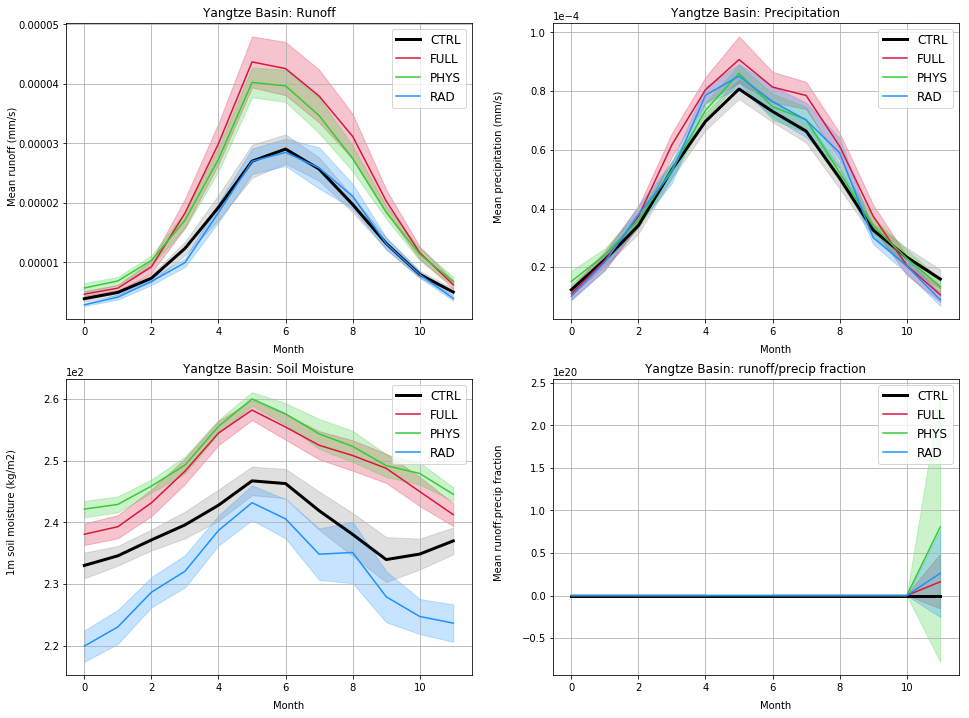

In [32]:
#Choose which basin to analyze 
numBasin = 13
iBasin   = physBasinInclude[numBasin] #Actual basin number key 

#Plot charts of annual cycles in basins

## --- Set up figure window --- 
fig, ax_array = plt.subplots(2,2)
ax1,ax2,ax3,ax4 = ax_array.flatten()
fig.set_size_inches(16,12)

#-- Plot 1: Seasonal Cycle of runoff --
ax1.plot(np.arange(12),avgRunoffCtrl[:,numBasin],color ='Black',label='CTRL',linewidth=3)
ax1.plot(np.arange(12),avgRunoffFull[:,numBasin],color ='Crimson',label='FULL')
ax1.plot(np.arange(12),avgRunoffPhys[:,numBasin],color = 'LimeGreen',label='PHYS')
ax1.plot(np.arange(12),avgRunoffRad[:,numBasin],color='DodgerBlue',label='RAD')
#Add error "bars"
ax1.fill_between(np.arange(12),avgRunoffCtrl[:,numBasin]-(2*errRunoffCtrl[:,numBasin]),avgRunoffCtrl[:,numBasin]+(2*errRunoffCtrl[:,numBasin]),alpha=0.25,color='Grey')
ax1.fill_between(np.arange(12),avgRunoffFull[:,numBasin]-(2*errRunoffFull[:,numBasin]),avgRunoffFull[:,numBasin]+(2*errRunoffFull[:,numBasin]),alpha=0.25,color='Crimson')
ax1.fill_between(np.arange(12),avgRunoffPhys[:,numBasin]-(2*errRunoffPhys[:,numBasin]),avgRunoffPhys[:,numBasin]+(2*errRunoffPhys[:,numBasin]),alpha=0.25,color='LimeGreen')
ax1.fill_between(np.arange(12),avgRunoffRad[:,numBasin]-(2*errRunoffRad[:,numBasin]),avgRunoffRad[:,numBasin]+(2*errRunoffRad[:,numBasin]),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax1.legend(fontsize=12)
ax1.set_title(basinNames[iBasin-1]+' Basin: Runoff',fontsize=12)
#Add axis-label
ax1.text(-0.12, 0.55, 'Mean runoff (mm/s)', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes)
ax1.text(0.55, -0.12, 'Month', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax1.transAxes)
ax1.grid()

#-- Plot 2: Seasonal Cycle of precipitation --
ax2.plot(np.arange(12),avgPrecipCtrl[:,numBasin]*1000,color ='Black',label='CTRL',linewidth=3)
ax2.plot(np.arange(12),avgPrecipFull[:,numBasin]*1000,color ='Crimson',label='FULL')
ax2.plot(np.arange(12),avgPrecipPhys[:,numBasin]*1000,color = 'LimeGreen',label='PHYS')
ax2.plot(np.arange(12),avgPrecipRad[:,numBasin]*1000,color='DodgerBlue',label='RAD')
#Add error "bars"
ax2.fill_between(np.arange(12),(1000*avgPrecipCtrl[:,numBasin])-(2*errPrecipCtrl[:,numBasin]*1000),(1000*avgPrecipCtrl[:,numBasin])+(2*errPrecipCtrl[:,numBasin]*1000),alpha=0.25,color='Grey')
ax2.fill_between(np.arange(12),(1000*avgPrecipFull[:,numBasin])-(2*errPrecipFull[:,numBasin]*1000),(1000*avgPrecipFull[:,numBasin])+(2*errPrecipFull[:,numBasin]*1000),alpha=0.25,color='Crimson')
ax2.fill_between(np.arange(12),(1000*avgPrecipPhys[:,numBasin])-(2*errPrecipPhys[:,numBasin]*1000),(1000*avgPrecipPhys[:,numBasin])+(2*errPrecipPhys[:,numBasin]*1000),alpha=0.25,color='LimeGreen')
ax2.fill_between(np.arange(12),(1000*avgPrecipRad[:,numBasin])-(2*errPrecipRad[:,numBasin]*1000),(1000*avgPrecipRad[:,numBasin])+(2*errPrecipRad[:,numBasin]*1000),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax2.legend(fontsize=12)
ax2.set_title(basinNames[iBasin-1]+' Basin: Precipitation',fontsize=12)
#Add axis-label
ax2.text(-0.12, 0.55, 'Mean precipitation (mm/s)', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax2.transAxes)
ax2.text(0.55, -0.12, 'Month', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax2.transAxes)
ax2.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
ax2.grid()

#-- Plot 3: Seasonal Cycle of 1m soil moisture --
ax3.plot(np.arange(12),avgSoilCtrl[:,numBasin],color ='Black',label='CTRL',linewidth=3)
ax3.plot(np.arange(12),avgSoilFull[:,numBasin],color ='Crimson',label='FULL')
ax3.plot(np.arange(12),avgSoilPhys[:,numBasin],color = 'LimeGreen',label='PHYS')
ax3.plot(np.arange(12),avgSoilRad[:,numBasin],color='DodgerBlue',label='RAD')
#Add error "bars"
ax3.fill_between(np.arange(12),avgSoilCtrl[:,numBasin]-(2*errSoilCtrl[:,numBasin]),avgSoilCtrl[:,numBasin]+(2*errSoilCtrl[:,numBasin]),alpha=0.25,color='Grey')
ax3.fill_between(np.arange(12),avgSoilFull[:,numBasin]-(2*errSoilFull[:,numBasin]),avgSoilFull[:,numBasin]+(2*errSoilFull[:,numBasin]),alpha=0.25,color='Crimson')
ax3.fill_between(np.arange(12),avgSoilPhys[:,numBasin]-(2*errSoilPhys[:,numBasin]),avgSoilPhys[:,numBasin]+(2*errSoilPhys[:,numBasin]),alpha=0.25,color='LimeGreen')
ax3.fill_between(np.arange(12),avgSoilRad[:,numBasin]-(2*errSoilRad[:,numBasin]),avgSoilRad[:,numBasin]+(2*errSoilRad[:,numBasin]),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax3.legend(fontsize=12)
ax3.set_title(basinNames[iBasin-1]+' Basin: Soil Moisture',fontsize=12)
#Add axis-label
ax3.text(-0.12, 0.55, '1m soil moisture (kg/m2)', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax3.transAxes)
ax3.text(0.55, -0.12, 'Month', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax3.transAxes)
ax3.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
ax3.grid()

#-- Plot 4: Runoff:Precip fraction --
ax4.plot(np.arange(12),avgFracCtrl[:,numBasin],color ='Black',label='CTRL',linewidth=3)
ax4.plot(np.arange(12),avgFracFull[:,numBasin],color ='Crimson',label='FULL')
ax4.plot(np.arange(12),avgFracPhys[:,numBasin],color = 'LimeGreen',label='PHYS')
ax4.plot(np.arange(12),avgFracRad[:,numBasin],color='DodgerBlue',label='RAD')
#Add error "bars"
ax4.fill_between(np.arange(12),avgFracCtrl[:,numBasin]-(2*errFracCtrl[:,numBasin]),avgFracCtrl[:,numBasin]+(2*errFracCtrl[:,numBasin]),alpha=0.25,color='Grey')
ax4.fill_between(np.arange(12),avgFracFull[:,numBasin]-(2*errFracFull[:,numBasin]),avgFracFull[:,numBasin]+(2*errFracFull[:,numBasin]),alpha=0.25,color='Crimson')
ax4.fill_between(np.arange(12),avgFracPhys[:,numBasin]-(2*errFracPhys[:,numBasin]),avgFracPhys[:,numBasin]+(2*errFracPhys[:,numBasin]),alpha=0.25,color='LimeGreen')
ax4.fill_between(np.arange(12),avgFracRad[:,numBasin]-(2*errFracRad[:,numBasin]),avgFracRad[:,numBasin]+(2*errFracRad[:,numBasin]),alpha=0.25,color='DodgerBlue')
#Other plot options 
ax4.legend(fontsize=12)
ax4.set_title(basinNames[iBasin-1]+' Basin: runoff/precip fraction',fontsize=12)
#Add axis-label
ax4.text(-0.12, 0.55, 'Mean runoff:precip fraction', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax4.transAxes)
ax4.text(0.55, -0.12, 'Month', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax4.transAxes)
ax4.grid()

#Save the image 
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/BasinStreamflow/CESMvariables/'+basinNames[iBasin-1]+'_floodVarsSeasonalCycle.jpg'
fig.savefig(fileName)  #HOW TO SAVE FIGURES 



## Is there something wrong that's making the Mekong data fall off of the continent? 

In [24]:
#Read in land fraction of each grid cell 
sfcFile = '/gdata/pritchard2/mdfowler/surfdata_0.9x1.25_simyr1850_c110921.nc'
fSfc  = xr.open_dataset(sfcFile,decode_times=False)

landfrac = fSfc.LANDFRAC_PFT.values #Land fraction from pft dataset
print('Shape of landfrac array: ', np.shape(landfrac))
print('Shape of basinMask array:', np.shape(basinMask_CESM))


Shape of landfrac array:  (192, 288)
Shape of basinMask array: (288, 192)


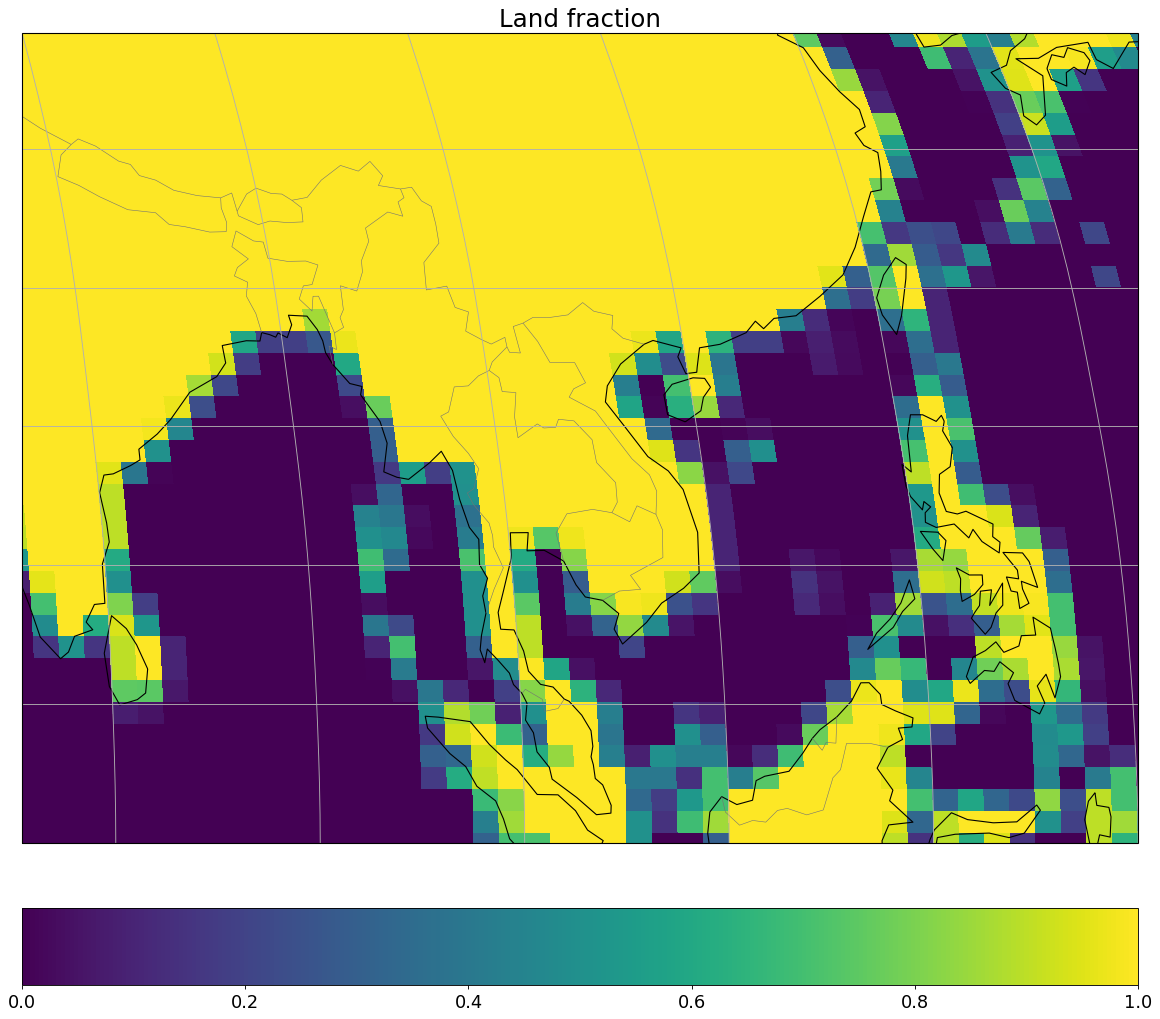

In [38]:
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
#ax.set_global
ax.set_extent([80,130,0,35], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Mekong River 

## --- Create Plot ---
contour_plot = ax.pcolormesh(cesmLon,cesmLat,landfrac,transform=ccrs.PlateCarree())

#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Land fraction')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=1,edgecolor='1')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')

plt.show() 


In [1]:
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
#ax.set_global
ax.set_extent([80,130,0,35], crs=ccrs.PlateCarree())   ## NOTE: this is centered on the Mekong River 

## --- Create Plot ---
contour_plot = ax.contourf(cesmLon,cesmLat,np.transpose(mekongCESM),cmap='Dark2',alpha=0.3,transform=ccrs.PlateCarree())

#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Basin')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.45')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')

plt.show() 




NameError: name 'plt' is not defined

## Notes that aren't necessary but I don't want to delete 

In [39]:
#Trying to sanity check the area weighting; but things look remarkably different even though the above looks correct 

np.shape(wgtMeltCtrl)
print('Area weighted for month 1: ', wgtMeltCtrl[10])           # 4.407373309276302e-08
rawAvg = np.nanmean(np.nanmean(basinMeltCtrl,axis=1),axis=1)    # 1.4687171167936509e-06
print('Raw average for month 1:   ', rawAvg[10])                # -0.9699916800935906

(wgtMeltCtrl[10]-rawAvg[10])/rawAvg[10]


Area weighted for month 1:  4.407373309276302e-08
Raw average for month 1:    1.4687171167936509e-06


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


-0.9699916800935906

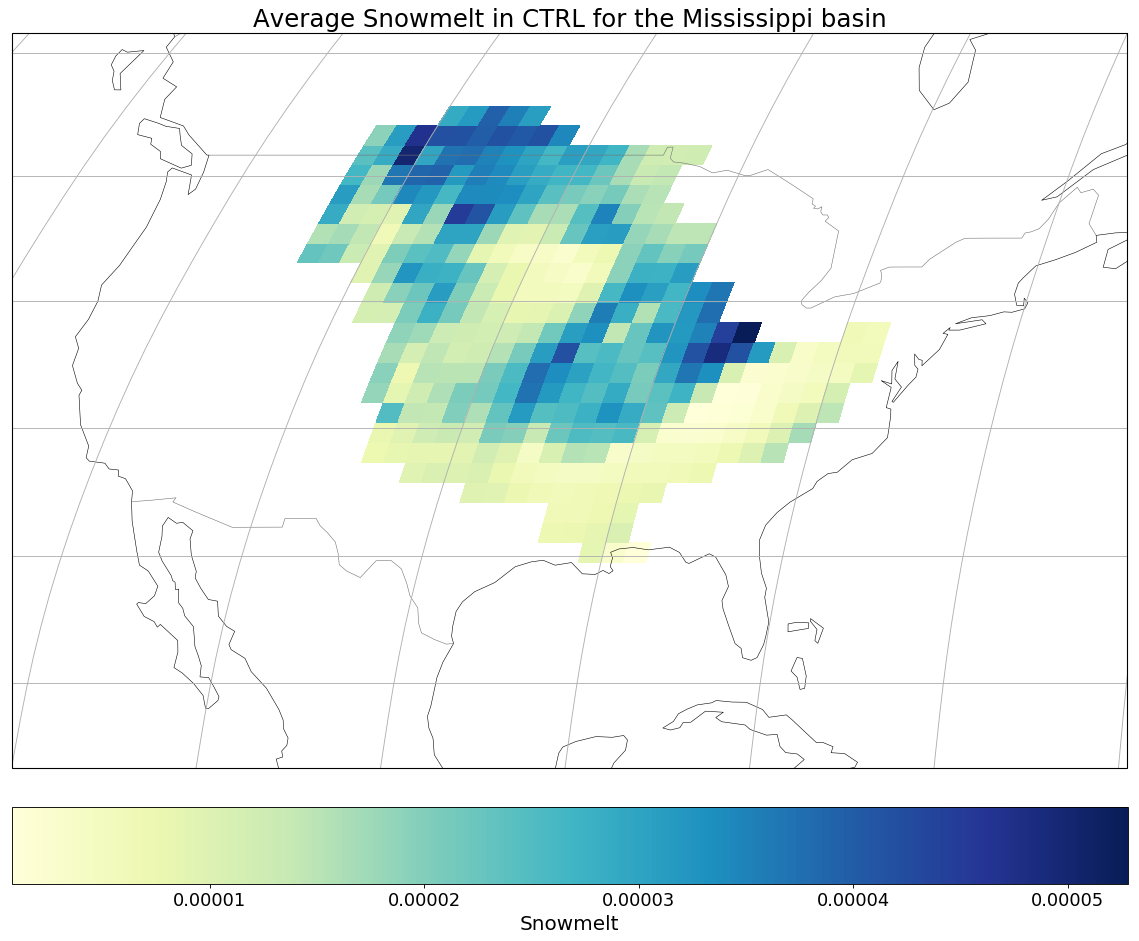

In [13]:
# --- Plot baseline for selected basin to make sure definition looks reasonable --- #

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_extent([-120,-70,20,55], crs=ccrs.PlateCarree())   ## NOTE: this is centered on US for the Mississippi
#ax.set_global

## --- Create Plot ---
contour_plot = ax.pcolormesh(cesmLon,cesmLat,basinMeltCtrl[1,:,:],cmap='YlGnBu',transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Snowmelt',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Average Snowmelt in CTRL for the %s basin' %basinNames[basinChoice-1])
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.45')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.45')

plt.show() 


